# Team Based Model

## Imports

In [1]:
import pep8
import autopep8
import sqlite3
import joblib
import optuna
import plotly.graph_objects as go
import plotly.express as px
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid
import pickle
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import learning_curve, validation_curve
import sklearn.model_selection
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr

from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

sys.path.append("..")

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pep8.py:110: FutureWarning: Possible nested set at position 1
  EXTRANEOUS_WHITESPACE_REGEX = re.compile(r'[[({] | []}),;:]')
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_t

In [78]:
pd.options.display.max_columns=230
pd.options.display.max_rows=120

## Gather Team Level Basic, Advanced, and Scoring Data

In [3]:
def load_team_data(conn):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", connection)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", connection)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", connection)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    return df


connection = sqlite3.connect('../data/nba.db')
df = load_team_data(connection)
connection.close()

In [4]:
df.loc[df['GAME_ID'] == '0022000098']

SEASON     TEAM_ID TEAM_ABBREVIATION         TEAM_NAME     GAME_ID  \
51534  2020-21  1610612745               HOU   Houston Rockets  0022000098   
51535  2020-21  1610612742               DAL  Dallas Mavericks  0022000098   

        GAME_DATE      MATCHUP WL  MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  \
51534  2021-01-04  HOU vs. DAL  L  240   30   77   0.390    11    40    0.275   
51535  2021-01-04    DAL @ HOU  W  240   39   82   0.476    16    39    0.410   

       FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  PF  PTS  \
51534   29   36   0.806     7    28   35   17    5    4   12  19  100   
51535   19   20   0.950    10    41   51   24    4    3   18  31  113   

       PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  \
51534         -13         102.2       105.3         114.4       118.9   
51535          13         114.4       118.9         102.2       105.3   

       E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  OREB_PCT  \
51534         -12.2       -13.7    0.567     1.42       14.0     0.176   
51535          12.2        13.7    0.615     1.33       18.1     0.326   

       DREB_PCT  REB_PCT  E_TM_TOV_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  USG_PCT  \
51534     0.674    0.404        12.265        12.6    0.461   0.539      1.0   
51535     0.824    0.596        18.219        18.9    0.573   0.622      1.0   

       E_USG_PCT  E_PACE  PACE  PACE_PER40  POSS    PIE  PCT_FGA_2PT  \
51534      0.196   98.32  95.0       79.17  95.0  0.425        0.481   
51535      0.191   98.32  95.0       79.17  95.0  0.575        0.524   

       PCT_FGA_3PT  PCT_PTS_2PT  PCT_PTS_2PT_MR  PCT_PTS_3PT  PCT_PTS_FB  \
51534        0.519        0.380           0.020        0.330        0.04   
51535        0.476        0.407           0.071        0.425        0.08   

       PCT_PTS_FT  PCT_PTS_OFF_TOV  PCT_PTS_PAINT  PCT_AST_2PM  PCT_UAST_2PM  \
51534       0.290            0.230          0.360        0.579         0.421   
51535       0.168            0.088          0.336        0.478         0.522   

       PCT_AST_3PM  PCT_UAST_3PM  PCT_AST_FGM  PCT_UAST_FGM  
51534        0.545         0.455        0.567         0.433  
51535        0.813         0.188        0.615         0.385

In [5]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    df = df.dropna(subset=['E_OFF_RATING'])

    return df


clean_df = clean_team_data(df)
clean_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53671  2020-21  1610612749               MIL         Milwaukee Bucks   
53672  2020-21  1610612756               PHX            Phoenix Suns   
53673  2020-21  1610612749               MIL         Milwaukee Bucks   
53674  2020-21  1610612749               MIL         Milwaukee Bucks   
53675  2020-21  1610612756               PHX            Phoenix Suns   

          GAME_ID  GAME_DATE      MATCHUP  WL  MIN  FGM  FGA  FG_PCT  FG3M  \
0      0020000002 2000-10-31    CLE @ BKN   1  240   32   78   0.410     2   
1      0020000002 2000-10-31  BKN vs. CLE   0  240   31   85   0.365     3   
2      0020000008 2000-10-31  HOU vs. MIN   0  240   34   74   0.459     2   
3      0020000008 2000-10-31    MIN @ HOU   1  240   43   88   0.489     6   
4      0020000009 2000-10-31  SAS vs. IND   1  240   33   64   0.516     4   
...           ...        ...          ...  ..  ...  ...  ...     ...   ...   
53671  0042000404 2021-07-14  MIL vs. PHX   1  240   39   97   0.402     7   
53672  0042000405 2021-07-17  PHX vs. MIL   0  240   48   87   0.552    13   
53673  0042000405 2021-07-17    MIL @ PHX   1  240   50   87   0.575    14   
53674  0042000406 2021-07-20  MIL vs. PHX   1  240   37   82   0.451     6   
53675  0042000406 2021-07-20    PHX @ MIL   0  240   38   86   0.442     6   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  \
0         7    0.286   20   32   0.625    11    41   52   16    5    8   19   
1        10    0.300   17   26   0.654    12    35   47   24    9    8   15   
2         9    0.222   28   40   0.700    11    27   38   18    9    7   18   
3        11    0.545   14   16   0.875    13    31   44   29    7    1   16   
4         8    0.500   28   35   0.800     5    32   37   17    6    4   18   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...  ...  ...  ...   
53671    29    0.241   24   29   0.828    17    31   48   22   11    3    5   
53672    19    0.684   10   11   0.909     8    27   35   23    9    5    9   
53673    28    0.500    9   17   0.529    11    26   37   26    7    1   12   
53674    27    0.222   25   29   0.862    11    42   53   20   10    6   19   
53675    25    0.240   16   19   0.842     6    31   37   14   11    4   15   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
0      27   86           4          85.9        87.8          82.5   
1      31   82          -4          82.5        83.7          85.9   
2      17   98          -8          99.4       103.2         108.1   
3      25  106           8         108.1       110.4          99.4   
4      22   98          13         106.1       104.3          90.7   
...    ..  ...         ...           ...         ...           ...   
53671  18  109           6         111.5       112.4         104.7   
53672  20  119          -4         128.2       129.3         128.8   
53673  17  123           4         128.8       135.2         128.2   
53674  17  105           7         102.2       101.9          94.8   
53675  21   98          -7          94.8        96.1         102.2   

       DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
0            83.7           3.5         4.1    0.500     0.84       12.6   
1            87.8          -3.5        -4.1    0.774     1.60       17.7   
2           110.4          -8.7        -7.3    0.529     1.00       14.1   
3           103.2           8.7         7.3    0.674     1.81       20.7   
4            90.4          15.4     

In [6]:
from src.data.make_team_dataset import prep_for_aggregation


def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE', 'PACE_PER40', 'MIN'])

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

#     df = df.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
#                             'PCT_PTS_3PT', 'PCT_PTS_FB',
#                             'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
#                             'PCT_AST_2PM', 'PCT_UAST_2PM',
#                             'PCT_AST_3PM', 'PCT_UAST_3PM',
#                             'PCT_AST_FGM', 'PCT_UAST_FGM',
#                             'FGM', 'FGA'])

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']

    df = df[['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
             'GAME_DATE', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'POINT_DIFF', 'WL',
             'RECORD', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
             'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
             'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
             'E_NET_RATING', 'NET_RATING', 'POSS', 'PIE', 'PTS_2PT_MR',
             'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT', 'AST_2PM', 'AST_3PM',
             'UAST_2PM', 'UAST_3PM']]

    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53671  2020-21  1610612749               MIL         Milwaukee Bucks   
53672  2020-21  1610612756               PHX            Phoenix Suns   
53673  2020-21  1610612749               MIL         Milwaukee Bucks   
53674  2020-21  1610612749               MIL         Milwaukee Bucks   
53675  2020-21  1610612756               PHX            Phoenix Suns   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53671  0042000404 2021-07-14  MIL vs. PHX          1         109           6   
53672  0042000405 2021-07-17  PHX vs. MIL          1         119          -4   
53673  0042000405 2021-07-17    MIL @ PHX          0         123           4   
53674  0042000406 2021-07-20  MIL vs. PHX          1         105           7   
53675  0042000406 2021-07-20    PHX @ MIL          0          98          -7   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53671   1       1    32    68     7    29   24   29    17    31   48   22   
53672   0       0    35    68    13    19   10   11     8    27   35   23   
53673   1       1    36    59    14    28    9   17    11    26   37   26   
53674   1       1    31    55     6    27   25   29    11    42   53   20   
53675   0       0    32    61     6    25   16   19     6    31   37   14   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53671   11    3    5  18  109           6         111.5       112.4   
53672    9    5    9  20  119          -4         128.2       129.3   
53673    7    1   12  17  123           4         128.8       135.2   
53674   10    6   19  17  105           7         102.2       101.9   
53675   11    4   15  21   98          -7          94.8        96.1   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  \
0              82.5        83.7           3.5         4.1   98.0  0.512   
1              85.9        87.8          -3.5        -4.1   98.0  0.488   
2             108.1       110.4          -8.7        -7.3   95.0  0.446   
3              99.4       103.2           8.7         7.3   96.0  0.554   
4              90.7        90

## Add Betting Data 

In [7]:
def load_betting_data(conn):
    spreads = pd.read_sql("SELECT * FROM spreads", conn)
    moneylines = pd.read_sql("SELECT * FROM moneylines", conn)

    return spreads, moneylines


connection = sqlite3.connect("../data/nba.db")
spreads, moneylines = load_betting_data(connection)
connection.close()

In [8]:
spreads

SEASON     GM_DATE      HOME_TEAM    AWAY_TEAM  AWAY_SCOREBOARD  \
0      2006-07  2006-10-31          Miami      Chicago  22,37,21,28,108   
1      2006-07  2006-10-31    L.A. Lakers      Phoenix  41,17,21,27,106   
2      2006-07  2006-11-02         Dallas  San Antonio   26,19,27,25,97   
3      2006-07  2006-11-02  L.A. Clippers       Denver   24,24,22,25,95   
4      2006-07  2006-11-03        Memphis    Charlotte   21,26,23,13,83   
...        ...         ...            ...          ...              ...   
18880  2006-07  2007-04-03      Minnesota    Cleveland  33,22,25,21,101   
18881  2006-07  2007-04-04        Orlando      Toronto  24,28,32,27,111   
18882  2006-07  2007-04-07        Indiana       Boston   15,28,24,31,98   
18883  2006-07  2007-04-21        Toronto     Brooklyn   23,28,27,18,96   
18884  2006-07  2007-04-21        Chicago        Miami   28,18,16,29,91   

       HOME_SCOREBOARD         AWAY_SPREAD         HOME_SPREAD  
0       16,14,21,15,66       -,-,+4½-110,-       -,-,-4½-110,-  
1      26,27,34,27,114       -,-,-8½-110,-       -,-,+8½-110,-  
2       27,24,24,16,91        -,-,+3-110,-        -,-,-3-110,-  
3       18,31,16,31,96       -,-,+4½-110,-       -,-,-4½-110,-  
4       24,20,16,36,96        -,-,+5-110,-        -,-,-5-110,-  
...                ...                 ...                 ...  
18880   21,26,13,28,88  -,-3½-105,-4-110,-  -,+3½-105,+4-110,-  
18881  37,20,22,29,108        -,-,+5-115,-        -,-,-5-105,-  
18882  26,25,27,27,105       -,-,+10-110,-       -,-,-10-110,-  
18883   22,19,24,26,91       -,-,+4½-110,-       -,-,-4½-110,-  
18884   27,22,23,24,96        -,-,+5-105,-        -,-,-5-115,-  

[18885 rows x 8 columns]

In [9]:
moneylines

SEASON     GM_DATE     HOME_TEAM      AWAY_TEAM           AWAY_ML  \
0      2020-21  2020-12-22      Brooklyn   Golden State  +290,+275,+275,-   
1      2020-21  2020-12-22   L.A. Lakers  L.A. Clippers  +110,+110,+120,-   
2      2020-21  2020-12-23     Cleveland      Charlotte  -155,-156,-155,-   
3      2020-21  2020-12-23       Indiana       New York  +270,+300,+265,-   
4      2020-21  2020-12-23       Orlando          Miami  -195,-195,-210,-   
...        ...         ...           ...            ...               ...   
18878  2019-20  2020-08-05    Washington   Philadelphia  -610,-550,-620,-   
18879  2019-20  2020-08-05   San Antonio         Denver  -130,-135,-140,-   
18880  2019-20  2020-08-11   San Antonio        Houston  +155,+163,+145,-   
18881  2019-20  2020-08-11       Orlando       Brooklyn  +160,+162,+165,-   
18882  2019-20  2020-08-11  Philadelphia        Phoenix  -535,-525,-470,-   

                HOME_ML  
0      -360,-330,-350,-  
1      -130,-130,-140,-  
2      +135,+136,+135,-  
3      -330,-370,-330,-  
4      +170,+170,+175,-  
...                 ...  
18878  +460,+425,+410,-  
18879  +110,+115,+120,-  
18880  -175,-183,-165,-  
18881  -185,-182,-190,-  
18882  +410,+420,+335,-  

[18883 rows x 6 columns]

In [10]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))                    
                

In [11]:
def clean_moneyline_df(df=moneylines):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_mls = df['AWAY_ML'].str.split(",", expand=True)
    home_mls = df['HOME_ML'].str.split(",", expand=True)

    away_mls = away_mls.replace('-', np.nan).replace('', np.nan)
    away_mls = away_mls.fillna(value=np.nan)
    away_mls = away_mls.astype(float)

    home_mls = home_mls.replace('-', np.nan).replace('', np.nan)
    home_mls = home_mls.fillna(value=np.nan)
    home_mls = home_mls.astype(float)

    highest_away_ml = away_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_away_ml = convert_american_to_decimal(highest_away_ml)
    highest_away_ml = pd.DataFrame(
        highest_away_ml, columns=['HIGHEST_AWAY_ML'])

    highest_home_ml = home_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_home_ml = convert_american_to_decimal(highest_home_ml)
    highest_home_ml = pd.DataFrame(
        highest_home_ml, columns=['HIGHEST_HOME_ML'])

    moneylines = pd.concat(
        [df.iloc[:, :4], highest_home_ml, highest_away_ml], axis=1)

    return moneylines

In [12]:
clean_mls = clean_moneyline_df(df=moneylines)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN axis encountered


In [13]:
def clean_spreads_df(df=spreads):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_spreads = df['AWAY_SPREAD'].str.split(",", expand=True)
    home_spreads = df['HOME_SPREAD'].str.split(",", expand=True)

    for col in away_spreads.columns:
        away_spreads[col] = away_spreads[col].str[:-4]
        away_spreads[col] = away_spreads[col].str.replace('½', '.5')
        away_spreads[col] = away_spreads[col].str.replace('PK', '0')
        away_spreads[col] = away_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    away_spreads = away_spreads.replace('-', np.nan)
    away_spreads = away_spreads.replace('', np.nan)
    away_spreads = away_spreads.fillna(value=np.nan)

    away_spreads = away_spreads.astype(float)

    for col in home_spreads.columns:
        home_spreads[col] = home_spreads[col].str[:-4]
        home_spreads[col] = home_spreads[col].str.replace('½', '.5')
        home_spreads[col] = home_spreads[col].str.replace('PK', '0')
        home_spreads[col] = home_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    home_spreads = home_spreads.replace('-', np.nan).replace('', np.nan)
    home_spreads = home_spreads.fillna(value=np.nan)

    home_spreads = home_spreads.astype(float)

    highest_away_spread = away_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_away_spread = pd.DataFrame(
        highest_away_spread, columns=['HIGHEST_AWAY_SPREAD'])

    highest_home_spread = home_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_home_spread = pd.DataFrame(
        highest_home_spread, columns=['HIGHEST_HOME_SPREAD'])

    spreads = pd.concat(
        [df.iloc[:, :4], highest_home_spread, highest_away_spread], axis=1)

    return spreads

In [14]:
clean_spreads = clean_spreads_df(df = spreads)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: All-NaN axis encountered


In [15]:
# clean_spreads = clean_spreads_df(spreads)

clean_spreads

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_SPREAD  \
0      2006-07  2006-10-31       MIA       CHI                 -4.5   
1      2006-07  2006-10-31       LAL       PHX                  8.5   
2      2006-07  2006-11-02       DAL       SAS                 -3.0   
3      2006-07  2006-11-02       LAC       DEN                 -4.5   
4      2006-07  2006-11-03       MEM       CHA                 -5.0   
...        ...         ...       ...       ...                  ...   
18880  2006-07  2007-04-03       MIN       CLE                  4.0   
18881  2006-07  2007-04-04       ORL       TOR                 -5.0   
18882  2006-07  2007-04-07       IND       BOS                -10.0   
18883  2006-07  2007-04-21       TOR       BKN                 -4.5   
18884  2006-07  2007-04-21       CHI       MIA                 -5.0   

       HIGHEST_AWAY_SPREAD  
0                      4.5  
1                     -8.5  
2                      3.0  
3                      4.5  
4                      5.0  
...                    ...  
18880                 -4.0  
18881                  5.0  
18882                 10.0  
18883                  4.5  
18884                  5.0  

[18885 rows x 6 columns]

In [16]:
clean_mls

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_ML  \
0      2020-21  2020-12-22       BKN       GSW         1.277778   
1      2020-21  2020-12-22       LAL       LAC         1.714286   
2      2020-21  2020-12-23       CLE       CHA         2.360000   
3      2020-21  2020-12-23       IND       NYK         1.270270   
4      2020-21  2020-12-23       ORL       MIA         2.750000   
...        ...         ...       ...       ...              ...   
18878  2019-20  2020-08-05       WAS       PHI         5.600000   
18879  2019-20  2020-08-05       SAS       DEN         2.200000   
18880  2019-20  2020-08-11       SAS       HOU         1.546448   
18881  2019-20  2020-08-11       ORL       BKN         1.526316   
18882  2019-20  2020-08-11       PHI       PHX         5.200000   

       HIGHEST_AWAY_ML  
0             3.900000  
1             2.200000  
2             1.641026  
3             4.000000  
4             1.476190  
...                ...  
18878         1.161290  
18879         1.714286  
18880         2.630000  
18881         2.650000  
18882         1.186916  

[18883 rows x 6 columns]

In [17]:
def merge_betting_and_boxscore_data(clean_spreads, clean_mls, clean_boxscores):
    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])

    temp = pd.merge(clean_mls, clean_spreads, on=[
                    'SEASON', 'GM_DATE', 'HOME_TEAM', 'AWAY_TEAM'])
    temp['GM_DATE'] = pd.to_datetime(temp['GM_DATE'])

    merged_df = pd.merge(clean_boxscores, temp, how='left', 
                         left_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                         right_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GM_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['HIGHEST_HOME_ML'] if row['HOME_GAME'] == 1
                                      else row['HIGHEST_AWAY_ML'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['HIGHEST_HOME_SPREAD'] if row['HOME_GAME'] == 1
                                          else -row['HIGHEST_HOME_SPREAD'], axis=1)

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'GM_DATE',
                                        'HIGHEST_HOME_ML', 'HIGHEST_AWAY_ML',
                                        'HIGHEST_HOME_SPREAD', 'HIGHEST_AWAY_SPREAD'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)

    return merged_df


merged_df = merge_betting_and_boxscore_data(
    clean_spreads, clean_mls, clean_boxscores=clean_df2)

In [18]:
merged_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53669  2020-21  1610612749               MIL         Milwaukee Bucks   
53670  2020-21  1610612756               PHX            Phoenix Suns   
53671  2020-21  1610612749               MIL         Milwaukee Bucks   
53672  2020-21  1610612749               MIL         Milwaukee Bucks   
53673  2020-21  1610612756               PHX            Phoenix Suns   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53669  0042000404 2021-07-14  MIL vs. PHX          1         109           6   
53670  0042000405 2021-07-17  PHX vs. MIL          1         119          -4   
53671  0042000405 2021-07-17    MIL @ PHX          0         123           4   
53672  0042000406 2021-07-20  MIL vs. PHX          1         105           7   
53673  0042000406 2021-07-20    PHX @ MIL          0          98          -7   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53669   1       1    32    68     7    29   24   29    17    31   48   22   
53670   0       0    35    68    13    19   10   11     8    27   35   23   
53671   1       1    36    59    14    28    9   17    11    26   37   26   
53672   1       1    31    55     6    27   25   29    11    42   53   20   
53673   0       0    32    61     6    25   16   19     6    31   37   14   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53669   11    3    5  18  109           6         111.5       112.4   
53670    9    5    9  20  119          -4         128.2       129.3   
53671    7    1   12  17  123           4         128.8       135.2   
53672   10    6   19  17  105           7         102.2       101.9   
53673   11    4   15  21   98          -7          94.8        96.1   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  \
0              82.5        83.7           3.5         4.1   98.0  0.512   
1              85.9        87.8          -3.5        -4.1   98.0  0.488   
2             108.1       110.4          -8.7        -7.3   95.0  0.446   
3              99.4       103.2           8.7         7.3   96.0  0.554   
4              90.7        90

In [19]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    

    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['_team', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION_team'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'TEAM_ID_opp',
                             'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 
                             'POINT_DIFF_opp', 'WL_opp',
                             'ML_opp', 'SPREAD_opp', 'OFF_RATING_team',
                             'DEF_RATING_team', 'NET_RATING_team', 'OFF_RATING_opp',
                             'DEF_RATING_opp', 'NET_RATING_opp']
                 )
    
    return matchups


matchups = create_matchups(merged_df)

In [20]:
matchups

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
1          2000-01    1610612739                    CLE   
2          2000-01    1610612751                    BKN   
5          2000-01    1610612745                    HOU   
6          2000-01    1610612750                    MIN   
9          2000-01    1610612759                    SAS   
...            ...           ...                    ...   
107338     2020-21    1610612749                    MIL   
107341     2020-21    1610612756                    PHX   
107342     2020-21    1610612749                    MIL   
107345     2020-21    1610612749                    MIL   
107346     2020-21    1610612756                    PHX   

                TEAM_NAME_team     GAME_ID GAME_DATE_team MATCHUP_team  \
1          Cleveland Cavaliers  0020000002     2000-10-31    CLE @ BKN   
2              New Jersey Nets  0020000002     2000-10-31  BKN vs. CLE   
5              Houston Rockets  0020000008     2000-10-31  HOU vs. MIN   
6       Minnesota Timberwolves  0020000008     2000-10-31    MIN @ HOU   
9            San Antonio Spurs  0020000009     2000-10-31  SAS vs. IND   
...                        ...         ...            ...          ...   
107338         Milwaukee Bucks  0042000404     2021-07-14  MIL vs. PHX   
107341            Phoenix Suns  0042000405     2021-07-17  PHX vs. MIL   
107342         Milwaukee Bucks  0042000405     2021-07-17    MIL @ PHX   
107345         Milwaukee Bucks  0042000406     2021-07-20  MIL vs. PHX   
107346            Phoenix Suns  0042000406     2021-07-20    PHX @ MIL   

        HOME_GAME_team  TEAM_SCORE_team  POINT_DIFF_team  WL_team  \
1                    0               86                4        1   
2                    1               82               -4        0   
5                    1               98               -8        0   
6                    0              106                8        1   
9                    1               98               13        1   
...                ...              ...              ...      ...   
107338               1              109                6        1   
107341               1              119               -4        0   
107342               0              123                4        1   
107345               1              105                7        1   
107346               0               98               -7        0   

        RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
1                 1         30         71          2          7        20   
2                 0         28         75          3         10        17   
5                 0         32         65          2          9        28   
6                 1         37         77          6         11        14   
9                 1         29         56          4          8        28   
...             ...        ...        ...        ...        ...       ...   
107338            1         32         68          7         29        24   
107341            0         35         68         13         19        10   
107342            1         36         59         14         28         9   
107345            1         31         55          6         27        25   
107346            0         32         61          6         25        16   

        FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  \
1             32         11         41        52        16         5   
2             26         12         35        47        24         9   
5             40         11         27        38        18         9   
6             16         13         31        44        29         7   
9             35          5         32        37        17         6   
...          ...        ...        ...       ...       ...       ...   
107338        29         17         31        48        22        11   
107341        11          8         27        35        23         9   
107342 

In [21]:
def get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []
    for season in tqdm(df['SEASON_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values(
                'GAME_DATE_team')

            avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

            avg_ml = team_df['ML_team'].shift(1).expanding().mean()

            record = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec = team_df['TEAM_COVERED_team'].shift(
                1).expanding().mean()

            ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
                1).expanding().mean()

            records = pd.DataFrame({'WL_PCT': record,
                                   'ATS_PCT': ATS_rec,
                                    'AVG_SPREAD': avg_spread,
                                    'AVG_ML': avg_ml,
                                    'AVG_ATS_DIFF': ATS_avg_diff
                                    })

            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
                1).ewm(alpha=alpha, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)

            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df


avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, alpha=0.1)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.08it/s]


In [22]:
avg_data_ewm_19

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team        TEAM_NAME_team  \
0         2000-01    1610612739                    CLE   Cleveland Cavaliers   
1         2000-01    1610612739                    CLE   Cleveland Cavaliers   
2         2000-01    1610612739                    CLE   Cleveland Cavaliers   
3         2000-01    1610612739                    CLE   Cleveland Cavaliers   
4         2000-01    1610612739                    CLE   Cleveland Cavaliers   
...           ...           ...                    ...                   ...   
53669     2020-21    1610612740                    NOP  New Orleans Pelicans   
53670     2020-21    1610612740                    NOP  New Orleans Pelicans   
53671     2020-21    1610612740                    NOP  New Orleans Pelicans   
53672     2020-21    1610612740                    NOP  New Orleans Pelicans   
53673     2020-21    1610612740                    NOP  New Orleans Pelicans   

          GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  \
0      0020000002     2000-10-31    CLE @ BKN               0   
1      0020000018     2000-11-01  CLE vs. SAC               1   
2      0020000038     2000-11-04  CLE vs. BOS               1   
3      0020000061     2000-11-08    CLE @ NYK               0   
4      0020000081     2000-11-10    CLE @ TOR               0   
...           ...            ...          ...             ...   
53669  0022001020     2021-05-09    NOP @ CHA               0   
53670  0022001028     2021-05-10    NOP @ MEM               0   
53671  0022000154     2021-05-12    NOP @ DAL               0   
53672  0022001059     2021-05-14    NOP @ GSW               0   
53673  0022001072     2021-05-16  NOP vs. LAL               1   

       TEAM_SCORE_team  POINT_DIFF_team  WL_team  ML_team  SPREAD_team  \
0                   86                4        1      NaN          NaN   
1                  102                2        1      NaN          NaN   
2                   91                2        1      NaN          NaN   
3                   99                2        1      NaN          NaN   
4                   88              -27        0      NaN          NaN   
...                ...              ...      ...      ...          ...   
53669              112                2        1     2.40          3.5   
53670              110               -5        0     4.65         10.0   
53671              107              -18        0     4.85         10.0   
53672              122               -3        0     2.10          1.5   
53673               98              -12        0     5.00         10.0   

       TEAM_COVERED_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      0          NaN        NaN        NaN        NaN   
1                      0          NaN        NaN        NaN        NaN   
2                      0          NaN        NaN        NaN        NaN   
3                      0          NaN        NaN        NaN        NaN   
4                      0          NaN        NaN        NaN        NaN   
...                  ...          ...        ...        ...        ...   
53669                  1     0.468875  32.835869  62.152077   9.654035   
53670                  1     0.522028  32.852295  61.836626   9.888813   
53671                  0     0.469789  32.867075  63.053811   9.899940   
53672                  0     0.422781  32.480125  62.648175   9.609764   
53673                  0     0.380479  32.732255  63.583885   9.748866   

       FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1            NaN        NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN        NaN   
3            NaN        NaN        NaN        NaN        NaN        NaN   
4            NaN        NaN        NaN        NaN        NaN        NaN   
...          ...        ...        .

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [23]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT.
    """
    
    df = df.copy()
    
    df['OREB_PCT_team'] = df['OREB_team'] / (df['OREB_team'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB_team'])

    df['DREB_PCT_team'] = df['DREB_team'] / (df['DREB_team'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB_team'])

    df['REB_PCT_team'] = df['REB_team'] / (df['REB_team'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB_team'])

    df['TS_PCT_team'] = df['PTS_team'] / ((2*(df['FG2A_team'] + df['FG3A_team']) + 0.44*df['FTA_team']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT_team'] = (df['FG2M_team'] + 1.5*df['FG3M_team']) / (df['FG2A_team']
                                                                    + df['FG3A_team'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO_team'] = (df['AST_team'] * 100) / df['POSS_team']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['POSS_opp']

    df['TOV_PCT_team'] = 100*df['TOV_team'] / (df['FG2A_team'] 
                                               + df['FG3A_team'] 
                                               + 0.44*df['FTA_team'] 
                                               + df['TOV_team'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])

    
    return df


def add_rest_days(df):
    df['REST'] = np.nan

    for season in df['SEASON_team'].unique():
        season_df = df.loc[df['SEASON_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['REST'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'REST'] = team_df['REST']
            
    df.loc[df['REST'] >= 8, 'REST'] = 8
            
    return df

In [24]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [25]:
full_df_ewm_19['REST'].value_counts()

2.0    29920
1.0    11495
3.0     8325
4.0     2101
5.0      406
6.0      367
8.0      268
7.0      166
Name: REST, dtype: int64

In [26]:
full_df_ewm_19

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team        TEAM_NAME_team  \
0         2000-01    1610612739                    CLE   Cleveland Cavaliers   
1         2000-01    1610612739                    CLE   Cleveland Cavaliers   
2         2000-01    1610612739                    CLE   Cleveland Cavaliers   
3         2000-01    1610612739                    CLE   Cleveland Cavaliers   
4         2000-01    1610612739                    CLE   Cleveland Cavaliers   
...           ...           ...                    ...                   ...   
53669     2020-21    1610612740                    NOP  New Orleans Pelicans   
53670     2020-21    1610612740                    NOP  New Orleans Pelicans   
53671     2020-21    1610612740                    NOP  New Orleans Pelicans   
53672     2020-21    1610612740                    NOP  New Orleans Pelicans   
53673     2020-21    1610612740                    NOP  New Orleans Pelicans   

          GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  \
0      0020000002     2000-10-31    CLE @ BKN               0   
1      0020000018     2000-11-01  CLE vs. SAC               1   
2      0020000038     2000-11-04  CLE vs. BOS               1   
3      0020000061     2000-11-08    CLE @ NYK               0   
4      0020000081     2000-11-10    CLE @ TOR               0   
...           ...            ...          ...             ...   
53669  0022001020     2021-05-09    NOP @ CHA               0   
53670  0022001028     2021-05-10    NOP @ MEM               0   
53671  0022000154     2021-05-12    NOP @ DAL               0   
53672  0022001059     2021-05-14    NOP @ GSW               0   
53673  0022001072     2021-05-16  NOP vs. LAL               1   

       TEAM_SCORE_team  POINT_DIFF_team  WL_team  ML_team  SPREAD_team  \
0                   86                4        1      NaN          NaN   
1                  102                2        1      NaN          NaN   
2                   91                2        1      NaN          NaN   
3                   99                2        1      NaN          NaN   
4                   88              -27        0      NaN          NaN   
...                ...              ...      ...      ...          ...   
53669              112                2        1     2.40          3.5   
53670              110               -5        0     4.65         10.0   
53671              107              -18        0     4.85         10.0   
53672              122               -3        0     2.10          1.5   
53673               98              -12        0     5.00         10.0   

       TEAM_COVERED_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      0          NaN        NaN        NaN        NaN   
1                      0          NaN        NaN        NaN        NaN   
2                      0          NaN        NaN        NaN        NaN   
3                      0          NaN        NaN        NaN        NaN   
4                      0          NaN        NaN        NaN        NaN   
...                  ...          ...        ...        ...        ...   
53669                  1     0.468875  32.835869  62.152077   9.654035   
53670                  1     0.522028  32.852295  61.836626   9.888813   
53671                  0     0.469789  32.867075  63.053811   9.899940   
53672                  0     0.422781  32.480125  62.648175   9.609764   
53673                  0     0.380479  32.732255  63.583885   9.748866   

       FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1            NaN        NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN        NaN   
3            NaN        NaN        NaN        NaN        NaN        NaN   
4            NaN        NaN        NaN        NaN        NaN        NaN   
...          ...        ...        .

In [27]:
full_df_ewm_19.loc[full_df_ewm_19['GAME_ID'] =='0020900329']

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
23559     2009-10    1610612750                    MIN   
24328     2009-10    1610612747                    LAL   

               TEAM_NAME_team     GAME_ID GAME_DATE_team MATCHUP_team  \
23559  Minnesota Timberwolves  0020900329     2009-12-11    MIN @ LAL   
24328      Los Angeles Lakers  0020900329     2009-12-11  LAL vs. MIN   

       HOME_GAME_team  TEAM_SCORE_team  POINT_DIFF_team  WL_team  ML_team  \
23559               0               92              -12        0      NaN   
24328               1              104               12        1      NaN   

       SPREAD_team  TEAM_COVERED_team  RECORD_team  FG2M_team  FG2A_team  \
23559         15.5                  1     0.167484  33.689036  69.535721   
24328        -15.5                  0     0.907495  32.852983  65.860017   

       FG3M_team  FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team  \
23559   3.815053  13.240519  14.857000  20.872406  11.526183  32.013443   
24328   7.010494  19.625811  19.063644  24.535273  11.553512  33.435331   

        REB_team   AST_team  STL_team  BLK_team   TOV_team    PF_team  \
23559  43.539626  19.910084  8.075799  3.303970  16.576778  21.854837   
24328  44.988843  23.784311  7.828181  5.067017  13.160692  18.972417   

         PTS_team  PLUS_MINUS_team  E_OFF_RATING_team  E_DEF_RATING_team  \
23559   93.680231        -8.280116          96.634364         105.633844   
24328  105.801091        12.480260         108.213477          95.397827   

       E_NET_RATING_team  POSS_team  PIE_team  PTS_2PT_MR_team  PTS_FB_team  \
23559          -9.007009  95.290388  0.435353        24.719898    15.690671   
24328          12.803415  95.800634  0.576813        16.007290    12.363382   

       PTS_OFF_TOV_team  PTS_PAINT_team  AST_2PM_team  AST_3PM_team  \
23559         16.819034       41.783286     16.245182      3.012912   
24328         18.398872       48.602298     17.544911      5.674183   

       UAST_2PM_team  UAST_3PM_team  ATS_DIFF_team  RECORD_opp   FG2M_opp  \
23559      16.766871       0.509179      -0.321397    0.832516  31.145047   
24328      14.575564       1.112650       2.043133    0.092505  30.306257   

        FG2A_opp  FG3M_opp   FG3A_opp    FTM_opp    FTA_opp   OREB_opp  \
23559  61.317786  6.996180  20.566295  18.681712  24.184487  10.637549   
24328  66.536071  5.289564  18.132463  16.839624  21.910185  12.148143   

        DREB_opp   REB_opp    AST_opp   STL_opp   BLK_opp    TOV_opp  \
23559  31.487081  42.12463  24.264531  9.395391  5.326773  14.545668   
24328  31.346386  43.49453  21.181214  6.985273  4.324290  15.741308   

          PF_opp     PTS_opp  PLUS_MINUS_opp  E_OFF_RATING_opp  \
23559  19.297453  101.960347        8.280116        105.633844   
24328  21.474481   93.320830      -12.480260         95.397827   

       E_DEF_RATING_opp  E_NET_RATING_opp   POSS_opp   PIE_opp  \
23559         96.634364          9.007009  95.230916  0.564647   
24328        108.213477        -12.803415  95.717616  0.423187   

       PTS_2PT_MR_opp  PTS_FB_opp  PTS_OFF_TOV_opp  PTS_PAINT_opp  \
23559       20.643109   16.273643        18.693608       41.07224   
24328       18.761456   10.372814        13.291304       41.25819   

       AST_2PM_opp  AST_3PM_opp  UAST_2PM_opp  UAST_3PM_opp  ATS_DIFF_opp  \
23559    17.662363     6.063286     12.654585      0.724917      0.321397   
24328    16.260788     4.308509     13.214900      0.717290     -2.043133   

       TEAM_COVERED_opp    WL_PCT  ATS_PCT  AVG_SPREAD    AVG_ML  \
23559          0.370240  0.136364      0.5    8.295455  3.510268   
24328          0.407102  0.850000      0.5   -9.375000  1.345411   

       AVG_ATS_DIFF  REST  OREB_PCT_team  OREB_PCT_opp  DREB_PCT_team  \
23559     -2.613636   2.0       0.267968      0.249409       0.750591   
24328     -0.275000   2.0       0.269313      0.266503       0.733497   

       DREB_PCT_opp  REB_PCT_team  REB_PCT_opp  TS_PCT_team  TS_PCT_opp  \
23559      0.

In [28]:
full_df_ewm_19.iloc[:, 14:].head(10)

RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1          NaN        NaN        NaN        NaN        NaN        NaN   
2          NaN        NaN        NaN        NaN        NaN        NaN   
3          NaN        NaN        NaN        NaN        NaN        NaN   
4          NaN        NaN        NaN        NaN        NaN        NaN   
5     0.755806  35.076799  71.021733   2.081073   7.594125  16.785915   
6     0.807922  33.139626  69.309733   2.490611   8.107587  17.898706   
7     0.844739  33.879582  69.633723   2.204890   7.895285  18.109802   
8     0.696418  34.603055  69.171287   2.168915   7.913671  17.739358   
9     0.582732  33.361901  68.490349   2.304585   7.764520  16.965686   

    FTA_team  OREB_team  DREB_team   REB_team   AST_team  STL_team  BLK_team  \
0        NaN        NaN        NaN        NaN        NaN       NaN       NaN   
1        NaN        NaN        NaN        NaN        NaN       NaN       NaN   
2        NaN        NaN        NaN        NaN        NaN       NaN       NaN   
3        NaN        NaN        NaN        NaN        NaN       NaN       NaN   
4        NaN        NaN        NaN        NaN        NaN       NaN       NaN   
5  24.909331  11.430759  28.347562  39.778320  21.855535  9.084638  7.626139   
6  25.995783  11.125406  28.913646  40.039052  21.246106  9.493415  7.065667   
7  25.996591  11.484728  31.422037  42.906765  21.965652  9.015477  6.861400   
8  25.470442  12.101948  29.943275  42.045223  21.971683  9.012760  6.183406   
9  24.250936  11.432329  31.258488  42.690817  21.649817  8.684189  5.663734   

    TOV_team    PF_team   PTS_team  PLUS_MINUS_team  E_OFF_RATING_team  \
0        NaN        NaN        NaN              NaN                NaN   
1        NaN        NaN        NaN              NaN                NaN   
2        NaN        NaN        NaN              NaN                NaN   
3        NaN        NaN        NaN              NaN                NaN   
4        NaN        NaN        NaN              NaN                NaN   
5  19.367512  25.802227  93.182731        -4.761202          95.746280   
6  19.502498  26.698117  91.649790        -0.970601          94.391855   
7  19.789539  27.331022  92.483638         1.132242          95.179304   
8  20.177657  27.975230  93.452215        -0.646802          97.149462   
9  20.311900  27.163053  90.603243        -2.663389          94.643752   

   E_DEF_RATING_team  E_NET_RATING_team  POSS_team  PIE_team  PTS_2PT_MR_team  \
0                NaN                NaN        NaN       NaN              NaN   
1                NaN                NaN        NaN       NaN              NaN   
2                NaN                NaN        NaN       NaN              NaN   
3                NaN                NaN        NaN       NaN              NaN   
4                NaN                NaN        NaN       NaN              NaN   
5         100.290628          -4.488547  95.715563  0.490166        27.594271   
6          96.045564          -1.609818  94.922586  0.521503        24.906398   
7          94.426719           0.788063  95.704144  0.537316        25.499379   
8          97.512280          -0.333569  95.053761  0.522863        24.182620   
9          97.036867          -2.368641  94.718497  0.504602        22.846855   

   PTS_FB_team  PTS_OFF_TOV_team  PTS_PAINT_team  AST_2PM_team  AST_3PM_team  \
0          NaN               NaN             NaN           NaN           NaN   
1          NaN               NaN             NaN           NaN           NaN   
2          NaN               NaN             NaN           NaN           NaN   
3          NaN               NaN             NaN           NaN           NaN   
4          NaN               NaN             NaN           NaN           NaN   
5    16.655124         17.225758       41.334912     19.774462      2.081073   
6    16.301887         18.458098       40.196334   

In [29]:
def compute_matchup_diffs(avg_data):
    
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 14:] - home_teams.iloc[:, 14:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :14], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :14], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_team':'SEASON',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

df_ewm_19_diffs = compute_matchup_diffs(full_df_ewm_19)

In [30]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION            TEAM_NAME     GAME_ID  \
0      2000-01  1610612755               PHI   Philadelphia 76ers  0020000001   
1      2000-01  1610612752               NYK      New York Knicks  0020000001   
2      2000-01  1610612739               CLE  Cleveland Cavaliers  0020000002   
3      2000-01  1610612751               BKN      New Jersey Nets  0020000002   
4      2000-01  1610612764               WAS   Washington Wizards  0020000003   
...        ...         ...               ...                  ...         ...   
53669  2020-21  1610612749               MIL      Milwaukee Bucks  0042000404   
53670  2020-21  1610612749               MIL      Milwaukee Bucks  0042000405   
53671  2020-21  1610612756               PHX         Phoenix Suns  0042000405   
53672  2020-21  1610612756               PHX         Phoenix Suns  0042000406   
53673  2020-21  1610612749               MIL      Milwaukee Bucks  0042000406   

       GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  POINT_DIFF_team  \
0     2000-10-31    PHI @ NYK          0         101               29   
1     2000-10-31  NYK vs. PHI          1          72              -29   
2     2000-10-31    CLE @ BKN          0          86                4   
3     2000-10-31  BKN vs. CLE          1          82               -4   
4     2000-10-31    WAS @ ORL          0          86              -11   
...          ...          ...        ...         ...              ...   
53669 2021-07-14  MIL vs. PHX          1         109                6   
53670 2021-07-17    MIL @ PHX          0         123                4   
53671 2021-07-17  PHX vs. MIL          1         119               -4   
53672 2021-07-20    PHX @ MIL          0          98               -7   
53673 2021-07-20  MIL vs. PHX          1         105                7   

       WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  RECORD_team_diff  \
0            1       NaN          NaN                  0               NaN   
1            0       NaN          NaN                  0               NaN   
2            1       NaN          NaN                  0               NaN   
3            0       NaN          NaN                  0               NaN   
4            0       NaN          NaN                  0               NaN   
...        ...       ...          ...                ...               ...   
53669        1  1.487805         -5.0                  1         -0.094598   
53670        1  2.600000          4.5                  1          0.014868   
53671        0  1.540541         -4.5                  0         -0.014868   
53672        0  2.650000          4.5                  0         -0.113386   
53673        1  1.526316         -4.5                  1          0.113386   

       FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN             NaN   
...               ...             ...             ...             ...   
53669        0.674764        0.181271        0.143275        4.353561   
53670        0.507277        1.463215        0.128950        4.518219   
53671       -0.507277       -1.463215       -0.128950       -4.518219   
53672       -0.556549       -0.416834       -0.216059       -4.966426   
53673        0.556549        0.416834        0.216059        4.966426   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0                NaN            NaN             NaN             NaN   
1                NaN            NaN             NaN             NaN   
2                NaN            NaN             NaN             NaN   
3                NaN            NaN             NaN         

## Add ELO Rating

In [31]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
    
#     print(MOV)
        
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_team, E_opp)
#     print("elo_diff:", elo_diff)
#     print("S_team:", S_team, "S_opp:", S_opp)
#     print("K_team:", K_team, "K_opp:", K_opp)
#     print(K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
#     print(elo_diff, K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [32]:
# full_df_ewm_19.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
#                             'SEASON_ID_team':'SEASON_ID',
#                             'TEAM_ID_team': 'TEAM_ID',
#                             'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
#                             'TEAM_NAME_team': 'TEAM_NAME',
#                             'GAME_DATE_team': 'GAME_DATE',
#                             'MATCHUP_team': 'MATCHUP',
#                             'HOME_GAME_team': 'HOME_GAME',
#                             'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)



In [33]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON'] != df.loc[idx-1, 'SEASON']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [34]:
df_ewm_19_diffs = add_elo_ratings(df_ewm_19_diffs)

progress:: 53674it [02:15, 397.18it/s]


In [35]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION            TEAM_NAME     GAME_ID  \
0      2000-01  1610612755               PHI   Philadelphia 76ers  0020000001   
1      2000-01  1610612752               NYK      New York Knicks  0020000001   
2      2000-01  1610612739               CLE  Cleveland Cavaliers  0020000002   
3      2000-01  1610612751               BKN      New Jersey Nets  0020000002   
4      2000-01  1610612764               WAS   Washington Wizards  0020000003   
...        ...         ...               ...                  ...         ...   
53669  2020-21  1610612749               MIL      Milwaukee Bucks  0042000404   
53670  2020-21  1610612749               MIL      Milwaukee Bucks  0042000405   
53671  2020-21  1610612756               PHX         Phoenix Suns  0042000405   
53672  2020-21  1610612756               PHX         Phoenix Suns  0042000406   
53673  2020-21  1610612749               MIL      Milwaukee Bucks  0042000406   

       GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  POINT_DIFF_team  \
0     2000-10-31    PHI @ NYK          0         101               29   
1     2000-10-31  NYK vs. PHI          1          72              -29   
2     2000-10-31    CLE @ BKN          0          86                4   
3     2000-10-31  BKN vs. CLE          1          82               -4   
4     2000-10-31    WAS @ ORL          0          86              -11   
...          ...          ...        ...         ...              ...   
53669 2021-07-14  MIL vs. PHX          1         109                6   
53670 2021-07-17    MIL @ PHX          0         123                4   
53671 2021-07-17  PHX vs. MIL          1         119               -4   
53672 2021-07-20    PHX @ MIL          0          98               -7   
53673 2021-07-20  MIL vs. PHX          1         105                7   

       WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  RECORD_team_diff  \
0            1       NaN          NaN                  0               NaN   
1            0       NaN          NaN                  0               NaN   
2            1       NaN          NaN                  0               NaN   
3            0       NaN          NaN                  0               NaN   
4            0       NaN          NaN                  0               NaN   
...        ...       ...          ...                ...               ...   
53669        1  1.487805         -5.0                  1         -0.094598   
53670        1  2.600000          4.5                  1          0.014868   
53671        0  1.540541         -4.5                  0         -0.014868   
53672        0  2.650000          4.5                  0         -0.113386   
53673        1  1.526316         -4.5                  1          0.113386   

       FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN             NaN   
...               ...             ...             ...             ...   
53669        0.674764        0.181271        0.143275        4.353561   
53670        0.507277        1.463215        0.128950        4.518219   
53671       -0.507277       -1.463215       -0.128950       -4.518219   
53672       -0.556549       -0.416834       -0.216059       -4.966426   
53673        0.556549        0.416834        0.216059        4.966426   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0                NaN            NaN             NaN             NaN   
1                NaN            NaN             NaN             NaN   
2                NaN            NaN             NaN             NaN   
3                NaN            NaN             NaN         

In [36]:
teams = []
elos = []
for team in df_ewm_19_diffs['TEAM_ABBREVIATION'].unique():
    team_elo = df_ewm_19_diffs.loc[df_ewm_19_diffs['TEAM_ABBREVIATION']==team, 'team_rating_n']
    elos.append(team_elo.values[-1])
    teams.append(team)
    
elo_final_2021 = pd.DataFrame({'TEAM':teams,
                              'ELO':elos})

elo_final_2021.sort_values('ELO', ascending=False)

TEAM          ELO
12  MIL  1728.363386
20  PHX  1719.537558
18  LAC  1697.946577
19  UTA  1679.950560
0   PHI  1661.348125
3   BKN  1660.302041
28  DEN  1613.781563
23  POR  1612.349168
7   ATL  1595.709352
22  LAL  1566.831320
13  DAL  1565.643688
1   NYK  1562.349322
21  GSW  1544.276209
25  MEM  1543.851540
27  MIA  1517.796953
26  BOS  1493.858554
11  CHI  1479.594003
16  IND  1478.544067
4   WAS  1469.235112
17  SAS  1464.124315
29  NOP  1459.508726
9   TOR  1438.306926
10  SAC  1435.928220
6   CHA  1416.621704
14  MIN  1394.031238
8   DET  1317.853574
2   CLE  1276.976508
15  HOU  1266.419298
5   ORL  1252.313586
24  OKC  1216.638223

In [37]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION            TEAM_NAME     GAME_ID  \
0      2000-01  1610612755               PHI   Philadelphia 76ers  0020000001   
1      2000-01  1610612752               NYK      New York Knicks  0020000001   
2      2000-01  1610612739               CLE  Cleveland Cavaliers  0020000002   
3      2000-01  1610612751               BKN      New Jersey Nets  0020000002   
4      2000-01  1610612764               WAS   Washington Wizards  0020000003   
...        ...         ...               ...                  ...         ...   
53669  2020-21  1610612749               MIL      Milwaukee Bucks  0042000404   
53670  2020-21  1610612749               MIL      Milwaukee Bucks  0042000405   
53671  2020-21  1610612756               PHX         Phoenix Suns  0042000405   
53672  2020-21  1610612756               PHX         Phoenix Suns  0042000406   
53673  2020-21  1610612749               MIL      Milwaukee Bucks  0042000406   

       GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  POINT_DIFF_team  \
0     2000-10-31    PHI @ NYK          0         101               29   
1     2000-10-31  NYK vs. PHI          1          72              -29   
2     2000-10-31    CLE @ BKN          0          86                4   
3     2000-10-31  BKN vs. CLE          1          82               -4   
4     2000-10-31    WAS @ ORL          0          86              -11   
...          ...          ...        ...         ...              ...   
53669 2021-07-14  MIL vs. PHX          1         109                6   
53670 2021-07-17    MIL @ PHX          0         123                4   
53671 2021-07-17  PHX vs. MIL          1         119               -4   
53672 2021-07-20    PHX @ MIL          0          98               -7   
53673 2021-07-20  MIL vs. PHX          1         105                7   

       WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  RECORD_team_diff  \
0            1       NaN          NaN                  0               NaN   
1            0       NaN          NaN                  0               NaN   
2            1       NaN          NaN                  0               NaN   
3            0       NaN          NaN                  0               NaN   
4            0       NaN          NaN                  0               NaN   
...        ...       ...          ...                ...               ...   
53669        1  1.487805         -5.0                  1         -0.094598   
53670        1  2.600000          4.5                  1          0.014868   
53671        0  1.540541         -4.5                  0         -0.014868   
53672        0  2.650000          4.5                  0         -0.113386   
53673        1  1.526316         -4.5                  1          0.113386   

       FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN             NaN   
...               ...             ...             ...             ...   
53669        0.674764        0.181271        0.143275        4.353561   
53670        0.507277        1.463215        0.128950        4.518219   
53671       -0.507277       -1.463215       -0.128950       -4.518219   
53672       -0.556549       -0.416834       -0.216059       -4.966426   
53673        0.556549        0.416834        0.216059        4.966426   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0                NaN            NaN             NaN             NaN   
1                NaN            NaN             NaN             NaN   
2                NaN            NaN             NaN             NaN   
3                NaN            NaN             NaN         

In [38]:
test = df_ewm_19_diffs.dropna()

test = test.loc[test['SPREAD_team'] + test['POINT_DIFF_team'] != 0]

test

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
15568  2006-07  1610612753               ORL           Orlando Magic   
15569  2006-07  1610612750               MIN  Minnesota Timberwolves   
15576  2006-07  1610612765               DET         Detroit Pistons   
15577  2006-07  1610612744               GSW   Golden State Warriors   
15588  2006-07  1610612742               DAL        Dallas Mavericks   
...        ...         ...               ...                     ...   
53669  2020-21  1610612749               MIL         Milwaukee Bucks   
53670  2020-21  1610612749               MIL         Milwaukee Bucks   
53671  2020-21  1610612756               PHX            Phoenix Suns   
53672  2020-21  1610612756               PHX            Phoenix Suns   
53673  2020-21  1610612749               MIL         Milwaukee Bucks   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
15568  0020600085 2006-11-11    ORL @ MIN          0         109   
15569  0020600085 2006-11-11  MIN vs. ORL          1          98   
15576  0020600089 2006-11-11    DET @ GSW          0          79   
15577  0020600089 2006-11-11  GSW vs. DET          1         111   
15588  0020600095 2006-11-12    DAL @ POR          0         103   
...           ...        ...          ...        ...         ...   
53669  0042000404 2021-07-14  MIL vs. PHX          1         109   
53670  0042000405 2021-07-17    MIL @ PHX          0         123   
53671  0042000405 2021-07-17  PHX vs. MIL          1         119   
53672  0042000406 2021-07-20    PHX @ MIL          0          98   
53673  0042000406 2021-07-20  MIL vs. PHX          1         105   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
15568               11        1  2.800000          5.0                  1   
15569              -11        0  1.454545         -5.0                  0   
15576              -32        0  2.450000          3.5                  0   
15577               32        1  1.606061         -3.5                  1   
15588                7        1  1.400000         -6.5                  1   
...                ...      ...       ...          ...                ...   
53669                6        1  1.487805         -5.0                  1   
53670                4        1  2.600000          4.5                  1   
53671               -4        0  1.540541         -4.5                  0   
53672               -7        0  2.650000          4.5                  0   
53673                7        1  1.526316         -4.5                  1   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15568          0.152738       -1.954923       -5.820057        1.362323   
15569         -0.152738        1.954923        5.820057       -1.362323   
15576         -0.017287       -0.248831        5.853269       -1.502618   
15577          0.017287        0.248831       -5.853269        1.502618   
15588         -0.442910        0.310867        2.912442        2.059230   
...                 ...             ...             ...             ...   
53669         -0.094598        0.674764        0.181271        0.143275   
53670          0.014868        0.507277        1.463215        0.128950   
53671         -0.014868       -0.507277       -1.463215       -0.128950   
53672         -0.113386       -0.556549       -0.416834       -0.216059   
53673          0.113386        0.556549        0.416834        0.216059   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15568       -1.428139       2.701524       9.112958        0.676793   
15569        1.428139      -2.701524      -9.112958       -0.676793   
15576       -5.116500      -0.741806      -4.067155        2.524098   
15577        5.116500       0.741806       4.067155       -2.524098   
15588        3.786198      -4.815621      -7.069610        1.276218   
...               ...            ...            ...             ...   
536

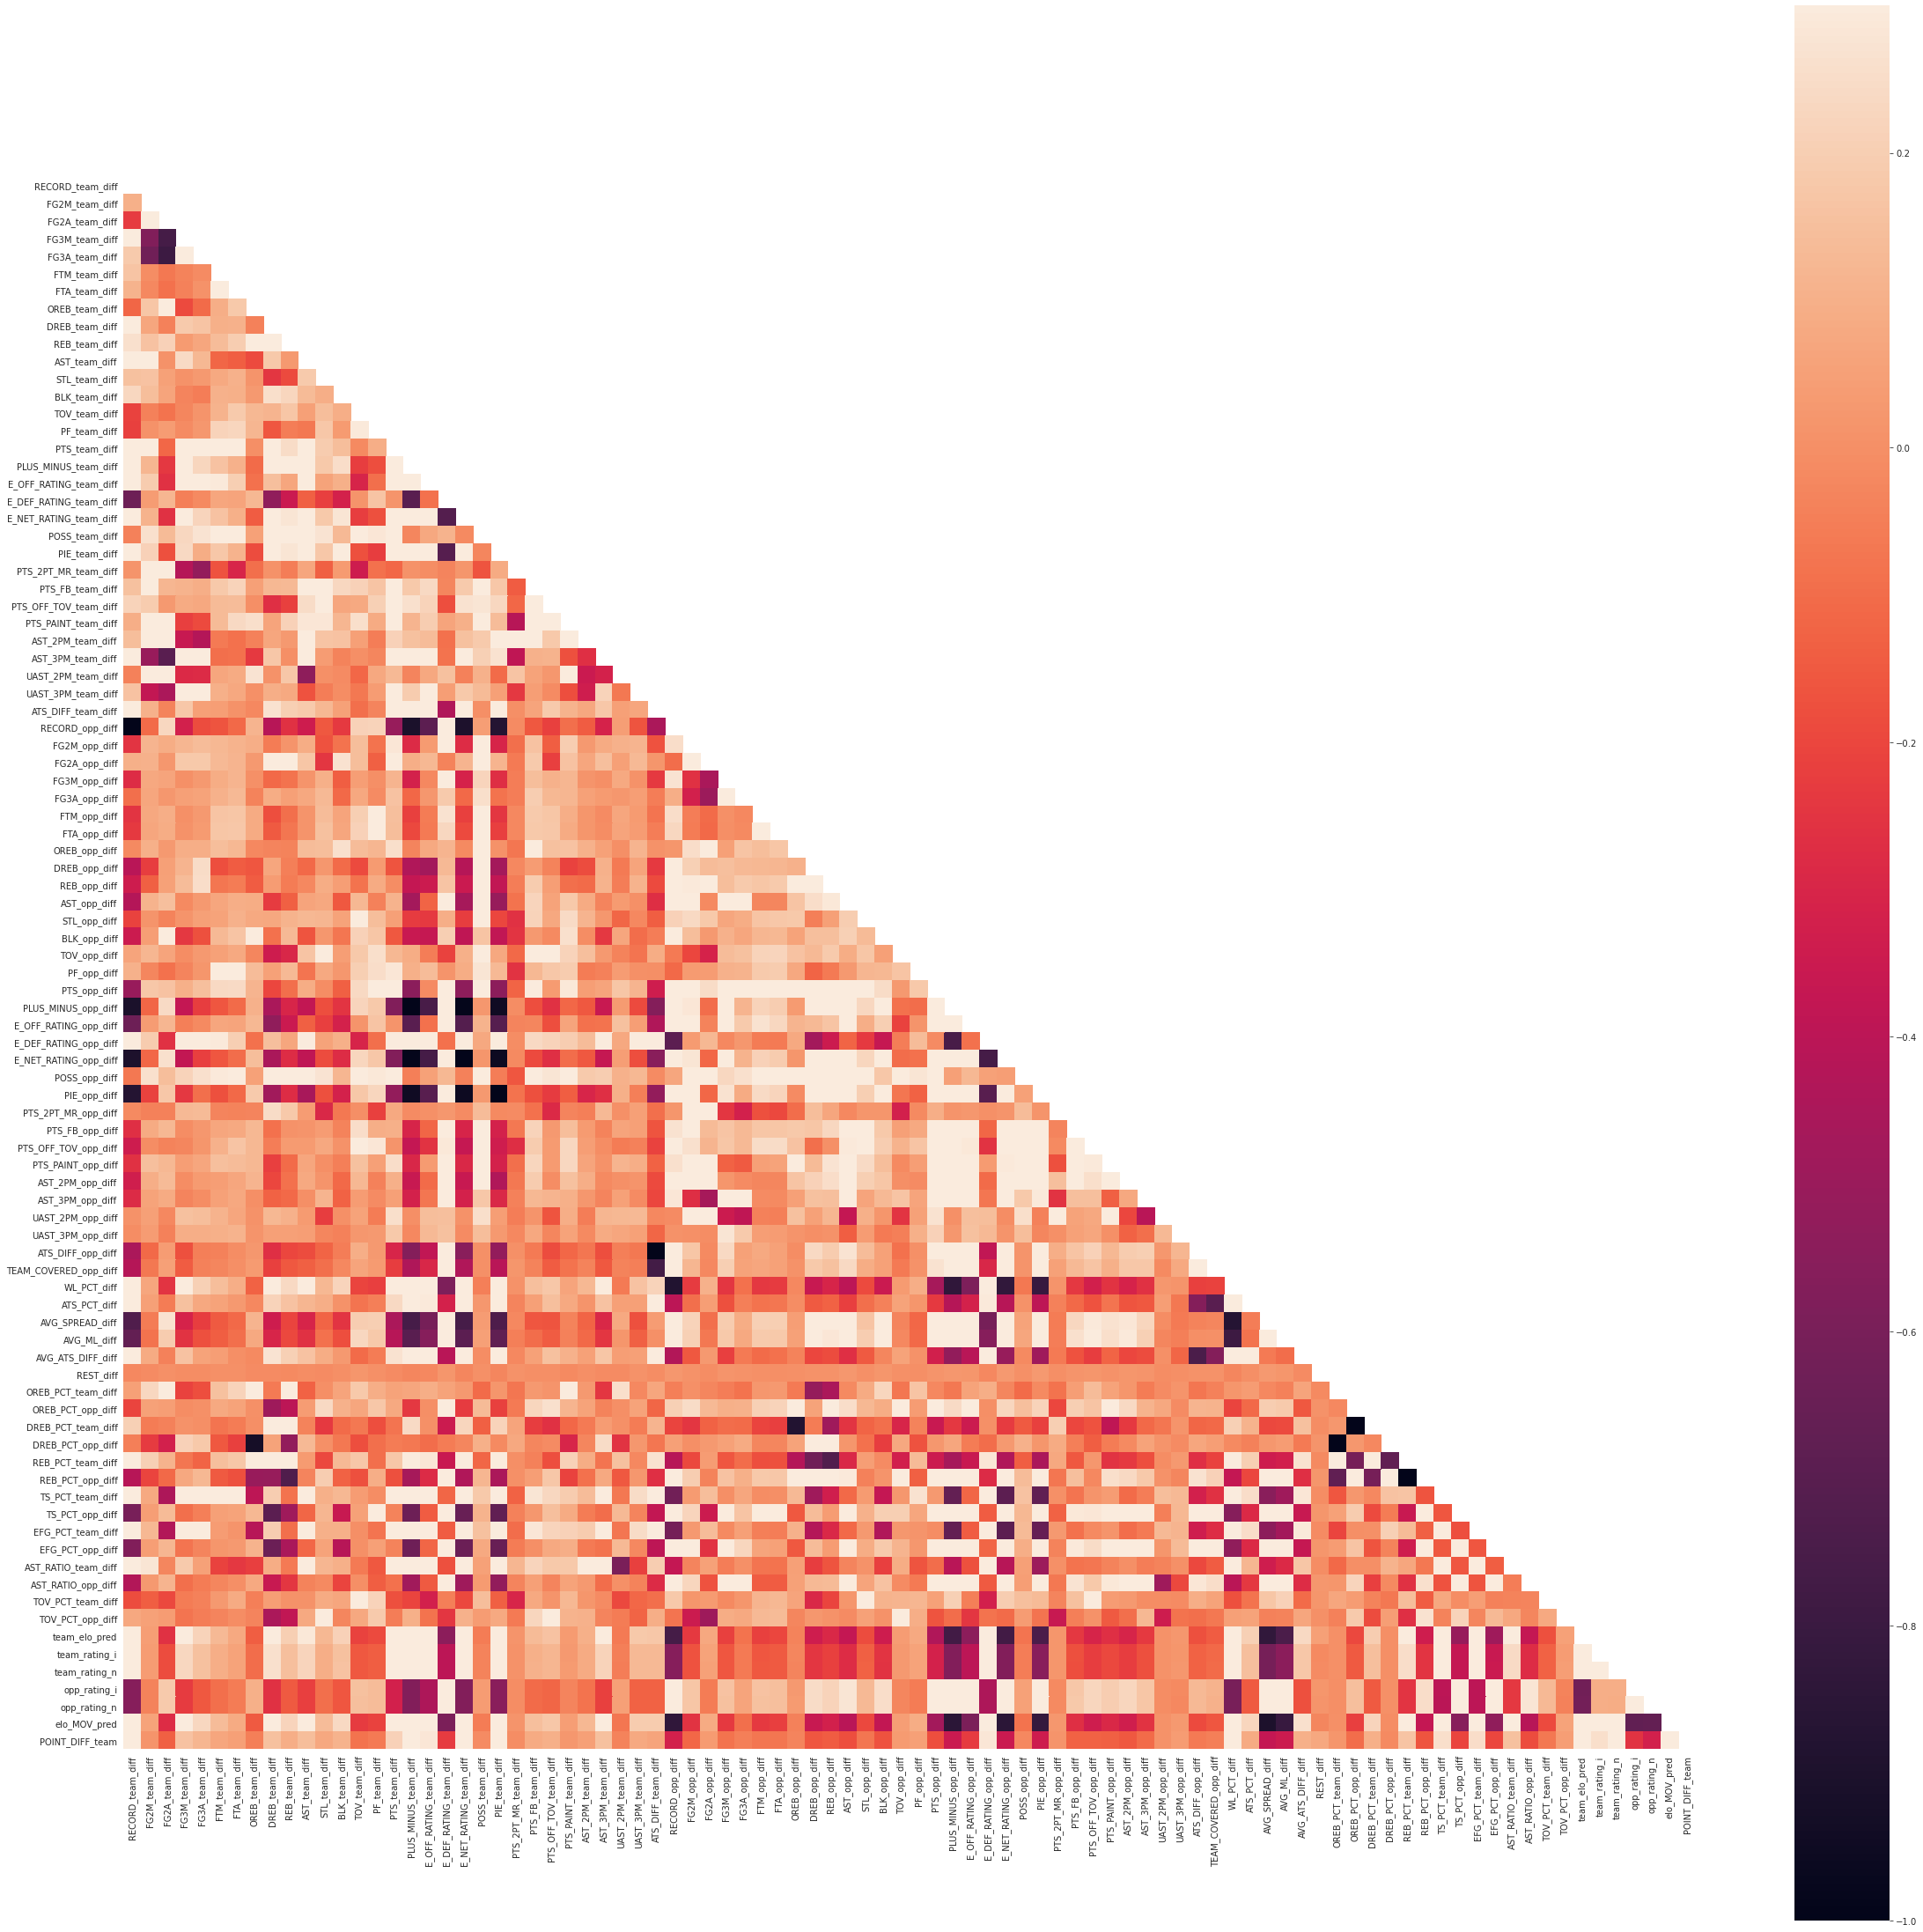

In [39]:
import seaborn as sns
corr = pd.concat([test.iloc[:, 14:], test['POINT_DIFF_team']], axis=1).corr()

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(40, 40))
    ax = sns.heatmap(corr, mask=mask, vmax=0.3, square=True)
    
    

In [40]:
columns = []
point_biserial_correlations = []
p_values = []

for col in test.columns[14:]:
    cont = test[col]
    cover = test['TEAM_COVERED_team']
    pbc = pointbiserialr(cont, cover)
    columns.append(col)
    point_biserial_correlations.append(pbc[0])
    p_values.append(pbc[1])
    
pbc_df = pd.DataFrame({'feature':columns, 
              'pbc':point_biserial_correlations, 
              'p_value':p_values})



In [41]:
columns = []
point_biserial_correlations = []
p_values = []

for col in test.columns[14:]:
    cont = test[col]
    cover = test['WL_team']
    pbc = pointbiserialr(cont, cover)
    columns.append(col)
    point_biserial_correlations.append(pbc[0])
    p_values.append(pbc[1])
    
pbc_df = pd.DataFrame({'feature':columns, 
              'pbc':point_biserial_correlations, 
              'p_value':p_values})

pbc_df.sort_values('pbc', ascending=False)


feature       pbc        p_value
83           team_elo_pred  0.380479   0.000000e+00
88            elo_MOV_pred  0.338563   0.000000e+00
63             WL_PCT_diff  0.314284   0.000000e+00
19  E_NET_RATING_team_diff  0.306509   0.000000e+00
16    PLUS_MINUS_team_diff  0.305960   0.000000e+00
21           PIE_team_diff  0.298982   0.000000e+00
85           team_rating_n  0.295326   0.000000e+00
0         RECORD_team_diff  0.287916   0.000000e+00
17  E_OFF_RATING_team_diff  0.245839   0.000000e+00
49   E_DEF_RATING_opp_diff  0.245839   0.000000e+00
84           team_rating_i  0.227628   0.000000e+00
75        TS_PCT_team_diff  0.224504   0.000000e+00
77       EFG_PCT_team_diff  0.220812   0.000000e+00
15           PTS_team_diff  0.175392  1.555253e-213
73       REB_PCT_team_diff  0.144187  2.986729e-144
79     AST_RATIO_team_diff  0.137593  2.041053e-131
3           FG3M_team_diff  0.130681  1.252324e-118
27       AST_3PM_team_diff  0.130591  1.815234e-118
8           DREB_team_diff  0.126748  1.172335e-111
10           AST_team_diff  0.124283  2.130691e-107
4           FG3A_team_diff  0.093523   1.976037e-61
12           BLK_team_diff  0.091707   3.958783e-59
71      DREB_PCT_team_diff  0.086658   5.734814e-53
24   PTS_OFF_TOV_team_diff  0.082685   2.290882e-48
67       AVG_ATS_DIFF_diff  0.079667   5.136778e-45
64            ATS_PCT_diff  0.074584   1.175904e-39
9            REB_team_diff  0.073699   9.297453e-39
11           STL_team_diff  0.070263   2.235433e-35
23        PTS_FB_team_diff  0.064613   3.635664e-30
68               REST_diff  0.057839   1.723945e-24
29      UAST_3PM_team_diff  0.057027   7.503840e-24
5            FTM_team_diff  0.055399   1.343798e-22
30      ATS_DIFF_team_diff  0.054398   7.612572e-22
26       AST_2PM_team_diff  0.042504   6.250546e-14
82        TOV_PCT_opp_diff  0.040117   1.430689e-12
45             PF_opp_diff  0.038081   1.800954e-11
6            FTA_team_diff  0.035046   6.196461e-10
60       UAST_3PM_opp_diff  0.034720   8.907640e-10
44            TOV_opp_diff  0.030530   7.125467e-08
33           FG2A_opp_diff  0.018117   1.389554e-03
25     PTS_PAINT_team_diff  0.016271   4.091299e-03
1           FG2M_team_diff  0.014021   1.335904e-02
69      OREB_PCT_team_diff  0.013850   1.453675e-02
53     PTS_2PT_MR_opp_diff  0.004915   3.858345e-01
22    PTS_2PT_MR_team_diff -0.002541   6.539666e-01
59       UAST_2PM_opp_diff -0.002985   5.984183e-01
72       DREB_PCT_opp_diff -0.013850   1.453675e-02
20          POSS_team_diff -0.025103   9.429196e-06
38           OREB_opp_diff -0.031513   2.676211e-08
28      UAST_2PM_team_diff -0.033206   4.618476e-09
51           POSS_opp_diff -0.034217   1.550406e-09
62   TEAM_COVERED_opp_diff -0.043173   2.519479e-14
35           FG3A_opp_diff -0.043670   1.271507e-14
7           OREB_team_diff -0.047166   8.330616e-17
61       ATS_DIFF_opp_diff -0.054398   7.612572e-22
14            PF_team_diff -0.057589   2.715243e-24
81       TOV_PCT_team_diff -0.058542   4.748322e-25
42            STL_opp_diff -0.064043   1.154098e-29
37            FTA_opp_diff -0.065933   2.409025e-31
36            FTM_opp_diff -0.069430   1.398089e-34
34           FG3M_opp_diff -0.070463   1.435703e-35
13           TOV_team_diff -0.072838   6.768105e-38
58        AST_3PM_opp_diff -0.086237   1.808398e-52
70       OREB_PCT_opp_diff -0.086658   5.734814e-53
32           FG2M_opp_diff -0.108285   7.682931e-82
55    PTS_OFF_TOV_opp_diff -0.110024   1.912513e-84
54         PTS_FB_opp_diff -0.114145   8.750915e-91
2           FG2A_team_diff -0.114423   3.202099e-91
56      PTS_PAINT_opp_diff -0.120683  2.476077e-101
57        AST_2PM_opp_diff -0.135546  1.468466e-127
40            REB_opp_diff -0.137451  3.796641e-131
74        REB_PCT_opp_diff -0.144187  2.986729e-144
39           DREB_opp_diff -0.148800  1.331105e-153
43            BLK_opp_diff -0.156072  5.749382e-169
80      AST_RATIO_opp_diff -0.156200  3.030734e-169
41            AST_opp_diff -0.156502  6.704056e-170
46            P

In [42]:
pbc_df.sort_values(['pbc'])

feature       pbc        p_value
65         AVG_SPREAD_diff -0.331320   0.000000e+00
50   E_NET_RATING_opp_diff -0.306509   0.000000e+00
47     PLUS_MINUS_opp_diff -0.305960   0.000000e+00
66             AVG_ML_diff -0.303828   0.000000e+00
52            PIE_opp_diff -0.298983   0.000000e+00
87            opp_rating_n -0.295201   0.000000e+00
31         RECORD_opp_diff -0.287916   0.000000e+00
86            opp_rating_i -0.227490   0.000000e+00
48   E_OFF_RATING_opp_diff -0.204688  1.031132e-291
18  E_DEF_RATING_team_diff -0.204688  1.031132e-291
76         TS_PCT_opp_diff -0.178290  1.075952e-220
78        EFG_PCT_opp_diff -0.175257  3.329248e-213
46            PTS_opp_diff -0.167303  3.290286e-194
41            AST_opp_diff -0.156502  6.704056e-170
80      AST_RATIO_opp_diff -0.156200  3.030734e-169
43            BLK_opp_diff -0.156072  5.749382e-169
39           DREB_opp_diff -0.148800  1.331105e-153
74        REB_PCT_opp_diff -0.144187  2.986729e-144
40            REB_opp_diff -0.137451  3.796641e-131
57        AST_2PM_opp_diff -0.135546  1.468466e-127
56      PTS_PAINT_opp_diff -0.120683  2.476077e-101
2           FG2A_team_diff -0.114423   3.202099e-91
54         PTS_FB_opp_diff -0.114145   8.750915e-91
55    PTS_OFF_TOV_opp_diff -0.110024   1.912513e-84
32           FG2M_opp_diff -0.108285   7.682931e-82
70       OREB_PCT_opp_diff -0.086658   5.734814e-53
58        AST_3PM_opp_diff -0.086237   1.808398e-52
13           TOV_team_diff -0.072838   6.768105e-38
34           FG3M_opp_diff -0.070463   1.435703e-35
36            FTM_opp_diff -0.069430   1.398089e-34
37            FTA_opp_diff -0.065933   2.409025e-31
42            STL_opp_diff -0.064043   1.154098e-29
81       TOV_PCT_team_diff -0.058542   4.748322e-25
14            PF_team_diff -0.057589   2.715243e-24
61       ATS_DIFF_opp_diff -0.054398   7.612572e-22
7           OREB_team_diff -0.047166   8.330616e-17
35           FG3A_opp_diff -0.043670   1.271507e-14
62   TEAM_COVERED_opp_diff -0.043173   2.519479e-14
51           POSS_opp_diff -0.034217   1.550406e-09
28      UAST_2PM_team_diff -0.033206   4.618476e-09
38           OREB_opp_diff -0.031513   2.676211e-08
20          POSS_team_diff -0.025103   9.429196e-06
72       DREB_PCT_opp_diff -0.013850   1.453675e-02
59       UAST_2PM_opp_diff -0.002985   5.984183e-01
22    PTS_2PT_MR_team_diff -0.002541   6.539666e-01
53     PTS_2PT_MR_opp_diff  0.004915   3.858345e-01
69      OREB_PCT_team_diff  0.013850   1.453675e-02
1           FG2M_team_diff  0.014021   1.335904e-02
25     PTS_PAINT_team_diff  0.016271   4.091299e-03
33           FG2A_opp_diff  0.018117   1.389554e-03
44            TOV_opp_diff  0.030530   7.125467e-08
60       UAST_3PM_opp_diff  0.034720   8.907640e-10
6            FTA_team_diff  0.035046   6.196461e-10
45             PF_opp_diff  0.038081   1.800954e-11
82        TOV_PCT_opp_diff  0.040117   1.430689e-12
26       AST_2PM_team_diff  0.042504   6.250546e-14
30      ATS_DIFF_team_diff  0.054398   7.612572e-22
5            FTM_team_diff  0.055399   1.343798e-22
29      UAST_3PM_team_diff  0.057027   7.503840e-24
68               REST_diff  0.057839   1.723945e-24
23        PTS_FB_team_diff  0.064613   3.635664e-30
11           STL_team_diff  0.070263   2.235433e-35
9            REB_team_diff  0.073699   9.297453e-39
64            ATS_PCT_diff  0.074584   1.175904e-39
67       AVG_ATS_DIFF_diff  0.079667   5.136778e-45
24   PTS_OFF_TOV_team_diff  0.082685   2.290882e-48
71      DREB_PCT_team_diff  0.086658   5.734814e-53
12           BLK_team_diff  0.091707   3.958783e-59
4           FG3A_team_diff  0.093523   1.976037e-61
10           AST_team_diff  0.124283  2.130691e-107
8           DREB_team_diff  0.126748  1.172335e-111
27       AST_3PM_team_diff  0.130591  1.815234e-118
3           FG3M_team_diff  0.130681  1.252324e-118
79     AST_RATIO_team_diff  0.137593  2.041053e-131
73       REB_PCT_team_diff  0.144187  2.986729e-144
15           PTS_team_diff  0.175392  1.555253e-213
77       EFG_PC

In [43]:
home_games = test.loc[test['HOME_GAME'] == 1]
away_games = test.loc[test['HOME_GAME'] == 0]

home_cover_year = home_games.groupby('SEASON').TEAM_COVERED_team.mean().reset_index()
home_cover_year

SEASON  TEAM_COVERED_team
0   2006-07           0.478333
1   2007-08           0.509852
2   2008-09           0.484958
3   2009-10           0.498918
4   2010-11           0.491043
5   2011-12           0.492988
6   2012-13           0.498347
7   2013-14           0.476510
8   2014-15           0.485786
9   2015-16           0.524400
10  2016-17           0.499172
11  2017-18           0.482931
12  2018-19           0.505776
13  2019-20           0.492726
14  2020-21           0.494836

In [44]:
home_games = test.loc[test['HOME_GAME'] == 1]
away_games = test.loc[test['HOME_GAME'] == 0]

home_cover_year = home_games.groupby('SEASON').TEAM_COVERED_team.mean().reset_index()

px.line(home_cover_year, x='SEASON', y='TEAM_COVERED_team')

## Helper Functions for Bet Simulations

In [45]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 5
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [46]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    df:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    confidence_thresholds: df of thresholds, num_games_bet, win_percentage, expected_profits
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values(['expected_profit', 'num_games_bet'], ascending=[False, False], inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [47]:
# # Find ranges of model probability where the win percentage is higher than 52.8
# def find_optimal_confidence_thresholds(df, diff_preds, test_indices):
#     """
#     INPUTS:
#     test_preds: array of class predictions
#     test_indices: indices of full df for the test set 
#     OUTPUTS:
#     select_bets: df of bets at the optimal thresholds
#     best_thresholds: tuple of lower and upper thresholds
    
#     """
#     betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
#                                                  'spread_team_x', 'ml_team_x', 'SCORE_team_x', 
#                                                  'point_diff_team_x']]
#     betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
#                                'HOME_GAME_x':'HOME_GAME',
#                                'spread_team_x':'spread', 
#                               'ml_team_x':'ml', 
#                               'SCORE_team_x':'team_score', 
#                               'point_diff_team_x':'point_diff'}, inplace=True)


#     betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

#     betting_df['diff_preds'] = diff_preds

#     home_df = betting_df.loc[betting_df['HOME_GAME']==1]
#     away_df = betting_df.loc[betting_df['HOME_GAME']==0]

#     betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

#     betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
#                                  'ml_home', 'ml_away', 'point_diff_home', 
#                                  'cover_home', 'diff_preds_home', 
#                              'diff_preds_away']]

#     betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

#     betting_df['bet_home1'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home2'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home3'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) >0).astype(int)

#     betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

#     betting_df['confidence_pred1'] = betting_df['diff_preds_home'] + betting_df['spread_home']
#     betting_df['confidence_pred2'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
#     betting_df['confidence_pred3'] = betting_df['point_diff_avg'] + betting_df['spread_home']


#     betting_df['bankroll_i'] = np.nan
#     betting_df['bankroll_n'] = np.nan
#     betting_df['bankroll_i'].iloc[0] = 10000
#     betting_df['bet_size'] = np.nan
        
#     prediction_num = []
#     confidence_threshold = []
#     win_percentages = []
#     num_games_bet = []
#     expected_profits = []
    
#     for num in range(1, 4):
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)

#         for i in range(1, 1001):
#             select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(num)]) > i/100]
#             win_pct = select_bets['bet_won'].mean()
#             num_games = select_bets.shape[0]
#             confidence_threshold.append(i/100)
#             win_percentages.append(win_pct)
#             num_games_bet.append(num_games)
#             bets_won = select_bets['bet_won'].sum()
#             bets_lost = num_games - bets_won
#             expected_profit = (bets_won*100 + bets_lost*-108)
#             expected_profits.append(expected_profit)
#             prediction_num.append(num)
        

#     confidence_thresholds = pd.DataFrame({'prediction_num':prediction_num,
#                                         'confidence_thresholds':confidence_threshold, 
#                                        'num_games_bet':num_games_bet, 
#                                        'win_percentage':win_percentages,
#                                          'expected_profits':expected_profits})
    
#     confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
#     confidence_thresholds.sort_values(['expected_profits', 'confidence_thresholds'], 
#                                       ascending=[False, True], inplace=True)
#     confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
#     print('DONE')

#     try:
#         best_threshold = confidence_thresholds.loc[0, 'confidence_thresholds']
#         print("best threshold:", best_threshold)
#         best_num = confidence_thresholds.loc[0, 'prediction_num']
#         print("best prediction strat:", best_num)
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(best_num)] == betting_df['cover_home']).astype(int)
#         select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(best_num)]) > best_threshold]
#         print("num_games_bet:", select_bets.shape[0])
#         print("win percetange at threshold:", select_bets['bet_won'].mean())
#     except:
#         print("no best threshold")
#         select_bets = betting_df
   
    
#     return select_bets, confidence_thresholds
    

In [88]:
def create_betting_df(df, probs, test_indices):
    df=df.copy(deep=True)
    
    df = df.rename(columns= {'SPREAD_team':'SPREAD', 
                      'SCORE_team':'SCORE', 
                      'POINT_DIFF_team':'POINT_DIFF',
                        'TEAM_COVERED_team':'cover'})
    
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'SPREAD', 'SCORE', 
                                                 'POINT_DIFF', 'cover']]

    betting_df['prob'] = probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'SPREAD_home',
                             'SCORE_home', 'SCORE_away', 'POINT_DIFF_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + (1-betting_df['prob_away']))/2

    betting_df['bet_home'] = (betting_df['prob_avg'] > 0.5).astype(int)
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['SPREAD_home'] + betting_df['POINT_DIFF_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [89]:
y_probs = best_lr.predict_proba(X_test)

create_betting_df(df_ewm_19_diffs, y_probs, test_idx)

# df_ewm_19_diffs

GAME_ID MATCHUP_home  SPREAD_home  SCORE_home  SCORE_away  \
0     0021600075  NOP vs. PHX         -3.0         111         112   
1     0021600077  UTA vs. SAS          4.5          86         100   
2     0021600078  LAL vs. GSW         12.5         117          97   
3     0021600083  IND vs. CHI         -3.5         111          94   
4     0021600085  MIL vs. SAC         -3.5         117          91   
...          ...          ...          ...         ...         ...   
5712  0042000402  PHX vs. MIL         -4.5         118         108   
5713  0042000403  MIL vs. PHX         -5.0         120         100   
5714  0042000404  MIL vs. PHX         -5.0         109         103   
5715  0042000405  PHX vs. MIL         -4.5         119         123   
5716  0042000406  MIL vs. PHX         -4.5         105          98   

      POINT_DIFF_home  cover_home  prob_home  prob_away  prob_avg  bet_home  \
0                  -1           0   0.491727   0.508249  0.491739         0   
1                 -14           0   0.488317   0.512070  0.488123         0   
2                  20           1   0.492923   0.507297  0.492813         0   
3                  17           1   0.498142   0.502012  0.498065         0   
4                  26           1   0.564313   0.435754  0.564280         1   
...               ...         ...        ...        ...       ...       ...   
5712               10           1   0.432591   0.567888  0.432351         0   
5713               20           1   0.587251   0.413221  0.587015         1   
5714                6           1   0.593315   0.407155  0.593080         1   
5715               -4           0   0.364667   0.635785  0.364441         0   
5716                7           1   0.612039   0.388423  0.611808         1   

      bet_won  bankroll_i  bankroll_n  bet_size  
0           1       100.0         NaN       NaN  
1           1         NaN         NaN       NaN  
2           0         NaN         NaN       NaN  
3           0         NaN         NaN       NaN  
4           1         NaN         NaN       NaN  
...       ...         ...         ...       ...  
5712        0         NaN         NaN       NaN  
5713        1         NaN         NaN       NaN  
5714        1         NaN         NaN       NaN  
5715        1         NaN         NaN       NaN  
5716        1         NaN         NaN       NaN  

[5717 rows x 15 columns]

In [49]:
def test_model_per_season(df, model, test_seasons_idxs):
    df = df.copy(deep=True)
    
    X = df.iloc[:, 12:]
    X = X.drop(columns=['team_rating_n_x', 'opp_rating_n_x', 'WL_team_y'])
    
    y = (df['point_diff_team_x'] + df['spread_team_x']).astype(int)
    
    result_dfs = []
    print(len(test_season_idxs))
    for i in range(len(test_seasons_idxs)-1):
        print("loop:", i)
        X_train1 = X.loc[:test_seasons_idxs[i][0]-1]
        X_test1 = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        y_train1 = y.loc[:test_seasons_idxs[i][0]-1]
        y_test1 = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        
        X_train2 = X.loc[:test_seasons_idxs[i+1][0]-1]
        X_test2 = X.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]
        y_train2 = y.loc[:test_seasons_idxs[i+1][0]-1]
        y_test2 = y.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]        

        model.fit(X_train1, y_train1)
        probs1 = model.predict_proba(X_test1)
        
        select_bets, confidence_thresholds = find_optimal_threshold(df, probs1, test_seasons_idxs[i])
        
        try:
            best_strat = confidence_thresholds.loc[0, 'strategy']
            best_threshold = confidence_thresholds.loc[0, 'confidence_range'] 
            print("best_strat:", best_strat, "best_threshold:", best_threshold)
            
        except:
            best_strat = 3
            best_threshold = 0.5
            print("no best strategy/threshold for season", select_bets.loc[0, 'SEASON_YEAR_x'])
        
        model.fit(X_train2, y_train2)
        probs2 = model.predict_proba(X_test2)
        
        
        bets = create_betting_df(df, probs2, test_season_idxs[i+1], 3)
        select_bets = bets.loc[~bets['prob_avg'].between(1-best_threshold, best_threshold)]
        print('season ', df.loc[test_season_idxs[i+1][0], 'SEASON_YEAR_x'])
        simulate_bets(select_bets)
        
        result_dfs.append(select_bets)
        
    return result_dfs

In [50]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION            TEAM_NAME     GAME_ID  \
0      2000-01  1610612755               PHI   Philadelphia 76ers  0020000001   
1      2000-01  1610612752               NYK      New York Knicks  0020000001   
2      2000-01  1610612739               CLE  Cleveland Cavaliers  0020000002   
3      2000-01  1610612751               BKN      New Jersey Nets  0020000002   
4      2000-01  1610612764               WAS   Washington Wizards  0020000003   
...        ...         ...               ...                  ...         ...   
53669  2020-21  1610612749               MIL      Milwaukee Bucks  0042000404   
53670  2020-21  1610612749               MIL      Milwaukee Bucks  0042000405   
53671  2020-21  1610612756               PHX         Phoenix Suns  0042000405   
53672  2020-21  1610612756               PHX         Phoenix Suns  0042000406   
53673  2020-21  1610612749               MIL      Milwaukee Bucks  0042000406   

       GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  POINT_DIFF_team  \
0     2000-10-31    PHI @ NYK          0         101               29   
1     2000-10-31  NYK vs. PHI          1          72              -29   
2     2000-10-31    CLE @ BKN          0          86                4   
3     2000-10-31  BKN vs. CLE          1          82               -4   
4     2000-10-31    WAS @ ORL          0          86              -11   
...          ...          ...        ...         ...              ...   
53669 2021-07-14  MIL vs. PHX          1         109                6   
53670 2021-07-17    MIL @ PHX          0         123                4   
53671 2021-07-17  PHX vs. MIL          1         119               -4   
53672 2021-07-20    PHX @ MIL          0          98               -7   
53673 2021-07-20  MIL vs. PHX          1         105                7   

       WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  RECORD_team_diff  \
0            1       NaN          NaN                  0               NaN   
1            0       NaN          NaN                  0               NaN   
2            1       NaN          NaN                  0               NaN   
3            0       NaN          NaN                  0               NaN   
4            0       NaN          NaN                  0               NaN   
...        ...       ...          ...                ...               ...   
53669        1  1.487805         -5.0                  1         -0.094598   
53670        1  2.600000          4.5                  1          0.014868   
53671        0  1.540541         -4.5                  0         -0.014868   
53672        0  2.650000          4.5                  0         -0.113386   
53673        1  1.526316         -4.5                  1          0.113386   

       FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN             NaN   
...               ...             ...             ...             ...   
53669        0.674764        0.181271        0.143275        4.353561   
53670        0.507277        1.463215        0.128950        4.518219   
53671       -0.507277       -1.463215       -0.128950       -4.518219   
53672       -0.556549       -0.416834       -0.216059       -4.966426   
53673        0.556549        0.416834        0.216059        4.966426   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0                NaN            NaN             NaN             NaN   
1                NaN            NaN             NaN             NaN   
2                NaN            NaN             NaN             NaN   
3                NaN            NaN             NaN         

## Create Features Sets

### Features EWM

In [51]:
home_games = df_ewm_19_diffs.loc[df_ewm_19_diffs['HOME_GAME'] == 1]

home_games

SEASON     TEAM_ID TEAM_ABBREVIATION        TEAM_NAME     GAME_ID  \
1      2000-01  1610612752               NYK  New York Knicks  0020000001   
3      2000-01  1610612751               BKN  New Jersey Nets  0020000002   
5      2000-01  1610612753               ORL    Orlando Magic  0020000003   
7      2000-01  1610612737               ATL    Atlanta Hawks  0020000004   
9      2000-01  1610612761               TOR  Toronto Raptors  0020000005   
...        ...         ...               ...              ...         ...   
53665  2020-21  1610612756               PHX     Phoenix Suns  0042000402   
53667  2020-21  1610612749               MIL  Milwaukee Bucks  0042000403   
53669  2020-21  1610612749               MIL  Milwaukee Bucks  0042000404   
53671  2020-21  1610612756               PHX     Phoenix Suns  0042000405   
53673  2020-21  1610612749               MIL  Milwaukee Bucks  0042000406   

       GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  POINT_DIFF_team  \
1     2000-10-31  NYK vs. PHI          1          72              -29   
3     2000-10-31  BKN vs. CLE          1          82               -4   
5     2000-10-31  ORL vs. WAS          1          97               11   
7     2000-10-31  ATL vs. CHA          1          82              -24   
9     2000-10-31  TOR vs. DET          1          95               -9   
...          ...          ...        ...         ...              ...   
53665 2021-07-08  PHX vs. MIL          1         118               10   
53667 2021-07-11  MIL vs. PHX          1         120               20   
53669 2021-07-14  MIL vs. PHX          1         109                6   
53671 2021-07-17  PHX vs. MIL          1         119               -4   
53673 2021-07-20  MIL vs. PHX          1         105                7   

       WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  RECORD_team_diff  \
1            0       NaN          NaN                  0               NaN   
3            0       NaN          NaN                  0               NaN   
5            1       NaN          NaN                  0               NaN   
7            0       NaN          NaN                  0               NaN   
9            0       NaN          NaN                  0               NaN   
...        ...       ...          ...                ...               ...   
53665        1  1.476190         -4.5                  1          0.129137   
53667        1  1.487805         -5.0                  1         -0.216229   
53669        1  1.487805         -5.0                  1         -0.094598   
53671        0  1.540541         -4.5                  0         -0.014868   
53673        1  1.526316         -4.5                  1          0.113386   

       FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
1                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
5                 NaN             NaN             NaN             NaN   
7                 NaN             NaN             NaN             NaN   
9                 NaN             NaN             NaN             NaN   
...               ...             ...             ...             ...   
53665        0.031214        1.578822       -0.781875       -5.757597   
53667        0.971982       -0.020827       -0.396400        4.281729   
53669        0.674764        0.181271        0.143275        4.353561   
53671       -0.507277       -1.463215       -0.128950       -4.518219   
53673        0.556549        0.416834        0.216059        4.966426   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
1                NaN            NaN             NaN             NaN   
3                NaN            NaN             NaN             NaN   
5                NaN            NaN             NaN             NaN   
7                NaN            NaN             NaN             NaN   
9                NaN            NaN  

In [52]:
cutoff_16 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2015-16'].index[-1]
cutoff_17 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2016-17'].index[-1]
cutoff_18 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2017-18'].index[-1]
cutoff_19 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2018-19'].index[-1]
cutoff_20 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2019-20'].index[-1]
cutoff_21 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2020-21'].index[-1]

In [55]:
clean_mls.loc[clean_mls['HIGHEST_HOME_ML'].notnull(), 'SEASON'].value_counts().sort_index()

2006-07     673
2007-08     980
2008-09     944
2009-10    1026
2010-11    1060
2011-12    1074
2012-13    1313
2013-14    1315
2014-15    1307
2015-16    1315
2016-17    1309
2017-18    1312
2018-19    1312
2019-20    1140
2020-21    1165
Name: SEASON, dtype: int64

In [56]:
clean_spreads.loc[~clean_spreads['HIGHEST_HOME_SPREAD'].isnull(), 'SEASON'].value_counts().sort_index()

2006-07    1149
2007-08    1122
2008-09    1248
2009-10    1274
2010-11    1252
2011-12    1025
2012-13    1308
2013-14    1297
2014-15    1309
2015-16    1308
2016-17    1303
2017-18    1312
2018-19    1311
2019-20    1132
2020-21    1165
Name: SEASON, dtype: int64

In [58]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION            TEAM_NAME     GAME_ID  \
0      2000-01  1610612755               PHI   Philadelphia 76ers  0020000001   
1      2000-01  1610612752               NYK      New York Knicks  0020000001   
2      2000-01  1610612739               CLE  Cleveland Cavaliers  0020000002   
3      2000-01  1610612751               BKN      New Jersey Nets  0020000002   
4      2000-01  1610612764               WAS   Washington Wizards  0020000003   
...        ...         ...               ...                  ...         ...   
53669  2020-21  1610612749               MIL      Milwaukee Bucks  0042000404   
53670  2020-21  1610612749               MIL      Milwaukee Bucks  0042000405   
53671  2020-21  1610612756               PHX         Phoenix Suns  0042000405   
53672  2020-21  1610612756               PHX         Phoenix Suns  0042000406   
53673  2020-21  1610612749               MIL      Milwaukee Bucks  0042000406   

       GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  POINT_DIFF_team  \
0     2000-10-31    PHI @ NYK          0         101               29   
1     2000-10-31  NYK vs. PHI          1          72              -29   
2     2000-10-31    CLE @ BKN          0          86                4   
3     2000-10-31  BKN vs. CLE          1          82               -4   
4     2000-10-31    WAS @ ORL          0          86              -11   
...          ...          ...        ...         ...              ...   
53669 2021-07-14  MIL vs. PHX          1         109                6   
53670 2021-07-17    MIL @ PHX          0         123                4   
53671 2021-07-17  PHX vs. MIL          1         119               -4   
53672 2021-07-20    PHX @ MIL          0          98               -7   
53673 2021-07-20  MIL vs. PHX          1         105                7   

       WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  RECORD_team_diff  \
0            1       NaN          NaN                  0               NaN   
1            0       NaN          NaN                  0               NaN   
2            1       NaN          NaN                  0               NaN   
3            0       NaN          NaN                  0               NaN   
4            0       NaN          NaN                  0               NaN   
...        ...       ...          ...                ...               ...   
53669        1  1.487805         -5.0                  1         -0.094598   
53670        1  2.600000          4.5                  1          0.014868   
53671        0  1.540541         -4.5                  0         -0.014868   
53672        0  2.650000          4.5                  0         -0.113386   
53673        1  1.526316         -4.5                  1          0.113386   

       FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN             NaN   
...               ...             ...             ...             ...   
53669        0.674764        0.181271        0.143275        4.353561   
53670        0.507277        1.463215        0.128950        4.518219   
53671       -0.507277       -1.463215       -0.128950       -4.518219   
53672       -0.556549       -0.416834       -0.216059       -4.966426   
53673        0.556549        0.416834        0.216059        4.966426   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0                NaN            NaN             NaN             NaN   
1                NaN            NaN             NaN             NaN   
2                NaN            NaN             NaN             NaN   
3                NaN            NaN             NaN         

In [59]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.loc[df['POINT_DIFF_team'] + df['SPREAD_team'] != 0]

    df = df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'])
    df = df.dropna()

    features = df.iloc[:, 14:]
    features['SPREAD'] = df['SPREAD_team']
    features = features.drop(
        columns=['team_rating_n', 'opp_rating_n'])

    y = df['TEAM_COVERED_team']

    X_train = features.loc[:cutoff]
    X_test = features.loc[cutoff+1:]

    y_train = y.loc[:cutoff]
    y_test = y.loc[cutoff+1:]

    train_idx = X_train.index
    test_idx = X_test.index

#     X_train = X_train.astype(float)
#     X_test = X_test.astype(float)

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [60]:
X_train, X_test, y_train, y_test, train_idx, test_idx = split_prep_data(df_ewm_19_diffs, cutoff_16)


In [61]:
print(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))

X_train

0.6327369672052163


RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15568          0.152738       -1.954923       -5.820057        1.362323   
15569         -0.152738        1.954923        5.820057       -1.362323   
15576         -0.017287       -0.248831        5.853269       -1.502618   
15577          0.017287        0.248831       -5.853269        1.502618   
15588         -0.442910        0.310867        2.912442        2.059230   
...                 ...             ...             ...             ...   
41189          0.143834       -0.786681       -0.582086        1.593153   
41190          0.029448       -2.308044       -1.923904        1.833843   
41191         -0.029448        2.308044        1.923904       -1.833843   
41192          0.073498        3.277257        2.431520       -2.150465   
41193         -0.073498       -3.277257       -2.431520        2.150465   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15568       -1.428139       2.701524       9.112958        0.676793   
15569        1.428139      -2.701524      -9.112958       -0.676793   
15576       -5.116500      -0.741806      -4.067155        2.524098   
15577        5.116500       0.741806       4.067155       -2.524098   
15588        3.786198      -4.815621      -7.069610        1.276218   
...               ...            ...            ...             ...   
41189        3.217412       0.922036       0.587392       -0.807284   
41190        4.795702       1.329841       0.828656       -0.226543   
41191       -4.795702      -1.329841      -0.828656        0.226543   
41192       -5.516144      -0.696841      -0.445778        0.103885   
41193        5.516144       0.696841       0.445778       -0.103885   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
15568       -0.954472      -0.277679      -3.270133       0.412463   
15569        0.954472       0.277679       3.270133      -0.412463   
15576        4.860218       7.384317      -1.130916      -0.828619   
15577       -4.860218      -7.384317       1.130916       0.828619   
15588       -2.217901      -0.941683       1.076968      -0.047447   
...               ...            ...            ...            ...   
41189        0.755402      -0.051882       3.479550       0.447166   
41190        0.379854       0.153312       3.431598      -0.097563   
41191       -0.379854      -0.153312      -3.431598       0.097563   
41192        0.758152       0.862037      -2.588423       0.787820   
41193       -0.758152      -0.862037       2.588423      -0.787820   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
15568       0.971038       3.102747      2.496974       2.878648   
15569      -0.971038      -3.102747     -2.496974      -2.878648   
15576       0.143984      -0.688071     -1.640417      -5.747321   
15577      -0.143984       0.688071      1.640417       5.747321   
15588      -0.899699       0.861477      1.362193       1.983802   
...              ...            ...           ...            ...   
41189       1.222646       1.022656      1.334851       4.128134   
41190       1.100376       1.020388      1.101360       2.215282   
41191      -1.100376      -1.020388     -1.101360      -2.215282   
41192      -0.590329      -1.118352     -0.991219      -0.593722   
41193       0.590329       1.118352      0.991219       0.593722   

       PLUS_MINUS_team_diff  E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
15568              0.930448                3.957861                3.134364   
15569             -0.930448               -3.957861               -3.134364   
15576              4.966068               -1.147953               -9.931757   
15577             -4.966068                1.147953                9.931757   
15588             -8.393718               -1.528530                9.267668   
...                     ...                     ...                     ...   
41189             -0.612905               

In [ ]:
df_ewm_19_diffs.loc[train_idx]

### Define Custom Scorer

In [62]:
tscv = TimeSeriesSplit()

In [63]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_[0]
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df


def test_model_at_threshold(df, best_model, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2):
    best_model.fit(X_train, y_train)
    try:
        probs1 = best_model.predict_proba(X_test1)
    except:
        decisions1 = best_model.decision_function(X_test1)
        probs1 = 1 / (1 + np.exp(-decisions1))
        probs1 = np.concatenate([np.zeros_like(probs1).reshape(-1,1), probs1.reshape(-1,1)], axis=1)
    bets, thresholds, best_threshold = find_optimal_threshold(df, probs1, test_idx1)
    test1_acc = best_model.score(X_test1, y_test1)
    print("test1_acc:", test1_acc)
    
    
    best_model.fit(X_train2, y_train2)
    
    try:
        probs2 = best_model.predict_proba(X_test2)
    except:
        decisions2 = best_model.decision_function(X_test2)
        probs2 = 1 / (1 + np.exp(-decisions2))
        probs2 = np.concatenate([np.zeros_like(probs2).reshape(-1,1), probs2.reshape(-1,1)], axis=1)
    
    test2_acc = best_model.score(X_test2, y_test2)
    print("test2_acc:", test2_acc)
    
    betting_df = create_betting_df(df, probs2, test_idx2)
    
    win_pct_at_thresh = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold), 'bet_won'].mean()
    num_games_bet1 = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)].shape[0]
    print("win_percentage at ", best_threshold, ":", win_pct_at_thresh, "...Games Bet:", num_games_bet1)
    
#     threshold2 = best_threshold*1.03
    
#     win_pct_at_threshold2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2), 'bet_won'].mean()
#     num_games_bet2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2)].shape[0]

#     print("win_percentage at {}: {} ...Games Bet: {}".format(threshold2, win_pct_at_threshold2, num_games_bet2))
    

    select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)]
    
    return select_bets, best_threshold

## Training Models

### Logistic Regression

Train Set: 2006-2015
<br>Test Set: 2016-2020

In [91]:
def objective(trial):
    
    lr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=10000,
                                                 verbose=1))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_lr2'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=100)

[I 2021-10-11 10:51:44,300] Using an existing study with name 'study_lr2' instead of creating a new one.
[I 2021-10-11 10:51:47,228] Trial 201 finished with value: 0.5251903746573257 and parameters: {'C': 0.013305622457082496}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:51:48,649] Trial 202 finished with value: 0.525616813889735 and parameters: {'C': 0.01463485379272054}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:51:49,849] Trial 203 finished with value: 0.5246420956442279 and parameters: {'C': 0.011476661441517886}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:51:51,504] Trial 204 finished with value: 0.5248248553152604 and parameters: {'C': 0.020980672778404534}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:51:52,502] Trial 205 finished with value: 0.5236673773987207 and parameters: {'C': 0.005763229074053864}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:51:53,925] Trial 206

[I 2021-10-11 10:53:07,117] Trial 245 finished with value: 0.5253731343283582 and parameters: {'C': 0.024077166506211178}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:53:08,905] Trial 246 finished with value: 0.5247639354249162 and parameters: {'C': 0.021745454643362323}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:53:11,092] Trial 247 finished with value: 0.525007614986293 and parameters: {'C': 0.03205627400677201}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:53:12,570] Trial 248 finished with value: 0.5251294547669815 and parameters: {'C': 0.013564616508411799}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:53:15,277] Trial 249 finished with value: 0.5237892171794091 and parameters: {'C': 0.051117796829599604}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:53:16,295] Trial 250 finished with value: 0.5246420956442278 and parameters: {'C': 0.008080124083653613}. Best is trial 84 wi

[I 2021-10-11 10:55:27,733] Trial 290 finished with value: 0.525007614986293 and parameters: {'C': 0.006467621462323249}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:55:29,765] Trial 291 finished with value: 0.5245811757538836 and parameters: {'C': 0.03304130326824424}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:55:33,163] Trial 292 finished with value: 0.5239719768504416 and parameters: {'C': 0.08523343957342294}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:55:34,634] Trial 293 finished with value: 0.5255558939993908 and parameters: {'C': 0.013917574355705032}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:55:36,030] Trial 294 finished with value: 0.5257386536704234 and parameters: {'C': 0.014018604863519421}. Best is trial 84 with value: 0.5259214133414559.
[I 2021-10-11 10:55:37,654] Trial 295 finished with value: 0.525007614986293 and parameters: {'C': 0.019723564961653298}. Best is trial 84 with

0.01594150527060011


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 30 epochs took 1 seconds
Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.01594150527060011, max_iter=10000,
                                    random_state=23, solver='saga',
                                    verbose=1))])
train_acc: 0.5429717244530179
test_acc: 0.5130313101276893


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


feature_name      coef
79     AST_RATIO_team_diff -0.099102
54         PTS_FB_opp_diff -0.096915
35           FG3A_opp_diff -0.073571
16    PLUS_MINUS_team_diff -0.071705
65         AVG_SPREAD_diff -0.070315
37            FTA_opp_diff -0.070188
2           FG2A_team_diff -0.070014
13           TOV_team_diff -0.069225
7           OREB_team_diff -0.066352
29      UAST_3PM_team_diff -0.062827
15           PTS_team_diff -0.060781
28      UAST_2PM_team_diff -0.057389
10           AST_team_diff -0.054773
56      PTS_PAINT_opp_diff -0.053334
41            AST_opp_diff -0.051982
52            PIE_opp_diff -0.049496
45             PF_opp_diff -0.049262
3           FG3M_team_diff -0.047108
61       ATS_DIFF_opp_diff -0.042713
0         RECORD_team_diff -0.040781
72       DREB_PCT_opp_diff -0.039692
74        REB_PCT_opp_diff -0.035363
86            elo_MOV_pred -0.032835
22    PTS_2PT_MR_team_diff -0.030634
12           BLK_team_diff -0.027065
70       OREB_PCT_opp_diff -0.023181
81       TOV_PCT_team_diff -0.023015
51           POSS_opp_diff -0.022019
84           team_rating_i -0.021931
67       AVG_ATS_DIFF_diff -0.020457
1           FG2M_team_diff -0.018224
43            BLK_opp_diff -0.014982
77       EFG_PCT_team_diff -0.011875
34           FG3M_opp_diff -0.009441
4           FG3A_team_diff -0.006393
53     PTS_2PT_MR_opp_diff -0.006073
80      AST_RATIO_opp_diff -0.004548
6            FTA_team_diff -0.004069
50   E_NET_RATING_opp_diff -0.003403
57        AST_2PM_opp_diff -0.002573
55    PTS_OFF_TOV_opp_diff -0.002553
32           FG2M_opp_diff  0.002201
19  E_NET_RATING_team_diff  0.003403
75        TS_PCT_team_diff  0.004932
59       UAST_2PM_opp_diff  0.006623
5            FTM_team_diff  0.007544
9            REB_team_diff  0.007873
64            ATS_PCT_diff  0.009511
66             AVG_ML_diff  0.009541
44            TOV_opp_diff  0.009789
38           OREB_opp_diff  0.010071
20          POSS_team_diff  0.011681
76         TS_PCT_opp_diff  0.012070
82        TOV_PCT_opp_diff  0.016107
46            PTS_opp_diff  0.017742
25     PTS_PAINT_team_diff  0.019112
85            opp_rating_i  0.022307
71      DREB_PCT_team_diff  0.023181
68               REST_diff  0.023644
78        EFG_PCT_opp_diff  0.024951
40            REB_opp_diff  0.031110
39           DREB_opp_diff  0.032220
58        AST_3PM_opp_diff  0.033531
60       UAST_3PM_opp_diff  0.034905
11           STL_team_diff  0.035163
73       REB_PCT_team_diff  0.035363
33           FG2A_opp_diff  0.038427
63             WL_PCT_diff  0.039449
69      OREB_PCT_team_diff  0.039692
31         RECORD_opp_diff  0.040781
23        PTS_FB_team_diff  0.042242
30      ATS_DIFF_team_diff  0.042713
21           PIE_team_diff  0.048460
36            FTM_opp_diff  0.050194
49   E_DEF_RATING_opp_diff  0.050523
17  E_OFF_RATING_team_diff  0.050523
48   E_OFF_RATING_opp_diff  0.050903
18  E_DEF_RATING_team_diff  0.050903
14            PF_team_diff  0.058145
8           DREB_team_diff  0.064531
62   TEAM_COVERED_opp_diff  0.068792
47     PLUS_MINUS_opp_diff  0.071705
42            STL_opp_diff  0.100121
26       AST_2PM_team_diff  0.104440
24   PTS_OFF_TOV_team_diff  0.104820
27       AST_3PM_team_diff  0.109502
83           team_elo_pred  0.120830
87                  SPREAD  0.154686

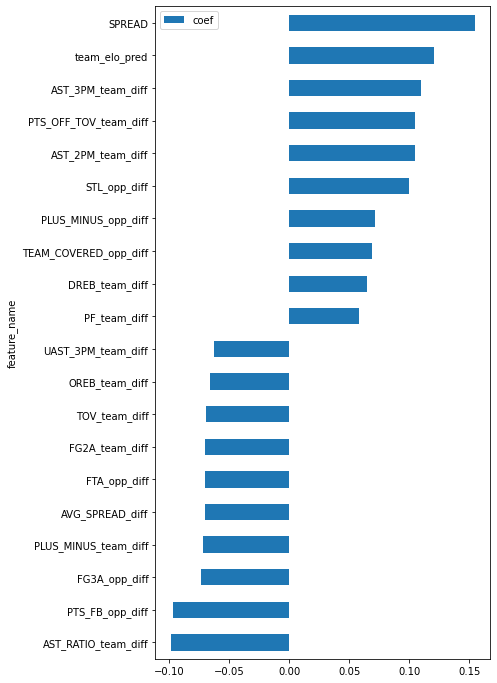

In [65]:
lr_C = study_lr.best_params['C']
print(lr_C)
best_lr = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=10000,
                                                 verbose=1, random_state=23))])
best_lr.fit(X_train, y_train)

print(best_lr)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_test, y_test))

view_model_coefs(best_lr.named_steps['logreg'], X_train)

## SVC 

In [92]:
def objective(trial):    
    svc_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', LinearSVC(C = svc_C,
                                loss='hinge',
                               max_iter=100000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_svc_acc1'
storage_name = "sqlite:///{}.db".format(study_name)

study_svc_acc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_svc_acc.optimize(objective, n_trials=100)

[I 2021-10-11 10:55:46,419] Using an existing study with name 'study_svc_acc1' instead of creating a new one.
[I 2021-10-11 10:55:47,624] Trial 100 finished with value: 0.5243984160828511 and parameters: {'C': 0.03417527990568367}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:55:48,776] Trial 101 finished with value: 0.526835211696619 and parameters: {'C': 0.05120923586550959}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:55:49,840] Trial 102 finished with value: 0.5267133719159306 and parameters: {'C': 0.05078162847343413}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:55:51,811] Trial 103 finished with value: 0.5234236978373439 and parameters: {'C': 0.12664005708102935}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:55:52,615] Trial 104 finished with value: 0.522814498933902 and parameters: {'C': 0.024526581814777522}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:55:53,615] Trial 10

[I 2021-10-11 10:56:47,985] Trial 144 finished with value: 0.5255558939993908 and parameters: {'C': 0.06276203404824926}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:56:49,972] Trial 145 finished with value: 0.5224489795918367 and parameters: {'C': 0.15163505283909107}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:56:50,942] Trial 146 finished with value: 0.5247639354249162 and parameters: {'C': 0.031014136266786098}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:56:51,991] Trial 147 finished with value: 0.5251294547669814 and parameters: {'C': 0.04637551705741446}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:56:53,001] Trial 148 finished with value: 0.5219616204690831 and parameters: {'C': 0.02231224938033065}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 10:56:57,606] Trial 149 finished with value: 0.5218397806883948 and parameters: {'C': 0.2695955254283206}. Best is trial 92 with v

[I 2021-10-11 11:01:36,755] Trial 189 finished with value: 0.5254949741090467 and parameters: {'C': 0.048203729965520574}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 11:01:38,098] Trial 190 finished with value: 0.5251294547669814 and parameters: {'C': 0.06738084426725913}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 11:01:39,464] Trial 191 finished with value: 0.526835211696619 and parameters: {'C': 0.05144926482859481}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 11:01:40,438] Trial 192 finished with value: 0.5242765763021626 and parameters: {'C': 0.03930291736183297}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 11:01:41,283] Trial 193 finished with value: 0.5231800182759672 and parameters: {'C': 0.02741265494934008}. Best is trial 92 with value: 0.5273225708193726.
[I 2021-10-11 11:01:42,195] Trial 194 finished with value: 0.5253731343283582 and parameters: {'C': 0.05720824215560226}. Best is trial 92 with v

In [71]:
svc_C = study_svc_acc.best_params['C']
print('C:', svc_C)
best_svc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', LinearSVC(C = svc_C,
                                loss='hinge',
                               max_iter=100000,
                                     random_state=23))]) 


best_svc.fit(X_train, y_train)

print("best_svc:", best_svc)


print("train_score:", best_svc.score(X_train, y_train))
print("test_score:", best_svc.score(X_test, y_test))

C: 0.05305927223792528
best_svc: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.05305927223792528, loss='hinge', max_iter=100000,
                           random_state=23))])
train_score: 0.5432255444438804
test_score: 0.511282140983033


In [184]:
# svc_pipe_rbf = Pipeline(steps=[('scaler', StandardScaler()),
#                 ('svc', SVC(random_state=23, probability=True))])



# params = {
#     'svc__C': np.logspace(-3,1,100)
# }

# svc_rbf_cv = GridSearchCV(svc_pipe_rbf, param_grid=params, scoring='roc_auc', cv=tscv, n_jobs=-1, verbose=1)


# svc_rbf_cv.fit(X_train, y_train)

# best_svc_rbf = svc_rbf_cv.best_estimator_
# print("best_svc_rbf:", best_svc_rbf)


# print("train_score:", best_svc_rbf.score(X_train, y_train))
# print("test_score:", best_svc_rbf.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 189.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 451.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 584.5min finished


best_svc_rbf: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=0.29150530628251786, probability=True,
                     random_state=23))])
train_score: 0.5943226260051853
test_score: 0.5101282618310482


### SGD Hinge

In [93]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                               max_iter=10000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_sgd2'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=100)

[I 2021-10-11 11:01:48,330] Using an existing study with name 'study_sgd2' instead of creating a new one.
[I 2021-10-11 11:01:49,002] Trial 500 finished with value: 0.526226012793177 and parameters: {'alpha': 0.4927440237202803}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:01:49,661] Trial 501 finished with value: 0.5230581784952787 and parameters: {'alpha': 0.3039277362807537}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:01:50,293] Trial 502 finished with value: 0.5242765763021626 and parameters: {'alpha': 1.0392753762006937}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:01:50,948] Trial 503 finished with value: 0.5238501370697533 and parameters: {'alpha': 0.661597345056209}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:01:51,505] Trial 504 finished with value: 0.5249466950959488 and parameters: {'alpha': 0.4429204246469972}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:01:5

[I 2021-10-11 11:02:17,680] Trial 543 finished with value: 0.5227535790435578 and parameters: {'alpha': 0.4072253247981223}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:18,208] Trial 544 finished with value: 0.5242156564118184 and parameters: {'alpha': 1.0303538639035512}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:18,733] Trial 545 finished with value: 0.5242156564118184 and parameters: {'alpha': 0.7910294620040573}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:19,389] Trial 546 finished with value: 0.5279317697228145 and parameters: {'alpha': 0.5424324661503435}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:20,053] Trial 547 finished with value: 0.5248248553152605 and parameters: {'alpha': 0.4419368589000436}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:21,398] Trial 548 finished with value: 0.49667986597624125 and parameters: {'alpha': 0.000139125586993018

[I 2021-10-11 11:02:46,476] Trial 587 finished with value: 0.5257386536704234 and parameters: {'alpha': 0.4789052414456324}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:47,104] Trial 588 finished with value: 0.5247639354249163 and parameters: {'alpha': 1.3175286697701163}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:47,647] Trial 589 finished with value: 0.5214742613463296 and parameters: {'alpha': 0.36769290278665556}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:48,282] Trial 590 finished with value: 0.5242156564118184 and parameters: {'alpha': 0.7949166852271647}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:48,823] Trial 591 finished with value: 0.5287237282972891 and parameters: {'alpha': 0.5887714456646896}. Best is trial 101 with value: 0.5288455680779774.
[I 2021-10-11 11:02:49,474] Trial 592 finished with value: 0.5265306122448979 and parameters: {'alpha': 0.593793321402732}. 

0.5629982879384883
best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.5629982879384883, loss='modified_huber',
                               max_iter=10000, random_state=23))])
train_score: 0.5393674805827707
test_score: 0.51740423298933


feature_name      coef
54         PTS_FB_opp_diff -0.031994
29      UAST_3PM_team_diff -0.021512
35           FG3A_opp_diff -0.018419
2           FG2A_team_diff -0.012741
22    PTS_2PT_MR_team_diff -0.012563
0         RECORD_team_diff -0.012067
45             PF_opp_diff -0.010825
57        AST_2PM_opp_diff -0.010211
56      PTS_PAINT_opp_diff -0.009653
13           TOV_team_diff -0.008693
41            AST_opp_diff -0.008668
28      UAST_2PM_team_diff -0.008047
80      AST_RATIO_opp_diff -0.007218
70       OREB_PCT_opp_diff -0.007214
43            BLK_opp_diff -0.007198
65         AVG_SPREAD_diff -0.007169
1           FG2M_team_diff -0.007138
12           BLK_team_diff -0.007001
16    PLUS_MINUS_team_diff -0.006570
74        REB_PCT_opp_diff -0.005494
81       TOV_PCT_team_diff -0.005253
15           PTS_team_diff -0.004122
51           POSS_opp_diff -0.004030
55    PTS_OFF_TOV_opp_diff -0.003838
64            ATS_PCT_diff -0.003429
61       ATS_DIFF_opp_diff -0.003364
38           OREB_opp_diff -0.003027
32           FG2M_opp_diff -0.002660
52            PIE_opp_diff -0.002278
7           OREB_team_diff -0.002197
20          POSS_team_diff -0.002038
37            FTA_opp_diff -0.001648
77       EFG_PCT_team_diff -0.001145
3           FG3M_team_diff -0.000996
72       DREB_PCT_opp_diff -0.000943
67       AVG_ATS_DIFF_diff -0.000782
19  E_NET_RATING_team_diff -0.000539
85            opp_rating_i -0.000182
40            REB_opp_diff  0.000254
50   E_NET_RATING_opp_diff  0.000539
86            elo_MOV_pred  0.000857
84           team_rating_i  0.000938
69      OREB_PCT_team_diff  0.000943
79     AST_RATIO_team_diff  0.001071
10           AST_team_diff  0.001211
66             AVG_ML_diff  0.001325
26       AST_2PM_team_diff  0.001417
44            TOV_opp_diff  0.001986
39           DREB_opp_diff  0.002198
21           PIE_team_diff  0.002254
6            FTA_team_diff  0.002928
75        TS_PCT_team_diff  0.003021
46            PTS_opp_diff  0.003085
58        AST_3PM_opp_diff  0.003106
82        TOV_PCT_opp_diff  0.003257
30      ATS_DIFF_team_diff  0.003364
63             WL_PCT_diff  0.003442
25     PTS_PAINT_team_diff  0.004139
68               REST_diff  0.004368
36            FTM_opp_diff  0.004728
34           FG3M_opp_diff  0.004926
83           team_elo_pred  0.005274
73       REB_PCT_team_diff  0.005494
9            REB_team_diff  0.005518
4           FG3A_team_diff  0.006058
17  E_OFF_RATING_team_diff  0.006119
49   E_DEF_RATING_opp_diff  0.006119
5            FTM_team_diff  0.006539
47     PLUS_MINUS_opp_diff  0.006570
78        EFG_PCT_opp_diff  0.006624
33           FG2A_opp_diff  0.006992
71      DREB_PCT_team_diff  0.007214
18  E_DEF_RATING_team_diff  0.007335
48   E_OFF_RATING_opp_diff  0.007335
59       UAST_2PM_opp_diff  0.007394
53     PTS_2PT_MR_opp_diff  0.007590
76         TS_PCT_opp_diff  0.008120
14            PF_team_diff  0.008348
8           DREB_team_diff  0.008693
27       AST_3PM_team_diff  0.010344
11           STL_team_diff  0.011059
60       UAST_3PM_opp_diff  0.011551
31         RECORD_opp_diff  0.012067
23        PTS_FB_team_diff  0.015341
62   TEAM_COVERED_opp_diff  0.016800
42            STL_opp_diff  0.019503
24   PTS_OFF_TOV_team_diff  0.026292
87                  SPREAD  0.027770

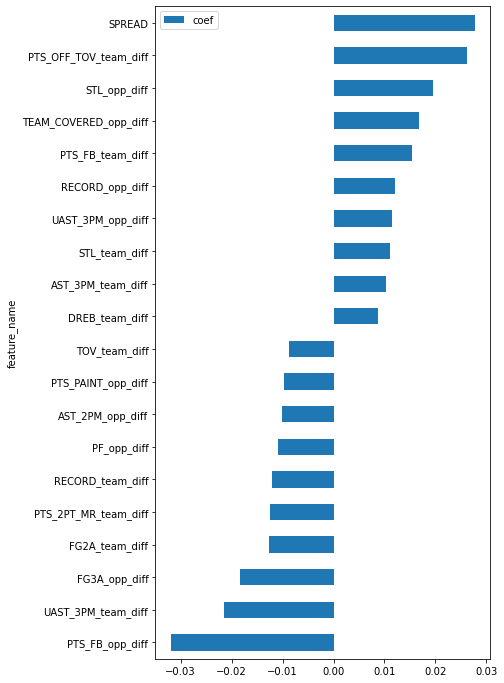

In [72]:
sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                               max_iter=10000,
                                     random_state=23))])


print("best_sgd:", best_sgd)

best_sgd.fit(X_train, y_train)

print("train_score:", best_sgd.score(X_train, y_train))
print("test_score:", best_sgd.score(X_test, y_test))

view_model_coefs(best_sgd.named_steps['sgd'], X_train)

### LGBClassifier

In [94]:
def objective(trial):    
    min_child_weight = trial.suggest_int('min_child_weight', 1, 16)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 20)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 256)
    feature_fraction = trial.suggest_float('feature_fraction', 0.01, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)
    
    classifier_obj = lgb.LGBMClassifier(feature_fraction=feature_fraction,
                                        max_depth=max_depth,
                                        min_child_weight=min_child_weight,
                                        num_leaves=num_leaves, 
                                        random_state=23,
                                        reg_alpha=reg_alpha, 
                                        reg_lambda=reg_lambda,
                                       learning_rate=learning_rate)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_lgbc2'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=200)

[I 2021-10-11 11:02:53,636] Using an existing study with name 'study_lgbc2' instead of creating a new one.
[I 2021-10-11 11:02:56,495] Trial 400 finished with value: 0.5255558939993907 and parameters: {'min_child_weight': 6, 'subsample': 0.7787225180584278, 'max_depth': 6, 'reg_lambda': 9.252848003068834, 'reg_alpha': 1.022185094030791, 'num_leaves': 130, 'feature_fraction': 0.3384760470036062, 'learning_rate': 0.007083156003870116}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:02:58,261] Trial 401 finished with value: 0.5204995431008224 and parameters: {'min_child_weight': 6, 'subsample': 0.7881637490091066, 'max_depth': 5, 'reg_lambda': 9.107824804242801, 'reg_alpha': 0.9070521446704113, 'num_leaves': 129, 'feature_fraction': 0.3020126062226327, 'learning_rate': 0.007014127073382764}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:03:00,666] Trial 402 finished with value: 0.5230581784952788 and parameters: {'min_child_weight': 6, 'subsample':

[I 2021-10-11 11:03:47,243] Trial 421 finished with value: 0.5238501370697533 and parameters: {'min_child_weight': 6, 'subsample': 0.7768866084216862, 'max_depth': 6, 'reg_lambda': 9.616402501312574, 'reg_alpha': 2.1951447441015675, 'num_leaves': 145, 'feature_fraction': 0.3325005037592876, 'learning_rate': 0.008392836982272885}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:03:50,063] Trial 422 finished with value: 0.5245811757538836 and parameters: {'min_child_weight': 5, 'subsample': 0.765072625495611, 'max_depth': 7, 'reg_lambda': 10.459220821643854, 'reg_alpha': 2.3685512339217327, 'num_leaves': 139, 'feature_fraction': 0.33847717241295827, 'learning_rate': 0.009742349223038679}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:03:52,864] Trial 423 finished with value: 0.5238501370697533 and parameters: {'min_child_weight': 5, 'subsample': 0.7739229215837072, 'max_depth': 7, 'reg_lambda': 10.282385936090595, 'reg_alpha': 2.509129748485203, 'n

[I 2021-10-11 11:04:44,689] Trial 442 finished with value: 0.5217179409077064 and parameters: {'min_child_weight': 7, 'subsample': 0.7106467235923067, 'max_depth': 7, 'reg_lambda': 11.434522679827944, 'reg_alpha': 1.384559348201966, 'num_leaves': 148, 'feature_fraction': 0.36840699239571817, 'learning_rate': 0.005683826072778327}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:04:46,558] Trial 443 finished with value: 0.5209259823332317 and parameters: {'min_child_weight': 6, 'subsample': 0.8193326391311407, 'max_depth': 5, 'reg_lambda': 11.23106215252199, 'reg_alpha': 1.2175810546671837, 'num_leaves': 157, 'feature_fraction': 0.35020922506653324, 'learning_rate': 0.005009179664673221}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:04:50,620] Trial 444 finished with value: 0.5184282668291197 and parameters: {'min_child_weight': 8, 'subsample': 0.8083842579392574, 'max_depth': 10, 'reg_lambda': 11.184036743219785, 'reg_alpha': 0.9137535480352565,

[I 2021-10-11 11:05:41,344] Trial 463 finished with value: 0.5188547060615291 and parameters: {'min_child_weight': 6, 'subsample': 0.7821368887316037, 'max_depth': 7, 'reg_lambda': 8.471220884287312, 'reg_alpha': 0.9339139892161544, 'num_leaves': 211, 'feature_fraction': 0.2680066567696571, 'learning_rate': 0.005693482753967936}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:05:43,183] Trial 464 finished with value: 0.5229972586049345 and parameters: {'min_child_weight': 3, 'subsample': 0.8019781454517252, 'max_depth': 5, 'reg_lambda': 9.76910599476364, 'reg_alpha': 1.0578928576458866, 'num_leaves': 178, 'feature_fraction': 0.3206604775343555, 'learning_rate': 0.0070291194401002795}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:05:45,509] Trial 465 finished with value: 0.5239110569600975 and parameters: {'min_child_weight': 9, 'subsample': 0.783788980482997, 'max_depth': 6, 'reg_lambda': 8.910293162442175, 'reg_alpha': 1.9123865494264707, 'num

[I 2021-10-11 11:06:32,152] Trial 484 finished with value: 0.5254340542187024 and parameters: {'min_child_weight': 7, 'subsample': 0.7304997707845602, 'max_depth': 6, 'reg_lambda': 8.213193812587125, 'reg_alpha': 0.640818662319862, 'num_leaves': 155, 'feature_fraction': 0.32997041612681705, 'learning_rate': 0.0071270030365671155}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:06:34,382] Trial 485 finished with value: 0.5247639354249163 and parameters: {'min_child_weight': 7, 'subsample': 0.731763511315856, 'max_depth': 6, 'reg_lambda': 8.298168989195675, 'reg_alpha': 0.6595471266752713, 'num_leaves': 168, 'feature_fraction': 0.3093320462507535, 'learning_rate': 0.007107423062926975}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:06:36,339] Trial 486 finished with value: 0.5180627474870545 and parameters: {'min_child_weight': 7, 'subsample': 0.7313928184327455, 'max_depth': 6, 'reg_lambda': 8.111771707016793, 'reg_alpha': 0.6537929765691646, 'nu

[I 2021-10-11 11:07:18,907] Trial 505 finished with value: 0.5221443801401158 and parameters: {'min_child_weight': 6, 'subsample': 0.7431988121833906, 'max_depth': 6, 'reg_lambda': 8.622961587946293, 'reg_alpha': 0.9974369149707741, 'num_leaves': 163, 'feature_fraction': 0.2944226175941583, 'learning_rate': 0.005769998013165712}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:07:21,070] Trial 506 finished with value: 0.5262869326835211 and parameters: {'min_child_weight': 6, 'subsample': 0.7114370511482706, 'max_depth': 6, 'reg_lambda': 7.619807104053426, 'reg_alpha': 0.7950656254789158, 'num_leaves': 159, 'feature_fraction': 0.3170488193864802, 'learning_rate': 0.008227115620898756}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:07:22,975] Trial 507 finished with value: 0.5159914712153518 and parameters: {'min_child_weight': 6, 'subsample': 0.705699536460472, 'max_depth': 6, 'reg_lambda': 7.244792960676774, 'reg_alpha': 0.8365131405182491, 'num

[I 2021-10-11 11:08:06,471] Trial 526 finished with value: 0.5144075540664027 and parameters: {'min_child_weight': 6, 'subsample': 0.7198407006306284, 'max_depth': 5, 'reg_lambda': 8.641401187481534, 'reg_alpha': 1.2059349452980281, 'num_leaves': 185, 'feature_fraction': 0.11502077064974711, 'learning_rate': 0.006578390002584492}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:08:08,682] Trial 527 finished with value: 0.5240328967407859 and parameters: {'min_child_weight': 6, 'subsample': 0.7332061088353021, 'max_depth': 6, 'reg_lambda': 8.124585435311513, 'reg_alpha': 0.5140091208777964, 'num_leaves': 152, 'feature_fraction': 0.3182254316347004, 'learning_rate': 0.008603715089149495}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:08:11,029] Trial 528 finished with value: 0.525312214438014 and parameters: {'min_child_weight': 7, 'subsample': 0.7042742008829287, 'max_depth': 6, 'reg_lambda': 9.03038188838418, 'reg_alpha': 0.8206985769468468, 'num

[I 2021-10-11 11:08:59,684] Trial 547 finished with value: 0.5216570210173621 and parameters: {'min_child_weight': 7, 'subsample': 0.7353310155272033, 'max_depth': 10, 'reg_lambda': 7.595734038355159, 'reg_alpha': 0.7692455280374777, 'num_leaves': 49, 'feature_fraction': 0.3225453967298141, 'learning_rate': 0.006472699634026704}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:09:02,094] Trial 548 finished with value: 0.5194639049649711 and parameters: {'min_child_weight': 8, 'subsample': 0.7235971920874741, 'max_depth': 6, 'reg_lambda': 8.338414210840066, 'reg_alpha': 0.8588683704540219, 'num_leaves': 190, 'feature_fraction': 0.3913042786348917, 'learning_rate': 0.00467736620123564}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:09:04,196] Trial 549 finished with value: 0.5206213828815108 and parameters: {'min_child_weight': 5, 'subsample': 0.7078595490676568, 'max_depth': 5, 'reg_lambda': 8.087646505498403, 'reg_alpha': 0.6975859500596773, 'num

[I 2021-10-11 11:09:48,893] Trial 568 finished with value: 0.5208650624428877 and parameters: {'min_child_weight': 15, 'subsample': 0.7457661346878092, 'max_depth': 7, 'reg_lambda': 8.194585524034974, 'reg_alpha': 0.8600703270820483, 'num_leaves': 162, 'feature_fraction': 0.2853358562873629, 'learning_rate': 0.006744206313495177}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:09:51,286] Trial 569 finished with value: 0.5200121839780689 and parameters: {'min_child_weight': 4, 'subsample': 0.7340677481340256, 'max_depth': 6, 'reg_lambda': 8.71179073518617, 'reg_alpha': 0.6300277860353953, 'num_leaves': 142, 'feature_fraction': 0.3685774797871267, 'learning_rate': 0.010360953605581558}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:09:53,245] Trial 570 finished with value: 0.5208650624428875 and parameters: {'min_child_weight': 5, 'subsample': 0.7108106121849421, 'max_depth': 5, 'reg_lambda': 7.781813569252922, 'reg_alpha': 0.7145926084175196, 'nu

[I 2021-10-11 11:10:46,592] Trial 589 finished with value: 0.5180627474870545 and parameters: {'min_child_weight': 8, 'subsample': 0.7432242115527731, 'max_depth': 6, 'reg_lambda': 5.058256774440882, 'reg_alpha': 0.5727737852725611, 'num_leaves': 185, 'feature_fraction': 0.366197082595555, 'learning_rate': 0.004679494540089164}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:10:49,154] Trial 590 finished with value: 0.5245811757538836 and parameters: {'min_child_weight': 6, 'subsample': 0.7540713114360652, 'max_depth': 7, 'reg_lambda': 10.152551606629919, 'reg_alpha': 0.9885935916851709, 'num_leaves': 145, 'feature_fraction': 0.30279299297183826, 'learning_rate': 0.006542004568967685}. Best is trial 275 with value: 0.5275662503807492.
[I 2021-10-11 11:10:51,601] Trial 591 finished with value: 0.5195248248553153 and parameters: {'min_child_weight': 7, 'subsample': 0.8222243720505554, 'max_depth': 6, 'reg_lambda': 8.716746068252174, 'reg_alpha': 0.4414045932594479, 'n

best_lgbc: LGBMClassifier(feature_fraction=0.3051001001193572,
               learning_rate=0.006166887625023153, max_depth=6,
               min_child_weight=6, num_leaves=157, random_state=23,
               reg_alpha=0.7454113150705293, reg_lambda=8.933329270545642,
               subsample=0.7482417381070169)
[LightGBM] [Warning] feature_fraction is set=0.3051001001193572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3051001001193572
train_acc: 0.7027767907000355
test_acc: 0.4993003323421375
LGBoost or XGBoost


feature_name  coef
68               REST_diff    14
75        TS_PCT_team_diff    18
50   E_NET_RATING_opp_diff    19
86            elo_MOV_pred    20
47     PLUS_MINUS_opp_diff    23
49   E_DEF_RATING_opp_diff    25
19  E_NET_RATING_team_diff    26
74        REB_PCT_opp_diff    27
52            PIE_opp_diff    29
31         RECORD_opp_diff    31
71      DREB_PCT_team_diff    33
17  E_OFF_RATING_team_diff    35
63             WL_PCT_diff    36
16    PLUS_MINUS_team_diff    38
48   E_OFF_RATING_opp_diff    40
23        PTS_FB_team_diff    40
51           POSS_opp_diff    42
73       REB_PCT_team_diff    44
61       ATS_DIFF_opp_diff    44
7           OREB_team_diff    44
6            FTA_team_diff    45
77       EFG_PCT_team_diff    45
66             AVG_ML_diff    46
40            REB_opp_diff    46
45             PF_opp_diff    46
15           PTS_team_diff    47
83           team_elo_pred    47
69      OREB_PCT_team_diff    48
46            PTS_opp_diff    48
58        AST_3PM_opp_diff    49
25     PTS_PAINT_team_diff    50
78        EFG_PCT_opp_diff    51
65         AVG_SPREAD_diff    51
81       TOV_PCT_team_diff    51
0         RECORD_team_diff    51
67       AVG_ATS_DIFF_diff    52
12           BLK_team_diff    52
39           DREB_opp_diff    53
72       DREB_PCT_opp_diff    55
30      ATS_DIFF_team_diff    55
84           team_rating_i    56
13           TOV_team_diff    56
43            BLK_opp_diff    57
44            TOV_opp_diff    59
9            REB_team_diff    59
64            ATS_PCT_diff    59
79     AST_RATIO_team_diff    60
41            AST_opp_diff    62
5            FTM_team_diff    62
20          POSS_team_diff    62
37            FTA_opp_diff    63
8           DREB_team_diff    63
1           FG2M_team_diff    64
70       OREB_PCT_opp_diff    64
10           AST_team_diff    66
18  E_DEF_RATING_team_diff    66
2           FG2A_team_diff    68
21           PIE_team_diff    68
26       AST_2PM_team_diff    68
87                  SPREAD    70
32           FG2M_opp_diff    71
55    PTS_OFF_TOV_opp_diff    71
35           FG3A_opp_diff    72
4           FG3A_team_diff    73
27       AST_3PM_team_diff    74
34           FG3M_opp_diff    76
57        AST_2PM_opp_diff    77
82        TOV_PCT_opp_diff    77
60       UAST_3PM_opp_diff    79
85            opp_rating_i    80
28      UAST_2PM_team_diff    80
11           STL_team_diff    82
36            FTM_opp_diff    82
38           OREB_opp_diff    84
80      AST_RATIO_opp_diff    84
76         TS_PCT_opp_diff    84
62   TEAM_COVERED_opp_diff    84
56      PTS_PAINT_opp_diff    84
59       UAST_2PM_opp_diff    86
33           FG2A_opp_diff    86
24   PTS_OFF_TOV_team_diff    92
22    PTS_2PT_MR_team_diff   102
53     PTS_2PT_MR_opp_diff   105
42            STL_opp_diff   105
29      UAST_3PM_team_diff   111
14            PF_team_diff   116
3           FG3M_team_diff   117
54         PTS_FB_opp_diff   151

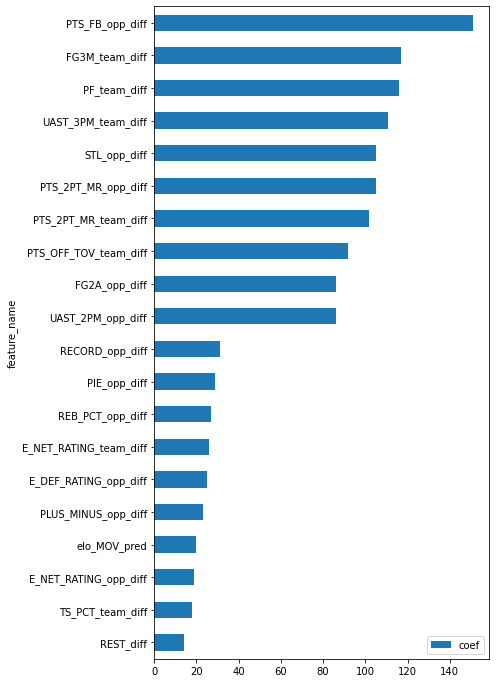

In [73]:
lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = lgb.LGBMClassifier()
best_lgbc.set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc, X_train)


### KNNeighbors

In [69]:
def objective(trial):    

    n_neighbors = trial.suggest_int('n_neighbors', 1, 52)
    
    classifier_obj = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=n_neighbors))]) 
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_knn2'
storage_name = "sqlite:///{}.db".format(study_name)

search_space = {'n_neighbors':np.arange(1, 51).tolist()}

study_knn = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True,
                               sampler = optuna.samplers.GridSampler(search_space))

study_knn.optimize(objective)

[I 2021-10-11 00:05:28,744] A new study created in RDB with name: study_knn2
[I 2021-10-11 00:05:47,729] Trial 0 finished with value: 0.49929942126104176 and parameters: {'n_neighbors': 29}. Best is trial 0 with value: 0.49929942126104176.
[I 2021-10-11 00:06:06,607] Trial 1 finished with value: 0.5069144075540664 and parameters: {'n_neighbors': 40}. Best is trial 1 with value: 0.5069144075540664.
[I 2021-10-11 00:06:25,180] Trial 2 finished with value: 0.5050258909533963 and parameters: {'n_neighbors': 38}. Best is trial 1 with value: 0.5069144075540664.
[I 2021-10-11 00:06:44,322] Trial 3 finished with value: 0.4979591836734694 and parameters: {'n_neighbors': 27}. Best is trial 1 with value: 0.5069144075540664.
[I 2021-10-11 00:07:02,767] Trial 4 finished with value: 0.49850746268656715 and parameters: {'n_neighbors': 6}. Best is trial 1 with value: 0.5069144075540664.
[I 2021-10-11 00:07:21,465] Trial 5 finished with value: 0.5022235759975633 and parameters: {'n_neighbors': 11}. Bes

[I 2021-10-11 00:20:25,024] Trial 47 finished with value: 0.5025281754492842 and parameters: {'n_neighbors': 4}. Best is trial 38 with value: 0.5127017971367651.
[I 2021-10-11 00:20:43,620] Trial 48 finished with value: 0.5016752969844654 and parameters: {'n_neighbors': 24}. Best is trial 38 with value: 0.5127017971367651.
[I 2021-10-11 00:21:02,393] Trial 49 finished with value: 0.5064270484313129 and parameters: {'n_neighbors': 19}. Best is trial 38 with value: 0.5127017971367651.


In [74]:
best_n = study_knn.best_trial.params['n_neighbors']

best_knn = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=best_n))])

print(best_knn)

best_knn.fit(X_train, y_train)
print(best_knn.score(X_train, y_train))
print(best_knn.score(X_test, y_test))

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=47))])
0.560586831818874
0.5049851320622705


### Random Forest

In [95]:
def objective(trial):    
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
#     subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)

    classifier_obj = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_rf2'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_rf.optimize(objective, n_trials=250)

[I 2021-10-11 11:11:10,476] Using an existing study with name 'study_rf2' instead of creating a new one.
[I 2021-10-11 11:11:16,489] Trial 250 finished with value: 0.5155041120925982 and parameters: {'min_samples_split': 0.04528481612195265, 'max_depth': 26, 'min_samples_leaf': 0.02838097809848872}. Best is trial 134 with value: 0.5192811452939384.
[I 2021-10-11 11:11:22,847] Trial 251 finished with value: 0.5157477916539751 and parameters: {'min_samples_split': 0.059718520677888284, 'max_depth': 27, 'min_samples_leaf': 0.01879760718999688}. Best is trial 134 with value: 0.5192811452939384.
[I 2021-10-11 11:11:27,795] Trial 252 finished with value: 0.5166006701187937 and parameters: {'min_samples_split': 0.029483221233686602, 'max_depth': 25, 'min_samples_leaf': 0.040883334674972724}. Best is trial 134 with value: 0.5192811452939384.
[I 2021-10-11 11:11:34,980] Trial 253 finished with value: 0.5195248248553153 and parameters: {'min_samples_split': 0.05139671386335103, 'max_depth': 23, 

[I 2021-10-11 11:14:14,087] Trial 282 finished with value: 0.5056350898568382 and parameters: {'min_samples_split': 0.06856009875881118, 'max_depth': 21, 'min_samples_leaf': 0.3205140605587067}. Best is trial 257 with value: 0.5195248248553154.
[I 2021-10-11 11:14:20,645] Trial 283 finished with value: 0.5166615900091379 and parameters: {'min_samples_split': 0.026292535860291434, 'max_depth': 24, 'min_samples_leaf': 0.020375415618213714}. Best is trial 257 with value: 0.5195248248553154.
[I 2021-10-11 11:14:26,511] Trial 284 finished with value: 0.5162351507767287 and parameters: {'min_samples_split': 0.059563761410203836, 'max_depth': 23, 'min_samples_leaf': 0.028136890033917727}. Best is trial 257 with value: 0.5195248248553154.
[I 2021-10-11 11:14:28,731] Trial 285 finished with value: 0.5092293633871459 and parameters: {'min_samples_split': 0.046253143674901374, 'max_depth': 24, 'min_samples_leaf': 0.17547720330173006}. Best is trial 257 with value: 0.5195248248553154.
[I 2021-10-1

[I 2021-10-11 11:17:04,495] Trial 314 finished with value: 0.5141638745050259 and parameters: {'min_samples_split': 0.07988306259923457, 'max_depth': 11, 'min_samples_leaf': 0.053718514120893096}. Best is trial 257 with value: 0.5195248248553154.
[I 2021-10-11 11:17:10,172] Trial 315 finished with value: 0.5175144684739568 and parameters: {'min_samples_split': 0.06977699882117666, 'max_depth': 25, 'min_samples_leaf': 0.027928857957320634}. Best is trial 257 with value: 0.5195248248553154.
[I 2021-10-11 11:17:15,396] Trial 316 finished with value: 0.5159914712153519 and parameters: {'min_samples_split': 0.07137428986367203, 'max_depth': 28, 'min_samples_leaf': 0.036324781851226486}. Best is trial 257 with value: 0.5195248248553154.
[I 2021-10-11 11:17:21,708] Trial 317 finished with value: 0.5141029546146816 and parameters: {'min_samples_split': 0.09124068143409449, 'max_depth': 25, 'min_samples_leaf': 0.010029759149372066}. Best is trial 257 with value: 0.5195248248553154.
[I 2021-10-1

[I 2021-10-11 11:19:41,496] Trial 346 finished with value: 0.5149558330795004 and parameters: {'min_samples_split': 0.03969067322796606, 'max_depth': 24, 'min_samples_leaf': 0.019616684392428363}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:19:47,901] Trial 347 finished with value: 0.5150167529698446 and parameters: {'min_samples_split': 0.048828664279881376, 'max_depth': 25, 'min_samples_leaf': 0.02004669897052726}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:19:55,017] Trial 348 finished with value: 0.5144075540664027 and parameters: {'min_samples_split': 0.057345605768623235, 'max_depth': 23, 'min_samples_leaf': 0.010165544002648984}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:20:00,667] Trial 349 finished with value: 0.51422479439537 and parameters: {'min_samples_split': 0.019067367600037466, 'max_depth': 22, 'min_samples_leaf': 0.03148345155150727}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11

[I 2021-10-11 11:22:41,454] Trial 378 finished with value: 0.5161133109960402 and parameters: {'min_samples_split': 0.06950684552336149, 'max_depth': 25, 'min_samples_leaf': 0.03179835971267776}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:22:47,944] Trial 379 finished with value: 0.5114833993298812 and parameters: {'min_samples_split': 0.04690176928697164, 'max_depth': 24, 'min_samples_leaf': 0.019922629990204367}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:22:50,050] Trial 380 finished with value: 0.510813280536095 and parameters: {'min_samples_split': 0.05980502745808104, 'max_depth': 20, 'min_samples_leaf': 0.1890044521158291}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:22:55,134] Trial 381 finished with value: 0.5148949131891563 and parameters: {'min_samples_split': 0.07983640686254441, 'max_depth': 25, 'min_samples_leaf': 0.041201929879528726}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11

[I 2021-10-11 11:25:35,948] Trial 410 finished with value: 0.5161742308863844 and parameters: {'min_samples_split': 0.06916561142513665, 'max_depth': 29, 'min_samples_leaf': 0.028752139697294662}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:25:40,151] Trial 411 finished with value: 0.5118489186719464 and parameters: {'min_samples_split': 0.22049208177823476, 'max_depth': 24, 'min_samples_leaf': 0.020485015265483082}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:25:42,846] Trial 412 finished with value: 0.5066098081023455 and parameters: {'min_samples_split': 0.42902653896213416, 'max_depth': 28, 'min_samples_leaf': 0.010040183336572955}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:25:48,551] Trial 413 finished with value: 0.5156259518732866 and parameters: {'min_samples_split': 0.0627273064788694, 'max_depth': 23, 'min_samples_leaf': 0.029856183318770733}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11

[I 2021-10-11 11:28:26,913] Trial 442 finished with value: 0.5129454766981418 and parameters: {'min_samples_split': 0.06647341342165804, 'max_depth': 23, 'min_samples_leaf': 0.019284933867729795}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:28:32,539] Trial 443 finished with value: 0.5151995126408773 and parameters: {'min_samples_split': 0.04934685748107925, 'max_depth': 25, 'min_samples_leaf': 0.030330240898651217}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:28:34,486] Trial 444 finished with value: 0.5134328358208956 and parameters: {'min_samples_split': 0.08721472998934544, 'max_depth': 24, 'min_samples_leaf': 0.21719549780805011}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:28:42,164] Trial 445 finished with value: 0.5159305513250076 and parameters: {'min_samples_split': 0.03607468043675649, 'max_depth': 30, 'min_samples_leaf': 0.010091406805864251}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11

[I 2021-10-11 11:31:18,524] Trial 474 finished with value: 0.5147121535181237 and parameters: {'min_samples_split': 0.08635918772244958, 'max_depth': 22, 'min_samples_leaf': 0.03293017481468652}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:31:24,467] Trial 475 finished with value: 0.512031678342979 and parameters: {'min_samples_split': 0.06948969810215957, 'max_depth': 25, 'min_samples_leaf': 0.019825366864245568}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:31:27,169] Trial 476 finished with value: 0.5125190374657326 and parameters: {'min_samples_split': 0.046314795230626836, 'max_depth': 23, 'min_samples_leaf': 0.1343429049447264}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11:31:31,570] Trial 477 finished with value: 0.5143466341760585 and parameters: {'min_samples_split': 0.02550042168154952, 'max_depth': 26, 'min_samples_leaf': 0.05502634119697654}. Best is trial 343 with value: 0.5198903441973804.
[I 2021-10-11 11

In [75]:
print(study_rf.best_params)

max_depth = study_rf.best_params['max_depth']
min_samples_leaf = study_rf.best_params['min_samples_leaf']
min_samples_split = study_rf.best_params['min_samples_split']


best_rf = RandomForestClassifier(max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                min_samples_split=min_samples_split,
                                random_state=23)

{'max_depth': 24, 'min_samples_leaf': 0.01074725040688385, 'min_samples_split': 0.04255304531570348}


In [76]:
best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

rf train_acc: 0.6154119498451698
rf test_acc: 0.5035857967465454


LGBoost or XGBoost


feature_name      coef
66                 rest_diff  0.000972
37             FG3M_opp_diff  0.001429
20    E_OFF_RATING_team_diff  0.001514
53     E_NET_RATING_opp_diff  0.002010
52     E_DEF_RATING_opp_diff  0.002091
16             TOV_team_diff  0.002362
50       PLUS_MINUS_opp_diff  0.002448
70         DREB_PCT_opp_diff  0.002520
49              PTS_opp_diff  0.002743
13             AST_team_diff  0.003057
40              FTA_opp_diff  0.003295
82             team_rating_i  0.003349
8              FTM_team_diff  0.003410
81             team_elo_pred  0.003425
11            DREB_team_diff  0.003465
55              PIE_opp_diff  0.003916
71         REB_PCT_team_diff  0.004120
21    E_DEF_RATING_team_diff  0.004511
36             FG2A_opp_diff  0.004626
83              opp_rating_i  0.004650
72          REB_PCT_opp_diff  0.004758
19      PLUS_MINUS_team_diff  0.005257
10            OREB_team_diff  0.005337
39              FTM_opp_diff  0.005431
24             PIE_team_diff  0.005489
79         TOV_PCT_team_diff  0.005588
42             DREB_opp_diff  0.005612
84              elo_MOV_pred  0.005631
46              BLK_opp_diff  0.005694
75         EFG_PCT_team_diff  0.005724
67        OREB_PCT_team_diff  0.005783
22    E_NET_RATING_team_diff  0.005812
23            POSS_team_diff  0.005833
51     E_OFF_RATING_opp_diff  0.006010
48               PF_opp_diff  0.006221
64            WL_record_diff  0.006473
1                 avg_spread  0.006485
9              FTA_team_diff  0.006487
29         AST_2PM_team_diff  0.006502
73          TS_PCT_team_diff  0.006865
14             STL_team_diff  0.007245
45              STL_opp_diff  0.007290
30        UAST_2PM_team_diff  0.007438
15             BLK_team_diff  0.007663
17              PF_team_diff  0.007667
3   points_covered_spread_by  0.007716
43              REB_opp_diff  0.007724
28       PTS_PAINT_team_diff  0.007855
47              TOV_opp_diff  0.009147
6             FG3M_team_diff  0.009249
2      avg_point_spread_diff  0.009381
65           ATS_record_diff  0.009542
69        DREB_PCT_team_diff  0.010057
58      PTS_OFF_TOV_opp_diff  0.010142
61         UAST_2PM_opp_diff  0.010275
33     team_covered_opp_diff  0.010910
35             FG2M_opp_diff  0.011093
68         OREB_PCT_opp_diff  0.011163
54             POSS_opp_diff  0.011731
77       AST_RATIO_team_diff  0.011981
0                     avg_ml  0.012038
12             REB_team_diff  0.012103
76          EFG_PCT_opp_diff  0.012121
80          TOV_PCT_opp_diff  0.012151
34           RECORD_opp_diff  0.014485
62          AST_3PM_opp_diff  0.014602
85                    spread  0.015069
59        PTS_PAINT_opp_diff  0.018102
38             FG3A_opp_diff  0.018749
26          PTS_FB_team_diff  0.019376
44              AST_opp_diff  0.019534
18             PTS_team_diff  0.020326
74           TS_PCT_opp_diff  0.021964
4             FG2M_team_diff  0.022519
78        AST_RATIO_opp_diff  0.023398
32        UAST_3PM_team_diff  0.026255
63         UAST_3PM_opp_diff  0.028852
56       PTS_2PT_MR_opp_diff  0.029076
5             FG2A_team_diff  0.030273
60          AST_2PM_opp_diff  0.031766
41             OREB_opp_diff  0.032465
27     PTS_OFF_TOV_team_diff  0.035750
25      PTS_2PT_MR_team_diff  0.038456
57           PTS_FB_opp_diff  0.040444
31         AST_3PM_team_diff  0.042942
7             FG3A_team_diff  0.045011

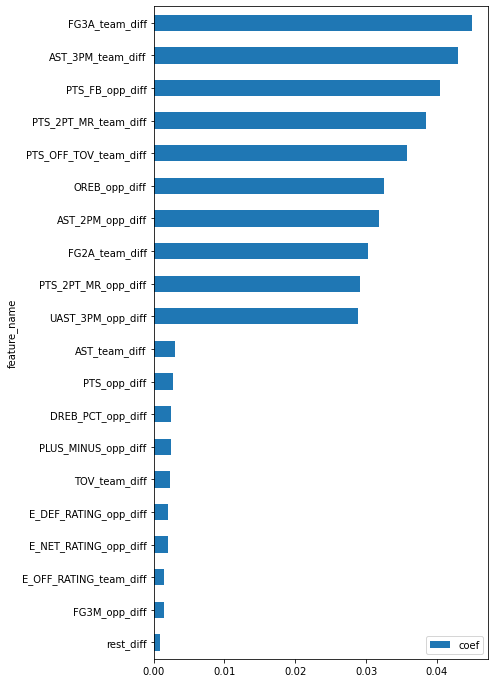

In [112]:
view_model_coefs(best_rf, X_train)

## Stacked Classifier

### new_version

0
test set 1: 2016-11-04 - 2017-06-12


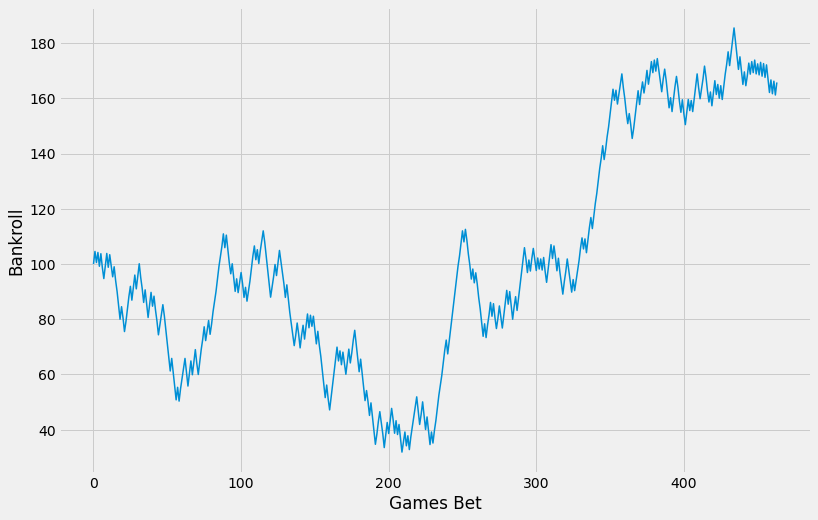

min balance: 31.909090909091105 
max balance: 185.4545454545451 
final balance: 160.7272727272722 
win percentage 53.879999999999995 
profit: 60.72727272727275 risk: 2150.0 
ROI: 2.82
1
test set 1: 2017-10-28 - 2018-06-08


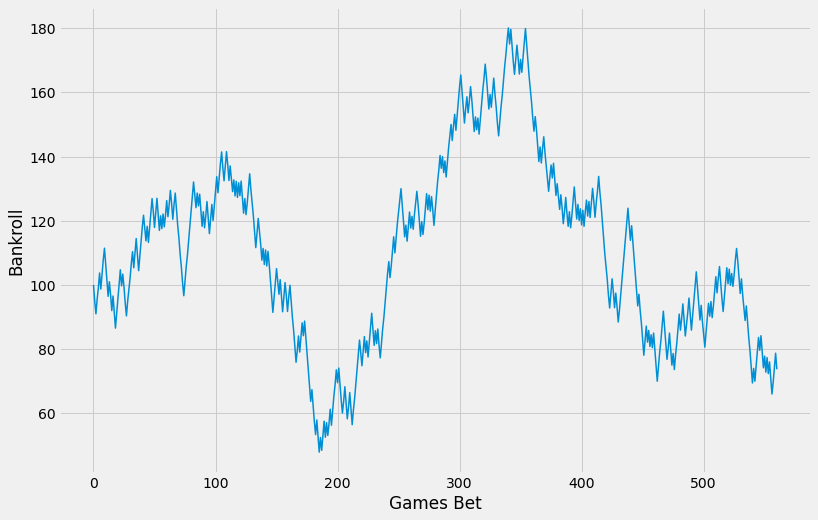

min balance: 47.90909090909085 
max balance: 180.09090909090864 
final balance: 68.72727272727224 
win percentage 51.519999999999996 
profit: -31.27272727272748 risk: 2641.0 
ROI: -1.18
2
test set 1: 2018-10-26 - 2019-06-13


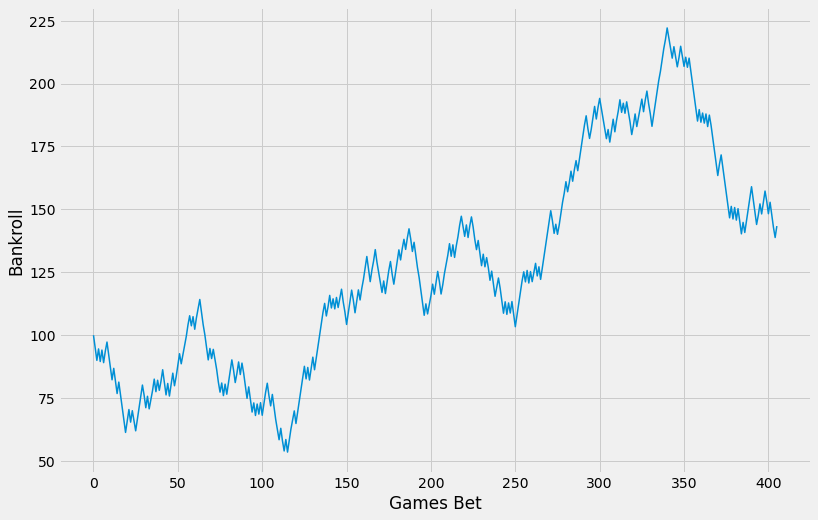

min balance: 53.54545454545466 
max balance: 222.0909090909085 
final balance: 146.9999999999991 
win percentage 53.449999999999996 
profit: 46.999999999999886 risk: 1885.0 
ROI: 2.4899999999999998
3
test set 1: 2019-11-01 - 2020-10-11


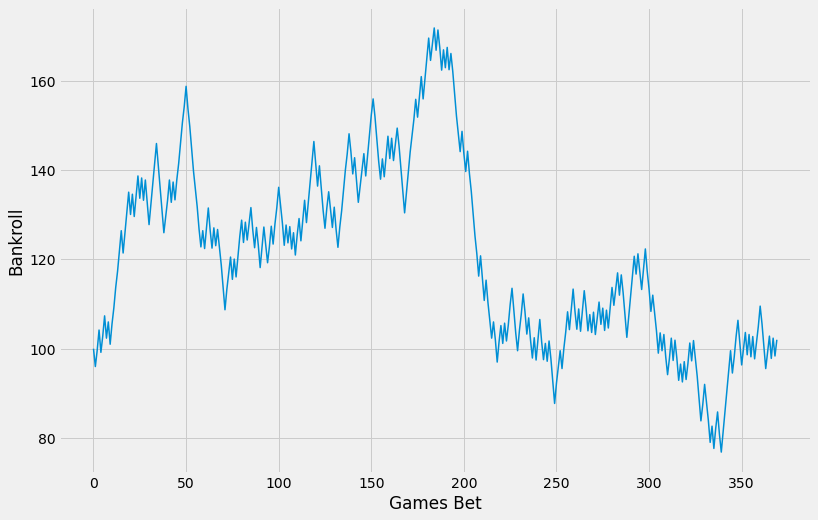

min balance: 76.81818181818115 
max balance: 171.90909090909017 
final balance: 105.63636363636301 
win percentage 52.16 
profit: 5.636363636363626 risk: 1703.0 
ROI: 0.33
4
test set 1: 2021-01-01 - 2021-07-20


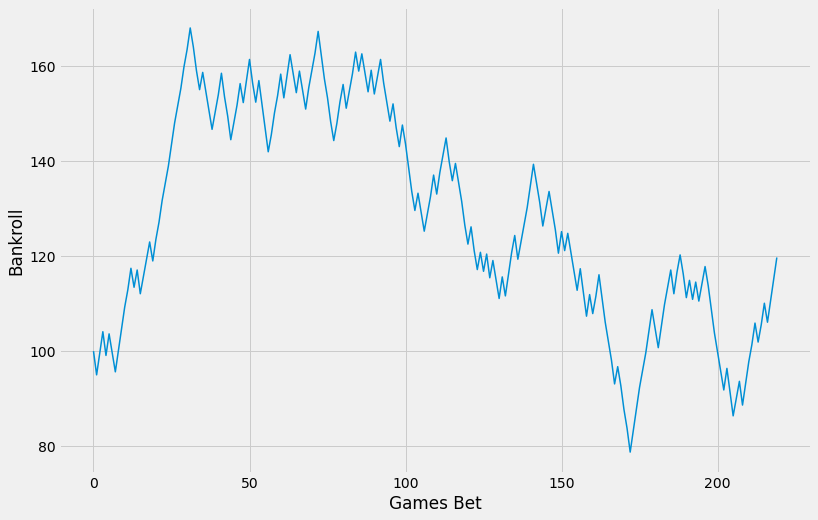

min balance: 78.72727272727217 
max balance: 168.090909090909 
final balance: 124.27272727272678 
win percentage 53.18000000000001 
profit: 24.272727272727252 risk: 978.0 
ROI: 2.48

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.01594150527060011,
                                                                    max_iter=10000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                        

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.538793            464  0.028245   
1  (2017, -, 2018)            0.53  0.515152            561 -0.011841   
2  (2018, -, 2019)            0.53  0.534483            406  0.024934   
3  (2019, -, 2020)            0.53  0.521622            370  0.003310   
4  (2021, -, 2021)            0.53  0.531818            220  0.024819   

     profits  
0  60.727273  
1 -31.272727  
2  47.000000  
3   5.636364  
4  24.272727

In [96]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), # ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

sults_by_season

0
test set 1: 2016-11-04 - 2017-06-12


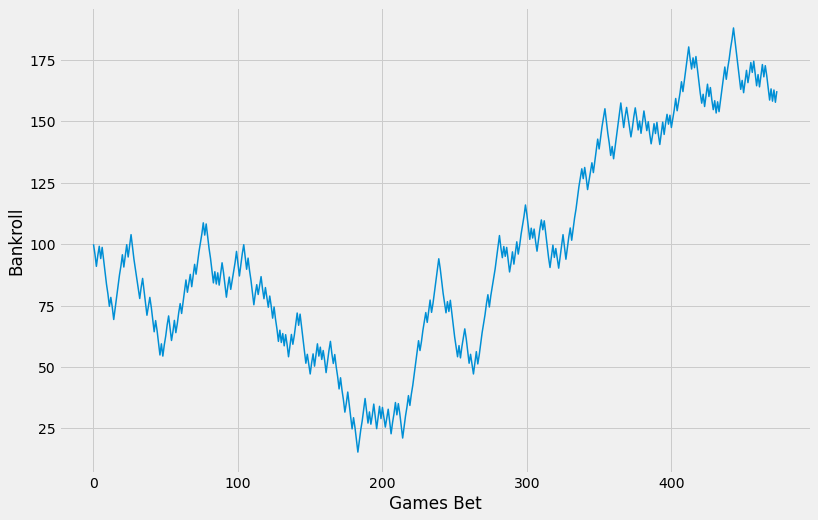

min balance: 15.36363636363648 
max balance: 188.09090909090864 
final balance: 157.36363636363575 
win percentage 53.800000000000004 
profit: 57.36363636363626 risk: 2203.0 
ROI: 2.6
1
test set 1: 2017-10-28 - 2018-06-08


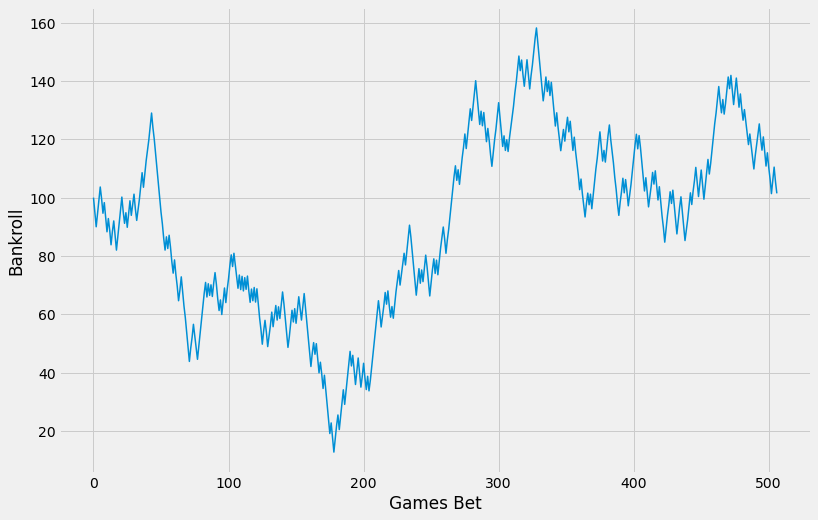

min balance: 12.727272727272808 
max balance: 158.18181818181813 
final balance: 97.45454545454537 
win percentage 52.27 
profit: -2.5454545454547315 risk: 2366.0 
ROI: -0.11
2
test set 1: 2018-10-26 - 2019-06-13


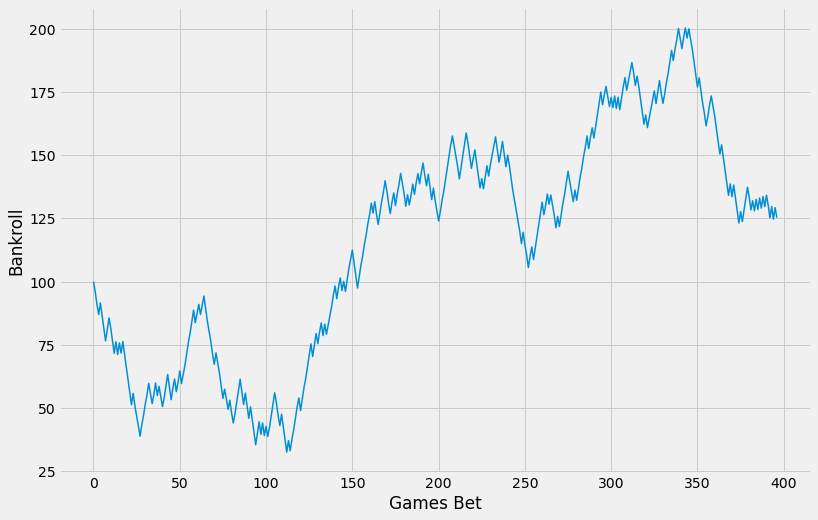

min balance: 32.545454545454554 
max balance: 200.3636363636354 
final balance: 128.90909090908974 
win percentage 52.900000000000006 
profit: 28.909090909090878 risk: 1821.0 
ROI: 1.59
3
test set 1: 2019-11-01 - 2020-10-11


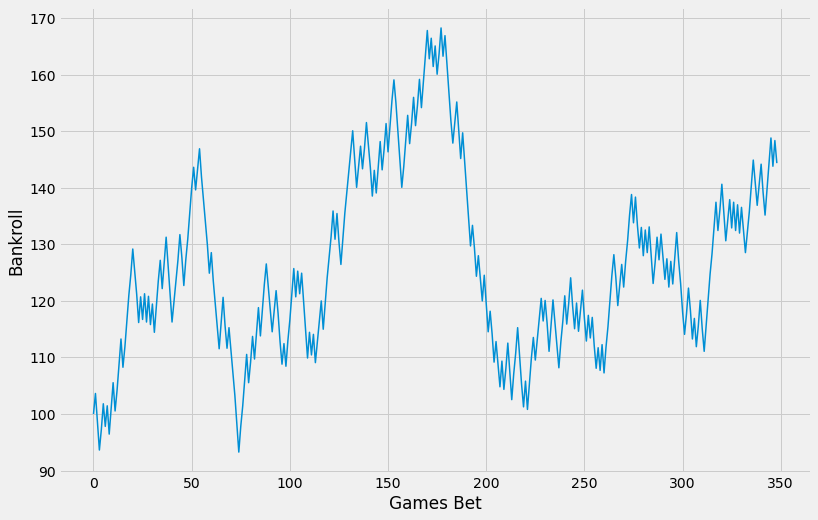

min balance: 93.27272727272727 
max balance: 168.27272727272694 
final balance: 147.9999999999994 
win percentage 54.15 
profit: 47.999999999999886 risk: 1590.0 
ROI: 3.02
4
test set 1: 2021-01-01 - 2021-07-20


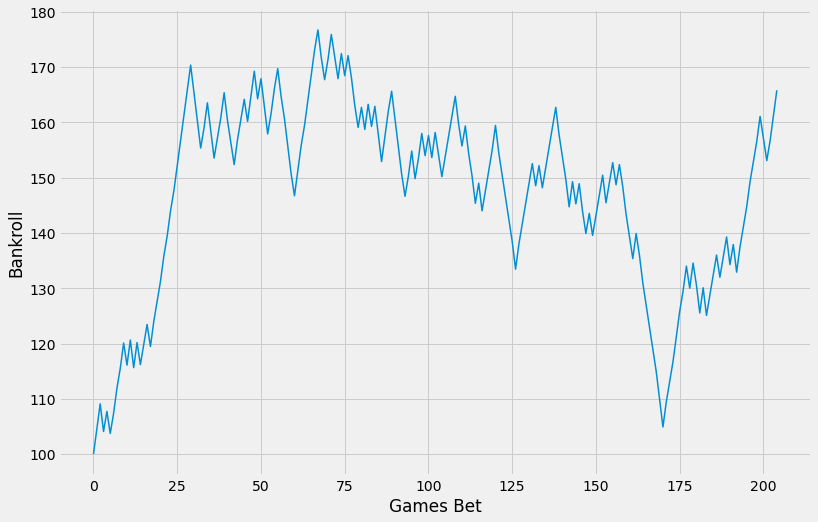

min balance: 103.72727272727273 
max balance: 176.7272727272724 
final balance: 170.36363636363532 
win percentage 56.589999999999996 
profit: 70.36363636363632 risk: 909.0 
ROI: 7.739999999999999

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.0011798799724438123,
                                                                    max_iter=10000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                       

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537975            474  0.026039   
1  (2017, -, 2018)            0.53  0.522682            507 -0.001076   
2  (2018, -, 2019)            0.53  0.528967            397  0.015875   
3  (2019, -, 2020)            0.53  0.541547            349  0.030189   
4  (2021, -, 2021)            0.53  0.565854            205  0.077408   

     profits  
0  57.363636  
1  -2.545455  
2  28.909091  
3  48.000000  
4  70.363636

In [113]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [660]:
best_lr_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001258237256125393, max_iter=10000,
                                    random_state=22, solver='saga',
                                    verbose=1))])

best_svc_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.003958061983606178, loss='hinge',
                           max_iter=100000, random_state=23))])

best_sgd_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.1572381278512917, loss='modified_huber',
                               max_iter=10000, random_state=23))])

best_lgbc_acc = lgb.LGBMClassifier(feature_fraction=0.7796269937403173, max_depth=5,
               min_child_weight=7, num_leaves=16860, random_state=22,
               reg_alpha=3.571940784753475, reg_lambda=17.76958546447963)

best_knn_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=24))])

best_rf_acc = RandomForestClassifier(max_depth=25,
                                min_samples_leaf=0.019764150817908317,
                                min_samples_split=0.10607525263857515,
                                random_state=22)

estimators2 = [('log', best_lr_acc), ('sgd', best_sgd_acc),
              ('svc', best_svc_acc), ('lgbc', best_lgbc_acc), 
              ('rf', best_rf_acc), ('knn', best_knn_acc)]


stacked_clf2 = StackingClassifier(estimators = estimators2, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))


0
test set 1: 2016-11-04 - 2017-06-12


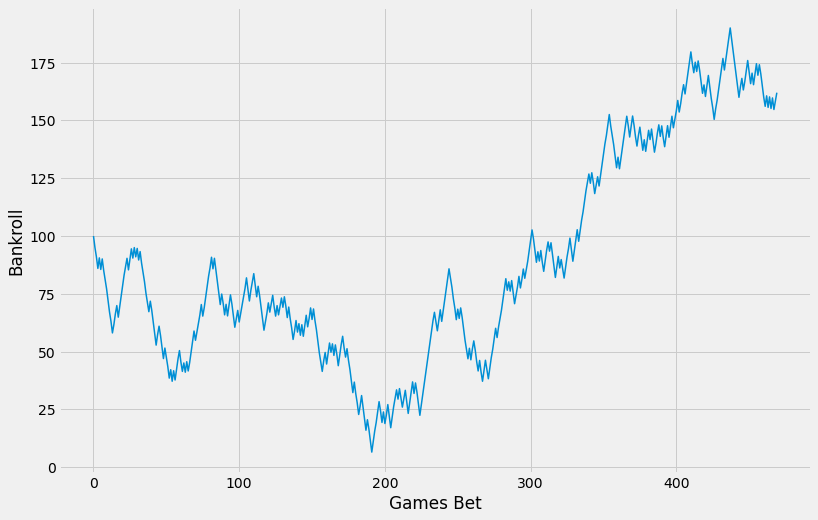

min balance: 6.545454545454625 
max balance: 189.99999999999957 
final balance: 165.63636363636303 
win percentage 53.620000000000005 
profit: 65.63636363636351 risk: 2189.0 
ROI: 3.0
1
test set 1: 2017-10-28 - 2018-06-08


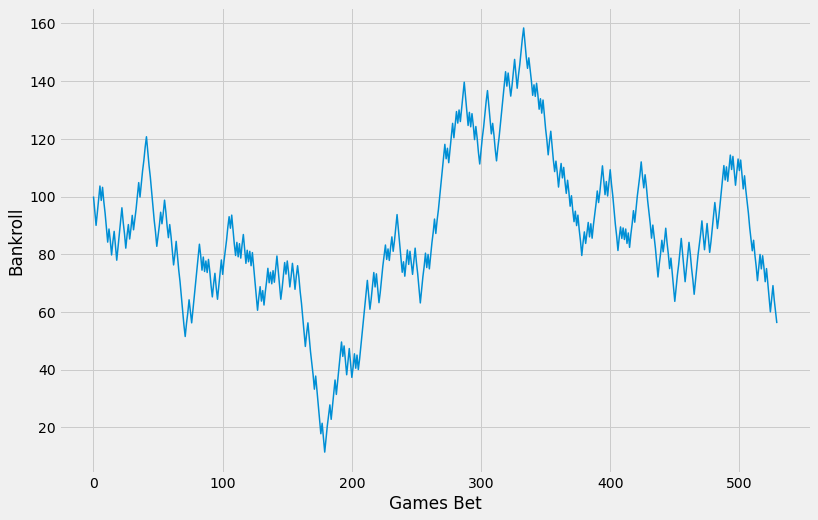

min balance: 11.36363636363652 
max balance: 158.45454545454544 
final balance: 52.09090909090921 
win percentage 51.32 
profit: -47.90909090909099 risk: 2482.0 
ROI: -1.9300000000000002
2
test set 1: 2018-10-26 - 2019-06-13


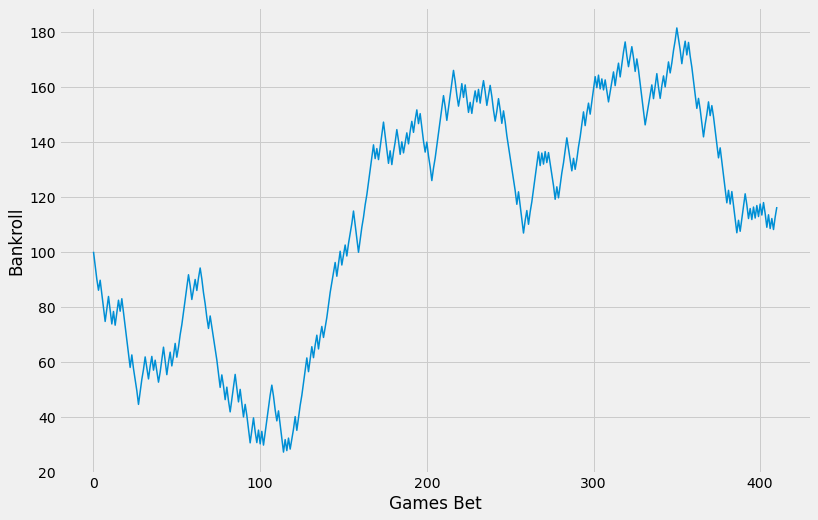

min balance: 27.090909090909136 
max balance: 181.4545454545445 
final balance: 119.90909090908988 
win percentage 52.55 
profit: 19.909090909090878 risk: 1893.0 
ROI: 1.05
3
test set 1: 2019-11-01 - 2020-10-11


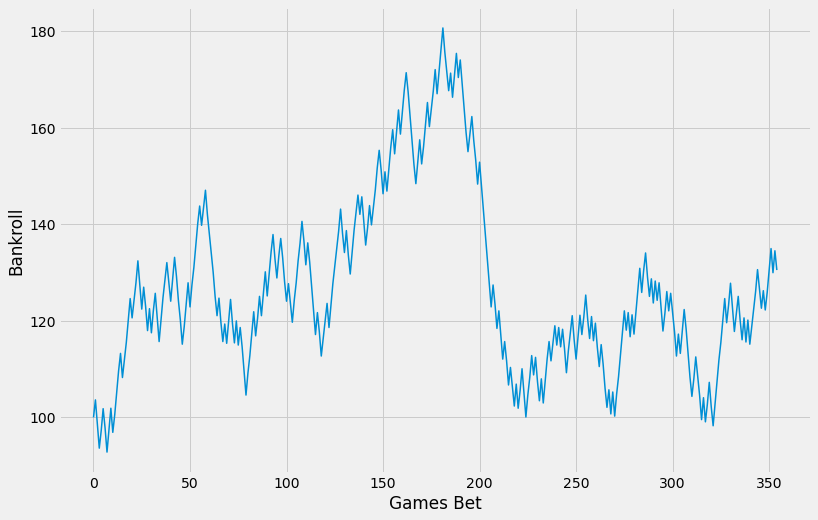

min balance: 92.81818181818183 
max balance: 180.7272727272722 
final balance: 134.18181818181765 
win percentage 53.52 
profit: 34.18181818181813 risk: 1621.0 
ROI: 2.11
4
test set 1: 2021-01-01 - 2021-07-20


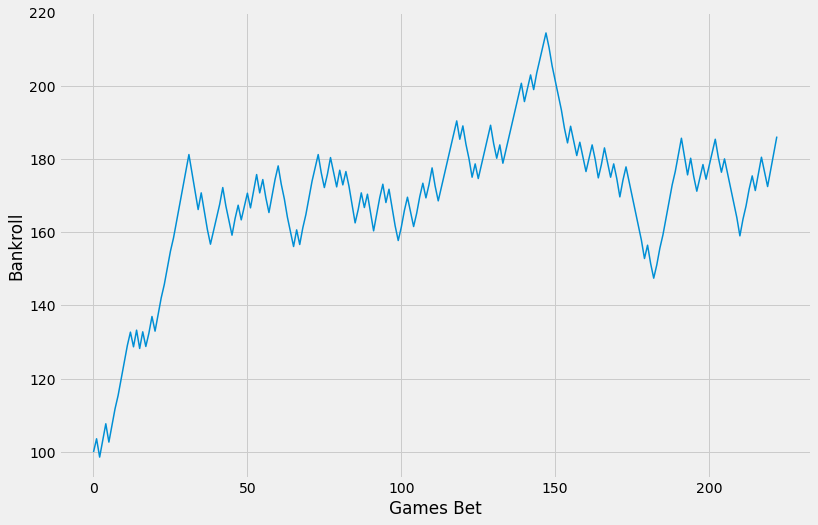

min balance: 98.63636363636364 
max balance: 214.36363636363544 
final balance: 190.6363636363623 
win percentage 56.95 
profit: 90.63636363636363 risk: 988.0 
ROI: 9.17

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SG

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.029985   
1  (2017, -, 2018)            0.53  0.513208            530 -0.019303   
2  (2018, -, 2019)            0.53  0.525547            411  0.010517   
3  (2019, -, 2020)            0.53  0.535211            355  0.021087   
4  (2021, -, 2021)            0.53  0.569507            223  0.091737   

     profits  
0  65.636364  
1 -47.909091  
2  19.909091  
3  34.181818  
4  90.636364

In [663]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


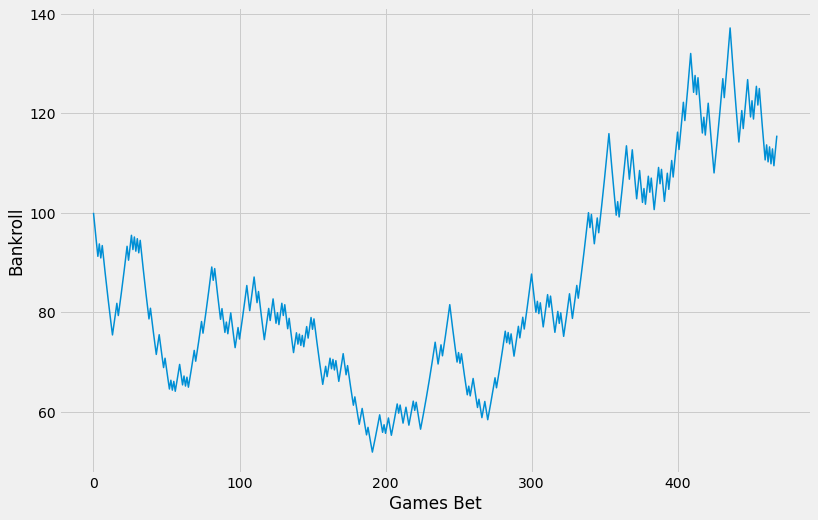

min balance: 51.95931418569775 
max balance: 137.1196961017868 
final balance: 118.65264767409444 
win percentage 53.73 
profit: 18.652647674094396 risk: 1192.5157733411133 
ROI: 1.5599999999999998
1
test set 1: 2017-10-28 - 2018-06-08


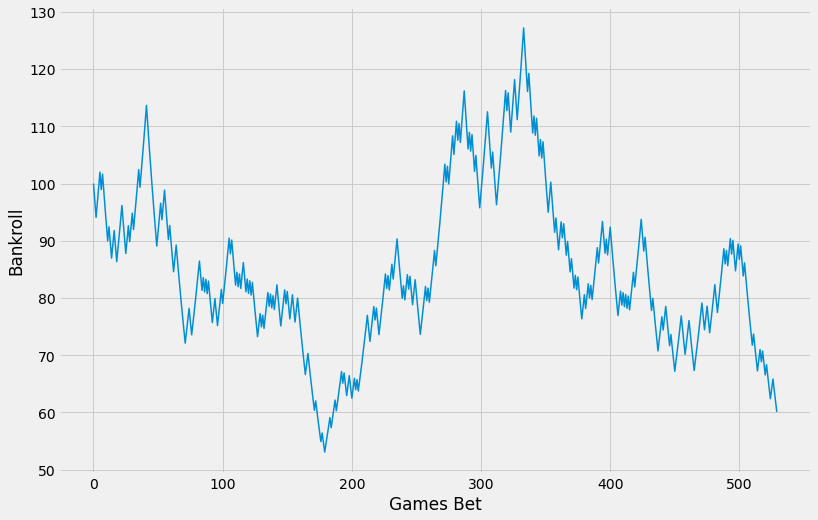

min balance: 53.078477196476335 
max balance: 127.18206300089665 
final balance: 58.29532195061766 
win percentage 51.32 
profit: -41.70467804938244 risk: 1350.6986843431337 
ROI: -3.09
2
test set 1: 2018-10-26 - 2019-06-13


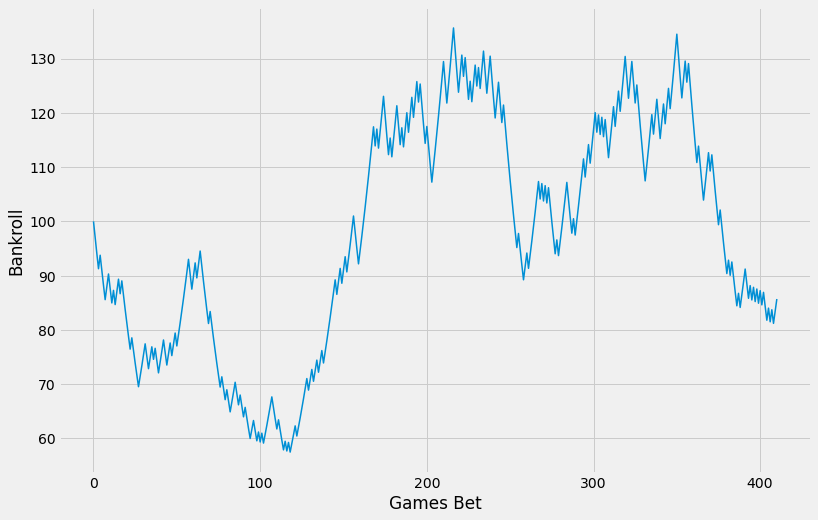

min balance: 57.47882989311353 
max balance: 135.63678545005874 
final balance: 88.02620525821162 
win percentage 52.55 
profit: -11.973794741788538 risk: 1205.5090846965707 
ROI: -0.9900000000000001
3
test set 1: 2019-11-01 - 2020-10-11


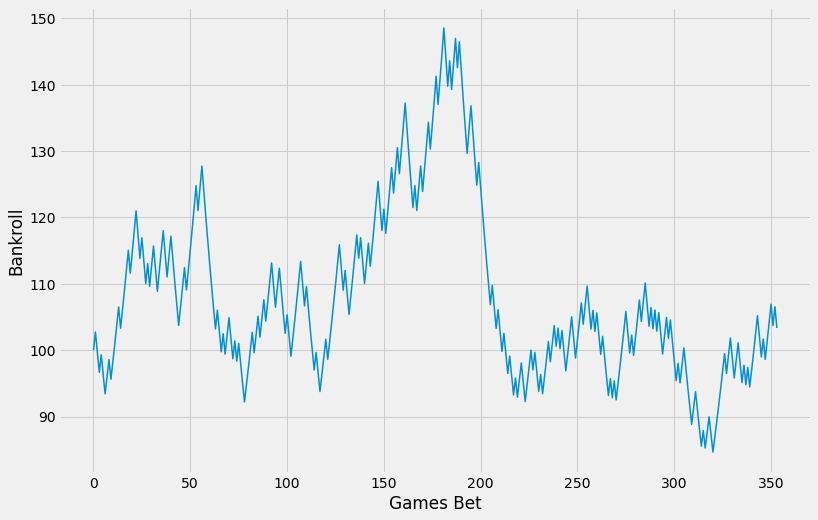

min balance: 84.64415680167593 
max balance: 148.53485625163472 
final balance: 106.15598328445795 
win percentage 53.39 
profit: 6.155983284457989 risk: 1146.171180097704 
ROI: 0.54
4
test set 1: 2021-01-01 - 2021-07-20


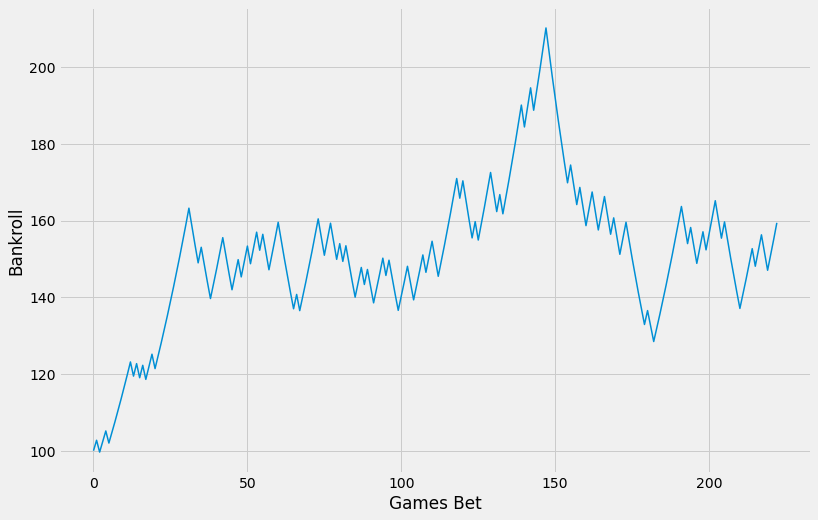

min balance: 99.64545454545456 
max balance: 210.19439280369414 
final balance: 163.74867588537154 
win percentage 56.95 
profit: 63.748675885371426 risk: 1011.0410842746564 
ROI: 6.3100000000000005

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                      

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537313            469  0.015641   
1  (2017, -, 2018)            0.53  0.513208            530 -0.030876   
2  (2018, -, 2019)            0.53  0.525547            411 -0.009933   
3  (2019, -, 2020)            0.53  0.533898            354  0.005371   
4  (2021, -, 2021)            0.53  0.569507            223  0.063053   

     profits  
0  18.652648  
1 -41.704678  
2 -11.973795  
3   6.155983  
4  63.748676

In [664]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_2(select_bets, unit_pct=0.03)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


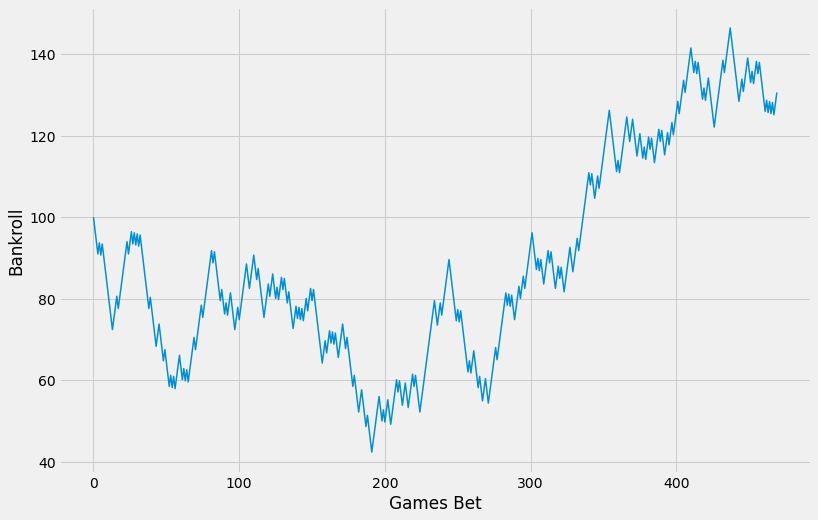

min balance: 42.45454545454595 
max balance: 146.3636363636373 
final balance: 133.27272727272813 
win percentage 53.620000000000005 
profit: 33.27272727272725 risk: 1410.0 
ROI: 2.36
1
test set 1: 2017-10-28 - 2018-06-08


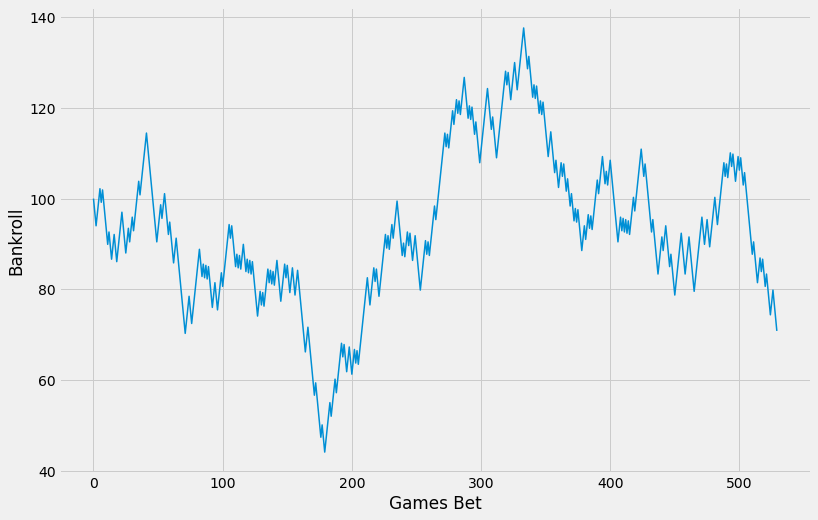

min balance: 44.09090909090962 
max balance: 137.63636363636468 
final balance: 67.81818181818343 
win percentage 51.32 
profit: -32.181818181818244 risk: 1590.0 
ROI: -2.02
2
test set 1: 2018-10-26 - 2019-06-13


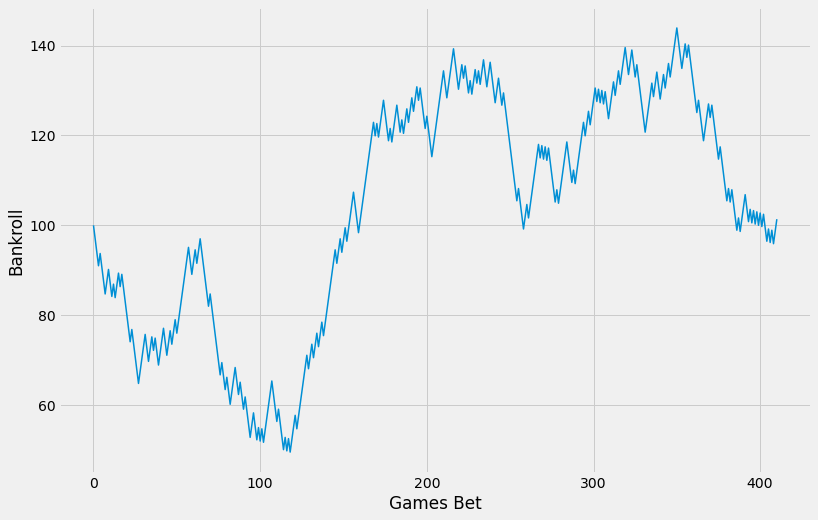

min balance: 49.54545454545478 
max balance: 143.9090909090913 
final balance: 104.0909090909096 
win percentage 52.55 
profit: 4.090909090909008 risk: 1233.0 
ROI: 0.33
3
test set 1: 2019-11-01 - 2020-10-11


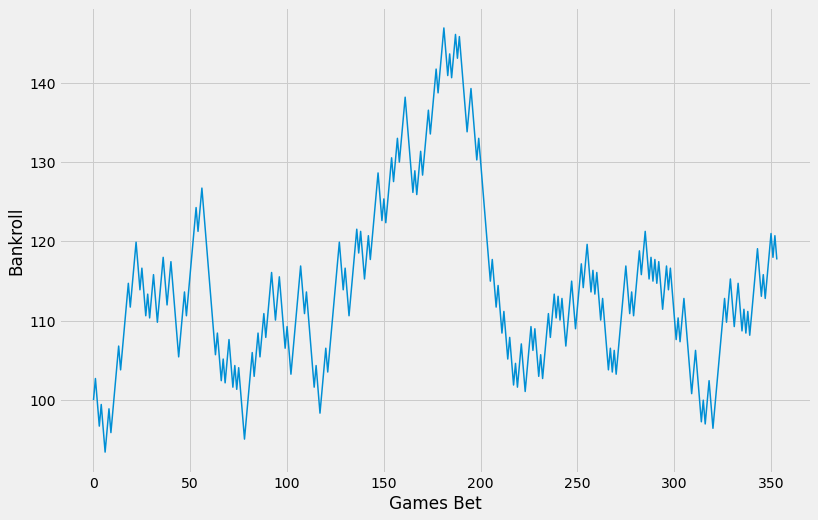

min balance: 93.45454545454547 
max balance: 146.90909090909133 
final balance: 120.45454545454633 
win percentage 53.39 
profit: 20.454545454545382 risk: 1062.0 
ROI: 1.9300000000000002
4
test set 1: 2021-01-01 - 2021-07-20


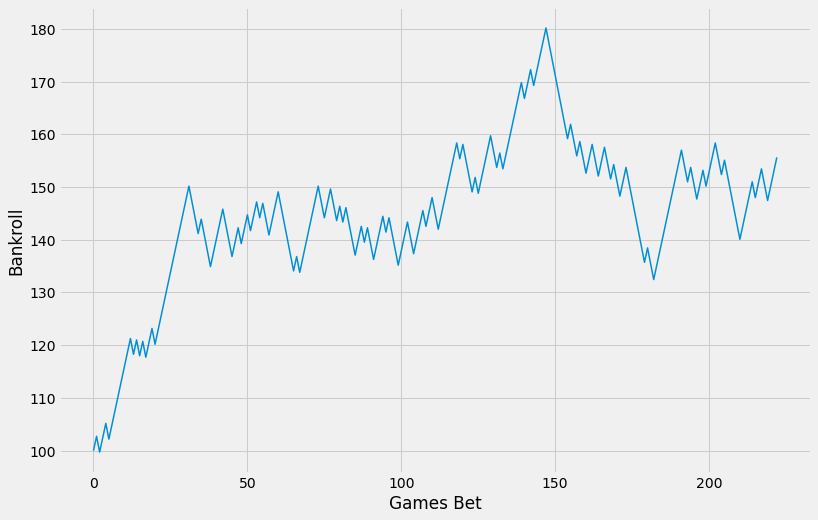

min balance: 99.72727272727273 
max balance: 180.1818181818177 
final balance: 158.3636363636356 
win percentage 56.95 
profit: 58.36363636363632 risk: 669.0 
ROI: 8.72

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SGD

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.023598   
1  (2017, -, 2018)            0.53  0.513208            530 -0.020240   
2  (2018, -, 2019)            0.53  0.525547            411  0.003318   
3  (2019, -, 2020)            0.53  0.533898            354  0.019260   
4  (2021, -, 2021)            0.53  0.569507            223  0.087240   

     profits  
0  33.272727  
1 -32.181818  
2   4.090909  
3  20.454545  
4  58.363636

In [665]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_1(select_bets, unit_size=3)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


## Make Predictions

ETL Pipeline

### Update Date

In [441]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


updating scoring boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


updating tracking boxscores
Updating 10 Games


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.00s/it]


### Get Todays Betting Data

In [442]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [443]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data('2020-21')

In [444]:
def get_team_and_opp_ewm_for_model(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'MIN_team', 'home_spread_mode', 'RECORD_team', 'team_covered', 'FG2M_team', 'FG2A_team',
       'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
       'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team',
       'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team',
       'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team',
       'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team',
       'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
       'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team',
       'SEASON_YEAR_opp', 'SEASON_ID_opp', 'TEAM_ID_opp',
       'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
       'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 'point_diff_opp',
       'WL_opp', 'MIN_opp', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
       'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
       'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp',
       'PLUS_MINUS_opp', 'E_OFF_RATING_opp', 'OFF_RATING_opp',
       'E_DEF_RATING_opp', 'DEF_RATING_opp', 'E_NET_RATING_opp',
       'NET_RATING_opp', 'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp',
       'AST_3PM_opp', 'UAST_3PM_opp', 'home_team', 'away_team', 'game_date',
       'away_spread_mode']]
    
    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp', 'home_team', 'away_team', 'game_date',
                           'away_spread_mode'])
    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        team_record = team_df['RECORD_team'].shift(1).expanding().mean()
        ATS_rec = team_df['team_covered'].shift(1).expanding().mean()
        records_df = pd.DataFrame({'WL_record':team_record, 
                                  'ATS_record':ATS_rec})

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records_df], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df


In [445]:
def add_rest_days_for_model(df):
    df['rest'] = np.nan
    for season in df['SEASON_YEAR_team'].unique():
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'rest'] = team_df['rest']
            
    return df

In [446]:
df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [447]:
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [448]:
prev_season_final_elo = {}
for team in full_df_ewm_19['TEAM_ABBREVIATION'].unique():
    team_df = full_df_ewm_19.loc[full_df_ewm_19['MATCHUP'].str.contains(team)].sort_values('GAME_DATE').reset_index(drop=True)
    if team_df.loc[team_df.shape[0]-1, 'MATCHUP'][:3] == team:
        final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    else:
        final_elo = team_df.loc[team_df.shape[0]-1, 'away_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'IND': 1529.4483384275268,
 'HOU': 1540.8964001636646,
 'POR': 1500.1407073118096,
 'LAL': 1684.3757506350337,
 'CLE': 1298.0343645791245,
 'SAS': 1522.744349117492,
 'MIN': 1340.3072979400008,
 'CHI': 1332.027526532048,
 'MIL': 1629.7867944120128,
 'GSW': 1360.7007973857746,
 'SAC': 1516.141852484055,
 'LAC': 1626.6462653315195,
 'MIA': 1618.0421597762124,
 'BOS': 1703.07997468606,
 'NYK': 1326.2237584707232,
 'ATL': 1337.167197222995,
 'NOP': 1499.3615728404923,
 'DAL': 1544.6886733768054,
 'UTA': 1549.7536707979227,
 'DET': 1342.6198199001185,
 'ORL': 1490.8373868097253,
 'BKN': 1467.7010014887078,
 'PHX': 1536.6695679529985,
 'MEM': 1553.2535462864591,
 'DEN': 1584.84073526912,
 'WAS': 1380.5107315006996,
 'CHA': 1394.9240309027477,
 'PHI': 1552.491927190443,
 'TOR': 1676.213996740524,
 'OKC': 1560.4746669932429}

In [449]:
with open("../data/final_elo_2020.pkl", 'wb') as file:
    pickle.dump(prev_season_final_elo, file)
    

In [450]:
# Add ELO ratings
with open("../data/final_elo_2020.pkl", "rb") as file:
    final_elo_2020 = pickle.load(file)


def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME_team'] == 1]
    # Initialize the following columns
    df = df.sort_values('GAME_DATE_team')

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP_team'][:3]
        away_team_abbr = row['MATCHUP_team'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)


progress:: 713it [00:01, 594.18it/s]


In [451]:
sorted(list(elo_ratings_dic.items()), key=lambda x: x[1], reverse=True)

[('UTA', 1695.1116127688701),
 ('DEN', 1643.9932061267505),
 ('PHX', 1643.2505280213047),
 ('PHI', 1641.91906223637),
 ('MIL', 1636.6251277234726),
 ('LAC', 1617.9483674908743),
 ('BKN', 1609.0970800387167),
 ('DAL', 1600.6323347879759),
 ('LAL', 1594.685823621672),
 ('ATL', 1549.0858878760444),
 ('CHA', 1529.246188892717),
 ('MEM', 1529.1740586616115),
 ('MIA', 1522.2233032905194),
 ('POR', 1509.5329643682226),
 ('BOS', 1508.5640846888216),
 ('IND', 1506.1032699853033),
 ('TOR', 1484.370998943311),
 ('NOP', 1460.0619221119289),
 ('NYK', 1459.8277688751557),
 ('SAC', 1454.8135939558026),
 ('SAS', 1445.5081664753009),
 ('GSW', 1443.6002087162024),
 ('CHI', 1422.7871491263463),
 ('OKC', 1406.9973753498114),
 ('DET', 1402.306882583506),
 ('ORL', 1388.455298586604),
 ('WAS', 1371.5658080238677),
 ('CLE', 1342.7394090393968),
 ('MIN', 1326.6109047226719),
 ('HOU', 1290.7402598053923)]

In [452]:
def create_matchup_rows_for_model(df, away_team, home_team, spread, current_elo_dic):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                      'SEASON_ID_team':'SEASON_ID',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df.sort_values(['GAME_DATE'], inplace=True)
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    home_stats.at[home_stats.shape[0]-1, 'rest'] = (datetime.today() - home_stats.at[home_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)
    away_stats.at[away_stats.shape[0]-1, 'rest'] = (datetime.today() - away_stats.at[away_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')

    diffs = home_stats.iloc[-1, 14:] - away_stats.iloc[-1, 14:]
    diffs = diffs.values.reshape(1, -1)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:]]
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
        
    diffs['home_rating_i'] = current_elo_dic[home_team]
    diffs['away_rating_i'] = current_elo_dic[away_team]
    diffs['home_elo_pred'] = 1.0/(1 + 10 ** (( diffs['away_rating_i'] - diffs['home_rating_i']) / (400.0)))

    diffs['elo_MOV_pred'] = round((diffs['home_rating_i']+100 - diffs['away_rating_i'])/28, 2)
    diffs['home_spread_mode'] = spread 
    
    diffs = diffs[X_train_ewm_19.columns]
    
    return diffs

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)

home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.179463      -0.0744681        -0.130346   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0         0.0100565       0.771314        1.38298   -0.000764037   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0        3.60108       1.18658      0.615254        -0.3409       -3.48034   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -3.82125       3.28415       2.38366      0.670353      -2.05369   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      3.52316       2.72691            -0.580535              -0.945318   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              1.11265              -0.177191               1.1315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              -0.786312           -0.0324955        1.48803   -0.00496232   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.20019          3.19163               4.46767   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             2.72338           2.67205           -1.99951          0.718132   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.695025             3.30745        0.130346     -0.135756   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0       1.99365      0.416147       -3.4697      2.33052      2.30673   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00117765       2.07533      2.07415      2.90665     -2.29005   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.671452      3.54816    0.931445      3.30745            0.580535   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0             -0.177191              1.1315             -0.945318   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             1.11265              0.786312           0.0324955       1.81846   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00496232             1.39736         3.59304             -4.42725   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -1.72532          2.22005          -2.37193         0.657797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.346865         -0.0158015          0.017094          -0.017094   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0         0.0158015        -0.0326693        0.0326693       -0.0169042   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0238796        -0.0201873        0.0145145             2.89928   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.42549          -2.17765          2.81216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.386336    1326.610905    1406.997375           0.7

### Make Predictions

In [453]:
todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.183092      -0.0763285        -0.144892   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0          0.011143        1.19352        2.20987   -0.000726966   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0         3.2203       1.87994       1.69273       0.741648       -2.30137   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -1.55972       2.97972       1.86619      0.521539      -1.49935   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      4.14165        4.2648             0.363874               0.192724   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              2.11145               0.115911              1.12315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              0.0677887             0.984322        1.99059   -0.00237432   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.44673          3.10111               3.84759   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             3.58807           2.97124           -1.88749         0.0143575   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.100572             3.90093        0.144892       -1.1599   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0      0.536119       1.02301      -1.28157      3.15171      2.90113   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00155193       1.63512      1.63357      3.34388     -1.87421   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.858817      2.82509     1.82035      3.90093           -0.363874   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0              0.115911             1.12315              0.192724   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             2.11145            -0.0677887           -0.984322       2.35787   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00237432            0.095416         3.99595              -3.6913   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -2.36804          2.24413          -3.42199           1.1797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.161641         0.00481673         0.0116754         -0.0116754   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0       -0.00481673         -0.017652         0.017652       -0.0128075   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0213821         -0.017978       0.00875831              2.4739   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.70151          -1.85381           2.1216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.383526    1329.036655    1411.484854          0.63

In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


away_team home_team  spread   game_date        net_pred
0       DAL       WAS     4.5  2021-04-03    [-2.0314543]
1       CLE       MIA   -12.0  2021-04-03    [-0.7431023]
2       MIN       PHI   -13.0  2021-04-03     [-2.774469]
3       NYK       DET     1.5  2021-04-03    [0.21155608]
4       IND       SAS    -6.0  2021-04-03    [-1.0953536]
5       ORL       UTA   -15.0  2021-04-03  [-0.026118085]
6       MIL       SAC     5.5  2021-04-03    [0.10418765]
7       OKC       POR   -11.5  2021-04-03     [-2.474314]

In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df